# Feature Engineering

Within this section I'll create new features from the information provided within the dataset. There are several features that would/could be beneficial to help a model predict the cost of a transit project that were not originally included in the source dataset.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from meteostat import Normals, Point, Stations

### Data Imports

In [2]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)
with open('pickles/df_soil_v2.pkl', 'rb') as f:
    df_soil = pickle.load(f)
with open('pickles/df_elevation.pkl', 'rb') as f:
    df_elevation = pickle.load(f)
with open('pickles/df_climate.pkl', 'rb') as f:
    df_climate = pickle.load(f)

In [3]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,5
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,6
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,6
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,2
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,2
1668,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,1
1669,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,3
1670,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,4


## Population Density

The cost of a transit project can often be largely dependent on how expensive land aquisition costs are. Projects in cities that are more densely population will be more difficult to build and activities associated with construction staging, land aquisition, craning, and drilling will be more difficult.

Let's look at how we can engineer a feature that details the population density surrounding a project.

### Country Level Density Index

The most straightforward way to evaluate the population density would be to include the country population density index. This value indexes the population density over an entire country, rather than using the specific location of the project.

Let's look at what this looks like and compare the density index of the country vs. the cities within that country

In [4]:
df_country_density = pd.read_csv('Data/CountryPopulationDensity/API_EN.POP.DNST_DS2_en_csv_v2_5729014.csv')

In [5]:
df_country_density.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,310.061111,314.900000,319.305556,323.211111,326.566667,...,575.522222,579.205556,582.633333,585.772222,588.677778,591.344444,592.138889,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,9.207577,9.459187,9.719622,9.992443,10.276307,...,39.316116,40.417838,41.520478,42.623160,43.768985,44.946830,46.150711,NaN,NaN,NaN
2,Afghanistan,AFG,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,13.477056,13.751356,14.040239,14.343888,14.665298,...,50.160542,51.750915,53.104284,54.648541,56.248231,57.908252,59.752281,NaN,NaN,NaN
3,Africa Western and Central,AFW,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,10.978074,11.213633,11.459305,11.712711,11.975377,...,43.982443,45.180225,46.405991,47.661860,48.934069,50.222984,51.536679,NaN,NaN,NaN
4,Angola,AGO,Population density (people per sq. km of land ...,EN.POP.DNST,NaN,4.364589,4.428812,4.491720,4.550573,4.601413,...,21.760116,22.561740,23.385535,24.230872,25.085051,25.951382,26.813577,NaN,NaN,NaN


##### Dropping Unnecessary Features & Rows

In [6]:
df_country_density.drop(columns = ['1960','2021','2022','Unnamed: 67'],inplace = True)

In [7]:
# df_country_density.drop(index = [261],inplace = True)

In [8]:
df_country_density.drop(columns = ['Indicator Name','Indicator Code'],inplace = True)

In [9]:
df_country_density.sort_values(by='Country Code', ascending= False).head(2)

,Country Name,Country Code,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
265,Zimbabwe,ZWE,10.148512,10.468600,10.799873,11.142127,11.495797,11.861261,12.239095,12.631115,...,33.671410,34.290632,35.040512,35.816862,36.590247,37.359969,38.131320,38.909614,39.691374,40.505793
264,Zambia,ZMB,4.330770,4.470637,4.615856,4.765687,4.920733,5.081693,5.247969,5.419999,...,19.190215,19.834351,20.493921,21.170305,21.856939,22.555807,23.269151,23.992646,24.725214,25.461353


In [10]:
df.sort_values(by='country',ascending = True).head(2)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration
1629,AE,Dubai,2006,2009,0.0,5.367346,0.000000,0.0,5.367346,0.0,...,1025.548356,191.071792,0.0,0.0,0,1.267729,1300.117760,242.227320,Monorail,3
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.0,...,7527.524935,215.072141,0.0,0.0,0,1.267729,9542.864356,272.653267,MRT,5


#### Correcting Country Code Formats

In some of the rows, the country code format varies from data to data. I'll convert the 3 letter country codes into 2 letter codes using a [seperate dataset provided by lukes on Github](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/tree/master)

In [11]:
df_codes = pd.read_csv('Data/CountryPopulationDensity/CountryCodes.csv')

In [12]:
df_codes.head(5)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [13]:
df_codes[df_codes['alpha-2'] =='US']

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
235,United States,US,USA,840,ISO 3166-2:US,Americas,Northern America,NaN,19.0,21.0,NaN


#### Mapping GBR to UK

In [14]:
df_codes.loc[df_codes['alpha-2'] == 'GB', 'alpha-2'] = 'UK'

In [15]:
df_codes.drop(columns = ['country-code','iso_3166-2','intermediate-region','region-code','sub-region-code','intermediate-region-code'],inplace = True)

In [16]:
df_codes.rename(columns = {'alpha-3':'Country Code'},inplace = True)

In [17]:
df_density = pd.merge(df_country_density,df_codes,on='Country Code')

In [18]:
df_density.head(5)

,Country Name,Country Code,1961,1962,1963,1964,1965,1966,1967,1968,...,2015,2016,2017,2018,2019,2020,name,alpha-2,region,sub-region
0,Aruba,ABW,310.061111,314.900000,319.305556,323.211111,326.566667,329.394444,330.677778,330.394444,...,579.205556,582.633333,585.772222,588.677778,591.344444,592.138889,Aruba,AW,Americas,Latin America and the Caribbean
1,Afghanistan,AFG,13.477056,13.751356,14.040239,14.343888,14.665298,14.999535,15.347393,15.711911,...,51.750915,53.104284,54.648541,56.248231,57.908252,59.752281,Afghanistan,AF,Asia,Southern Asia
2,Angola,AGO,4.364589,4.428812,4.491720,4.550573,4.601413,4.641890,4.674343,4.706989,...,22.561740,23.385535,24.230872,25.085051,25.951382,26.813577,Angola,AO,Africa,Sub-Saharan Africa
3,Albania,ALB,60.576642,62.456898,64.329234,66.209307,68.058066,69.874927,71.737153,73.805547,...,105.135146,104.967190,104.870693,104.612263,104.167555,103.571131,Albania,AL,Europe,Southern Europe
4,Andorra,AND,21.736170,23.434043,25.189362,27.000000,28.857447,30.948936,33.500000,36.338298,...,152.651064,154.340426,157.100000,159.602128,162.431915,165.319149,Andorra,AD,Europe,Southern Europe


Some of the years in our project data dataset are in the future and will not have a population density available for many rows. We'll use the latest (2020) population density and extrapolate that year to the future to fill these values.

In [19]:
for year in ['2021','2022','2023','2024','2025','2026','2027','2028','2029','2030','2031','2032','2033','2034','2035','2036']:
    df_density[year] = df_density['2020']

In [20]:
# df_density.loc[df_density['Country Code'] == 'GB', 'Country Code'] = 'UK'

In [21]:
df_density[df_density['Country Code'] == 'USA']

,Country Name,Country Code,1961,1962,1963,1964,1965,1966,1967,1968,...,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
202,United States,USA,20.05588,20.366723,20.661953,20.950959,21.214527,21.460952,21.695913,21.913623,...,36.240985,36.240985,36.240985,36.240985,36.240985,36.240985,36.240985,36.240985,36.240985,36.240985


In [22]:
df_density.drop(columns = 'Country Code',inplace = True)

In [23]:
df_density.rename(columns = {'alpha-2':'Country Code'},inplace = True)

Now we have a dataframe the provides us with a 2-digit country code along with the population density for each year between 1960 and 2020. For each project in our initial dataset, we'll use the year and country code to pull the correct population density and add it to a new column called 'country_pop_den'.

In [24]:
df_melted = df_density.melt(id_vars=['Country Code'], 
                      value_vars=[str(i) for i in range(1961, 2036)], 
                      var_name='Year', 
                      value_name='Population Density')

df_melted['Year'] = df_melted['Year'].astype(int)

In [25]:
df_melted.rename(columns = {'Country Code':'country','Year':'year','Population Density':'country_pop_den'},inplace = True)

In [26]:
# pd.set_option('display.max_columns', None)

In [27]:
df_melted.head(5)

,country,year,country_pop_den
0,AW,1961,310.061111
1,AF,1961,13.477056
2,AO,1961,4.364589
3,AL,1961,60.576642
4,AD,1961,21.736170


In [28]:
df_melted[df_melted['country'] == 'US']

,country,year,country_pop_den
202,US,1961,20.055880
417,US,1962,20.366723
632,US,1963,20.661953
847,US,1964,20.950959
1062,US,1965,21.214527
...,...,...,...
15252,US,2031,36.240985
15467,US,2032,36.240985
15682,US,2033,36.240985
15897,US,2034,36.240985


In [29]:
df = pd.merge(df, df_melted, on =['country','year'], how='left')

In [30]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration,country_pop_den
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,5,6410.285714
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,6,224.308544
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,6,141.936072
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,2,149.723553
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,2,116.203904


#### Spot Fixing Missing Values After Merge

After merging the data, there's a few rows that are missing values. I'll spot check those values below and address each point.

In [31]:
df['country_pop_den'].isna().sum()

29

In [32]:
# pd.set_option('display.max_rows', None)

In [33]:
df[df['country_pop_den'].isna()].sort_values(by='country',ascending= True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration,country_pop_den
104,TW,Taipei,2016,2022,0.0,1.400000,1.000000,1.400000,0.000000,0.000000,...,1226.010646,0.0,0.0,0,1.067626,1832.488331,1308.920236,MRT,6,NaN
1570,TW,Taipei,1989,1996,0.0,10.500000,0.000000,0.000000,10.500000,0.000000,...,1760.935412,0.0,0.0,0,1.888899,34925.409610,3326.229486,MRT,7,NaN
1563,TW,Taipei,2014,2025,0.0,9.500000,1.000000,9.500000,0.000000,0.000000,...,1512.260332,0.0,0.0,0,1.054615,15151.096490,1594.852262,MRT,11,NaN
1562,TW,Taipei,2021,2028,0.0,6.600000,0.000000,0.000000,0.000000,6.600000,...,591.915686,0.0,0.0,0,0.970410,3791.044219,574.400639,MRT,7,NaN
1550,TW,Taipei,2015,2018,0.0,9.700000,0.000000,0.000000,4.500000,5.200000,...,255.986238,0.0,0.0,0,1.113520,2764.943327,285.045704,MRT,3,NaN
1549,TW,Taipei,2023,2031,0.0,5.500000,0.500000,2.750000,2.750000,0.000000,...,1491.627528,0.0,0.0,0,0.942520,7732.388080,1405.888742,MRT,8,NaN
1548,TW,Taipei,2018,2024,0.0,17.044928,0.500000,8.522464,8.522464,0.000000,...,1313.761817,0.0,0.0,0,1.007292,22556.266420,1323.341869,MRT,6,NaN
1547,TW,Taipei,2016,2023,0.0,7.578861,0.000000,0.000000,1.000000,6.578861,...,424.196890,0.0,0.0,0,1.054615,3390.512290,447.364357,MRT,7,NaN
912,TW,Taipei,1988,2012,0.0,93.900000,0.648562,60.900000,33.000000,0.000000,...,1630.480146,0.0,0.0,0,1.585052,242674.749100,2584.395624,MRT,24,NaN
875,TW,Kaohsiung,2001,2008,0.0,43.000000,0.739535,31.800000,11.200000,0.000000,...,1241.305244,0.0,0.0,0,1.397573,74597.011940,1734.814231,MRT,7,NaN


In [34]:
country_pop_density = {
    'DR': {2005: 188.5,2009: 198.23, 2022: 230.17},
    'EG': 107.76,
    'TW': {1988:551,1989:551,2000: 627,2002: 627, 2008: 644, 2010: 652,2011: 652 ,2014:664, 2015: 664,2015: 664, 2019: 673 ,2020: 676,2023: 676},
    'VN': 308.2,
    'US': {2035:40,2038:40, 2040:41}
}

In [35]:
def fill_missing_pop_density(df):
    for index, row in df.iterrows():
        country = row['country']
        year = row['start_year']

        if pd.isna(row['country_pop_den']):
            if country in country_pop_density:
                if isinstance(country_pop_density[country], dict):
                    closest_year = max(y for y in country_pop_density[country] if y <= year)
                    df.at[index, 'country_pop_den'] = country_pop_density[country][closest_year]
                else:
                    df.at[index, 'country_pop_den'] = country_pop_density[country]

fill_missing_pop_density(df)

In [36]:
df[df['country_pop_den'].isna()].sum().sum()

0.0

Now we have a new feature called 'country_pop_den' that provides us with insight into how dense a given country is. While we're at it, I noticed that there's several additional pieces of information that would be relevant that we left behind in df_density. Specifically, I want to merge in the information about the regions and sub-regions.

In [37]:
df_regions = df_density[['Country Code','region','sub-region']]

In [38]:
df_regions = df_regions.rename(columns = {'Country Code':"country",'sub-region':'sub_region'})

In [39]:
df_regions

,country,region,sub_region
0,AW,Americas,Latin America and the Caribbean
1,AF,Asia,Southern Asia
2,AO,Africa,Sub-Saharan Africa
3,AL,Europe,Southern Europe
4,AD,Europe,Southern Europe
...,...,...,...
210,WS,Oceania,Polynesia
211,YE,Asia,Western Asia
212,ZA,Africa,Sub-Saharan Africa
213,ZM,Africa,Sub-Saharan Africa


#### Merging Sub/Region data

In [40]:
df = pd.merge(df,df_regions, on = 'country',how = 'left')

In [41]:
df[df['region'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration,country_pop_den,region,sub_region
104,TW,Taipei,2016,2022,0.0,1.400000,1.000000,1.400000,0.000000,0.000000,...,0.0,0,1.067626,1832.488331,1308.920236,MRT,6,664.0,NaN,NaN
180,TW,Taipei,2014,2024,0.0,14.000000,0.000000,0.000000,0.000000,14.000000,...,0.0,0,1.067626,3115.230162,222.516440,MRT,10,664.0,NaN,NaN
224,TW,Taipei,2019,2025,0.0,11.500000,0.000000,0.000000,11.500000,0.000000,...,0.0,0,1.015482,4310.504768,374.826502,MRT,6,673.0,NaN,NaN
318,TW,Tainan,2019,2024,1.0,8.200000,1.000000,8.200000,0.000000,0.000000,...,0.0,0,1.015482,6470.826260,789.125154,MRT,5,673.0,NaN,NaN
402,TW,Taipei,2002,2013,0.0,6.500000,1.000000,6.500000,0.000000,0.000000,...,0.0,0,1.267729,12176.296730,1873.276420,MRT,11,627.0,NaN,NaN
417,TW,Taipei,2023,2032,0.0,16.000000,0.100000,1.600000,12.800000,1.600000,...,0.0,0,0.929168,8570.662110,535.666382,MRT,9,676.0,NaN,NaN
481,TW,Taipei,2016,2023,0.0,14.290000,0.000000,0.000000,14.290000,0.000000,...,0.0,0,1.054615,10253.235960,717.511264,MRT,7,664.0,NaN,NaN
519,TW,Taipei,2021,2028,0.0,13.300000,0.210526,2.800000,10.500000,0.000000,...,0.0,0,0.970410,11695.371420,879.351234,MRT,7,676.0,NaN,NaN
536,TW,Taichung,2010,2020,0.0,16.700000,0.000000,0.000000,16.700000,0.000000,...,0.0,0,1.151588,13301.823150,796.516356,MRT,10,652.0,NaN,NaN
574,TW,Taipei,2002,2009,0.0,14.800000,0.256757,3.800000,11.000000,0.000000,...,0.0,0,1.353898,24298.092360,1641.762997,MRT,7,627.0,NaN,NaN


Again, there are missing values for both Taiwan and the Dominican Republic. I'll need to populate them.

In [42]:
df.loc[df['country'] == 'TW', 'region'] = 'Asia'
df.loc[df['country'] == 'TW', 'sub_region'] = 'Eastern Asia'

In [43]:
df.loc[df['country'] == 'DR', 'region'] = 'Americas'
df.loc[df['country'] == 'DR', 'sub_region'] = 'Latin America and the Caribbean'

In [44]:
df[df['region'].isna()].sum().sum()

0.0

Now that we've extracted all the relevant information we can from the country density dataset, let's see if we can extract city specific population densities.

### City Population Density

We'll complete a similar process for the cities in the df above. For this data, I'll need to cobble together several datasets to get population densities for each city in the dataset.

The datasets I will be using are:

- SimpleMaps (lat,lng, population)
- WorldMaps (Annual rate of population change)
- World Mayor (Land Area)
- Wikipedia (Spot checks and spot replacements when needed)

##### Importing sub-datasets

In [45]:
df_cities = pd.read_csv('Data/CityPopDen/data/worldcities.csv')
df_pop_change = pd.read_csv('Data/CityPopDen/data/world_city_pop.csv')
df_area = pd.read_csv('Data/CityPopDen/data/land_area.csv')

#### Sub-dataset Cleaning

In [46]:
df_pop_change.drop_duplicates(subset = 'city',inplace= True)
df_cities.drop_duplicates(subset = ['city','country'],inplace = True)
df_area.drop_duplicates(subset = ['City','Country'],inplace = True)

In [47]:
df_cities.drop(columns = ['iso3','admin_name','capital','id'],inplace = True)
df_cities.rename(columns ={'Value':'population_2020'},inplace = True)
df_area.rename(columns ={'City':'city'},inplace = True)
df_area.rename(columns ={'Area_km':'area_km'},inplace = True)

#### Merging Population Change & Cities df

In [48]:
df_cities.drop(columns = ['city'],inplace = True)
df_cities.rename(columns ={'city_ascii':'city'},inplace = True)
df_cities = pd.merge(df_cities,df_pop_change, on =['city','country'], how = 'left')

In [49]:
df_cities[df_cities['city'] =='Sao Paulo']

,city,lat,lng,country,iso2,population,growthRate
8889,Sao Paulo,-23.55,-46.6333,Brazil,BR,23086000,0.0085


#### Merging 2-Digit Country code into df_area

In [50]:
df_area.rename(columns = {'Country': 'country'},inplace = True)

In [51]:
iso_2 = df_cities[['country','iso2']]

In [52]:
df_area = pd.merge(df_area,iso_2,on = 'country')

In [53]:
df_area.drop_duplicates(inplace= True)

In [54]:
df_area

,city,country,area_km,iso2
0,Chongqing,China,"5,472.80",CN
1479,Harbin,China,"2,454.50",CN
2958,Ganzhou,China,"3,843.43",CN
4437,Nanyang,China,"1,988",CN
5916,Changchun,China,"1,855.00",CN
...,...,...,...,...
951619,Port Louis,Mauritius,46.79,MU
951635,Dakar,Senegal,83,SN
951694,Sfax,Tunisia,95.99,TN
951836,Tunis,Tunisia,212.63,TN


#### Merging df_area into df

In [55]:
df_area.drop(columns = ['country'],inplace = True)

In [56]:
df_area.rename(columns = {'iso2':'country'},inplace= True)

In [57]:
df = pd.merge(df,df_area,on = ['country','city'],how = 'left')

In [58]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration,country_pop_den,region,sub_region,area_km
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,0,1.483402,4632.035892,3563.104532,MRT,5,6410.285714,Asia,Eastern Asia,290
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,0,6.739406,313.401664,208.934443,MRT,6,224.308544,Europe,Western Europe,984
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,0,1.251724,1797.577974,404.222616,MRT,6,141.936072,Asia,Eastern Asia,16410
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,0,1.054615,726.857798,201.904944,MRT,2,149.723553,Asia,Eastern Asia,16410
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,0,1.353898,80.197844,80.197844,MRT,2,116.203904,Europe,Western Europe,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,0,0.970410,210.606202,140.404135,Light Rail,2,94.815384,Europe,Southern Europe,141.4
1668,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,1,1.015482,6.241206,12.482413,Tramway,1,19.331586,Oceania,Australia and New Zealand,295.00
1669,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,1,0.970410,200.771905,118.101121,Light Rail,3,3.335312,Oceania,Australia and New Zealand,814.2
1670,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,0,0.970410,2107.898620,160.908292,Tramway,4,45.904157,Americas,Latin America and the Caribbean,382


#### Merging df_cities into df

In [59]:
df_cities.head(5)

,city,lat,lng,country,iso2,population,growthRate
0,Zywiec,49.6892,19.2058,Poland,PL,30334,NaN
1,Zyryanovsk,49.7453,84.2548,Kazakhstan,KZ,49658,NaN
2,Zyryanka,65.7360,150.8900,Russia,RU,3627,NaN
3,Zyrardow,52.0500,20.4333,Poland,PL,39374,NaN
4,Zychlin,52.2453,19.6236,Poland,PL,9021,NaN


In [60]:
df_cities.drop(columns =['country'],inplace = True)

In [61]:
df_cities.rename(columns ={'iso2':'country'},inplace = True)

In [62]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,duration,country_pop_den,region,sub_region,area_km
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,0,1.483402,4632.035892,3563.104532,MRT,5,6410.285714,Asia,Eastern Asia,290
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,0,6.739406,313.401664,208.934443,MRT,6,224.308544,Europe,Western Europe,984
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,0,1.251724,1797.577974,404.222616,MRT,6,141.936072,Asia,Eastern Asia,16410
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,0,1.054615,726.857798,201.904944,MRT,2,149.723553,Asia,Eastern Asia,16410
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,0,1.353898,80.197844,80.197844,MRT,2,116.203904,Europe,Western Europe,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,0,0.970410,210.606202,140.404135,Light Rail,2,94.815384,Europe,Southern Europe,141.4
1668,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,1,1.015482,6.241206,12.482413,Tramway,1,19.331586,Oceania,Australia and New Zealand,295.00
1669,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,1,0.970410,200.771905,118.101121,Light Rail,3,3.335312,Oceania,Australia and New Zealand,814.2
1670,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,0,0.970410,2107.898620,160.908292,Tramway,4,45.904157,Americas,Latin America and the Caribbean,382


In [63]:
df_cities.head(5)

,city,lat,lng,country,population,growthRate
0,Zywiec,49.6892,19.2058,PL,30334,NaN
1,Zyryanovsk,49.7453,84.2548,KZ,49658,NaN
2,Zyryanka,65.7360,150.8900,RU,3627,NaN
3,Zyrardow,52.0500,20.4333,PL,39374,NaN
4,Zychlin,52.2453,19.6236,PL,9021,NaN


In [64]:
df = pd.merge(df,df_cities,on=['city','country'],how = 'left')

### Calculating Population at Project Year

Now that I have values for the population in each city as of 2020, we'll need to extrapolate the growth rate out to the Year provided for each project. Since the growth rate was taken as an average growth rate over a 20 year period, this step will introduce some error. I anticipate that the magnitude of this error will be small, as the distribution of projects in our dataset are mostly recent.

In [65]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,train_type,duration,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,MRT,5,6410.285714,Asia,Eastern Asia,290,22.300,114.2000,7450000,0.0054
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,MRT,6,224.308544,Europe,Western Europe,984,52.520,13.4050,4473101,0.0009
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,MRT,6,141.936072,Asia,Eastern Asia,16410,39.904,116.4075,18522000,0.0203
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,MRT,2,149.723553,Asia,Eastern Asia,16410,39.904,116.4075,18522000,0.0203
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,MRT,2,116.203904,Europe,Western Europe,954,45.760,4.8400,522969,0.0078


#### Calculating Difference between Provided Year & 2020

In [66]:
df['time_diff'] = 2020- df['year']

In [67]:
df['population'] = df['population'].str.replace(',', '').astype(float)

In [68]:
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

In [69]:
check = df[['city','year','calculated_population']]
check[check['city'] =='Chicago'].sort_values(by = 'calculated_population')

,city,year,calculated_population
1213,Chicago,2023,8.176701e+06
1215,Chicago,2022,8.313880e+06
86,Chicago,1990,1.415872e+07
1072,Chicago,1981,1.644579e+07


#### Sanity Check

Since the previous step is somewhat abstracted, I want to check for outliers again. It's possible I've compounded errors with a miscalculation on a misstated value.

Let's check

##### Comparison of Distributions

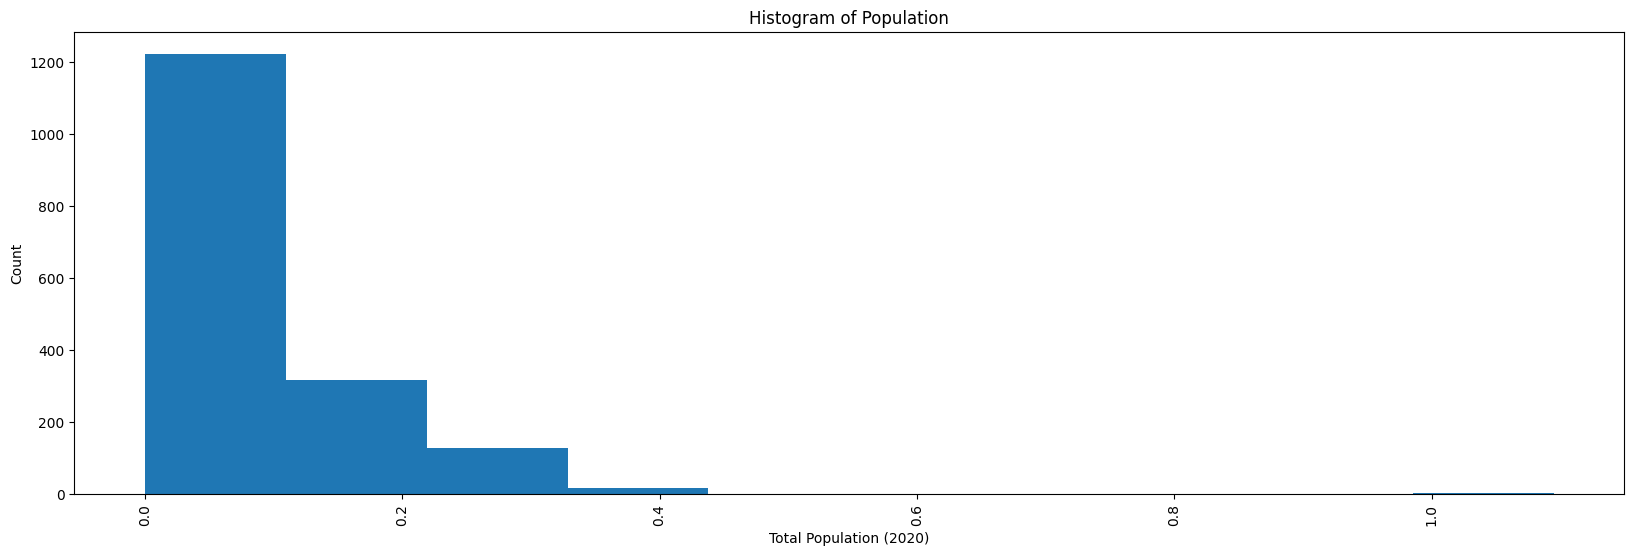

In [70]:
n_bins = 10


fig, axs = plt.subplots(1, 1, figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)
axs.hist(df['population'], bins=n_bins)

axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Total Population (2020)')
axs.set_ylabel('Count')
axs.set_title('Histogram of Population')

plt.show()

 Base populations look to be reasonable. No significant outliers.

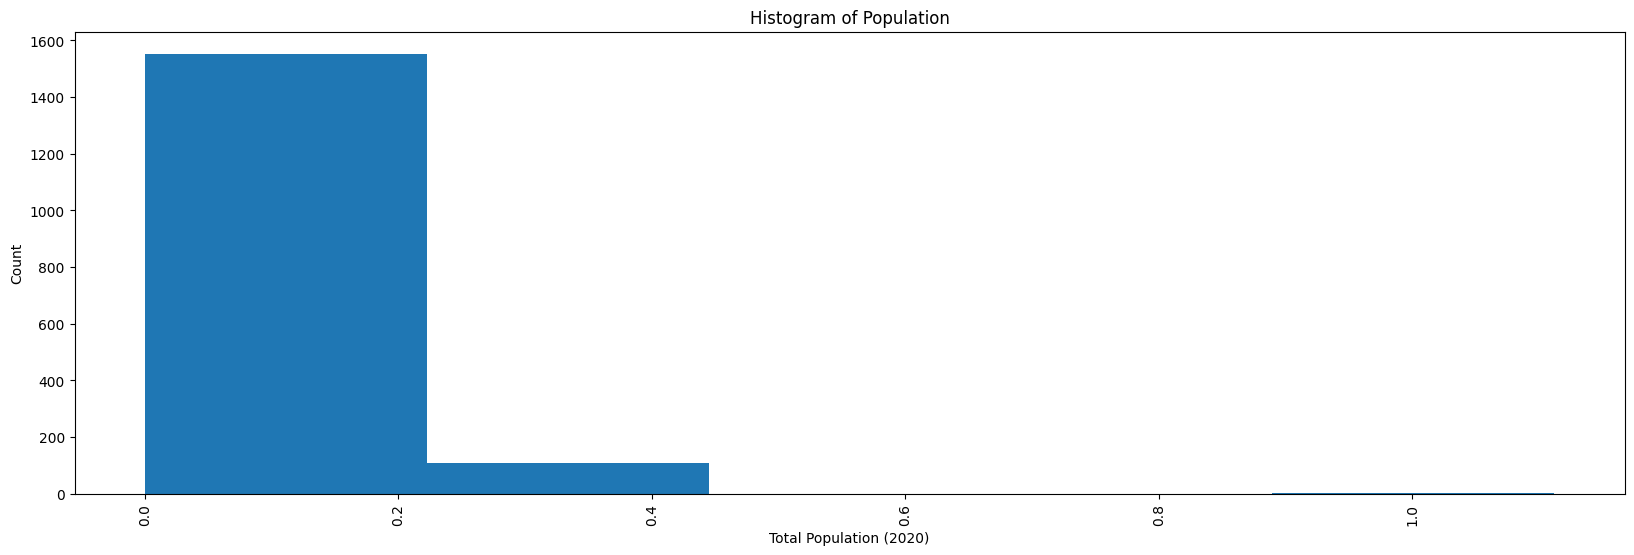

In [71]:
n_bins = 5

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)

axs.hist(df['calculated_population'], bins=n_bins)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.set_xlabel('Total Population (2020)')
axs.set_ylabel('Count')
axs.set_title('Histogram of Population')

plt.show()

There's one potential outlier on the right side of the plot. Let's look at it.

In [72]:
df[['city','year','growthRate','calculated_population']].sort_values(by = 'calculated_population')

,city,year,growthRate,calculated_population
1056,Serfaus,1984,0.0022,1047.742865
1660,Triangle,2029,0.0150,12426.362253
1600,Valenciennes,2005,0.0029,41559.976266
1601,Valenciennes,2007,0.0029,41801.373648
927,Croydon,1999,0.0750,42059.898483
...,...,...,...,...
1483,Santiago,2028,NaN,NaN
1568,Brno,2022,NaN,NaN
1610,Norrköping,2009,NaN,NaN
1628,Abidjan,2026,NaN,NaN


In [73]:
tokyo = df[df['city'] == 'Tokyo']

In [74]:
tokyo[['city','year']]

,city,year
56,Tokyo,2012
160,Tokyo,1992
193,Tokyo,2015
196,Tokyo,2020
243,Tokyo,1996
270,Tokyo,1999
305,Tokyo,2005
414,Tokyo,2016
442,Tokyo,2026
752,Tokyo,1996


It appears I made a mistake in estimating the population curve for Tokyo. The population in Tokyo is declining, but there was a recent point in time in which the population was significantly increasing. In fact, based on projections, it seems that the 2020 population was an inflection point.

Fortunately, the dataset most contains values for 'year' pre 2020. I'll flip the growthRate to account for this.

In [75]:
df.loc[df['city']=='Tokyo', 'growthRate'] = abs(df['growthRate'])

In [76]:
df[df['city'] == 'Tokyo']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
56,JP,Tokyo,2008,2015,1.0,3.800000,0.000000,0.0,3.800000,0.0,...,350.148148,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,8,3.837193e+07
160,JP,Tokyo,1988,1995,0.0,12.000000,0.000000,0.0,12.000000,0.0,...,341.264399,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,28,4.001964e+07
193,JP,Tokyo,2010,2019,1.0,2.700000,0.777778,2.1,0.600000,0.0,...,348.809328,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,5,3.813069e+07
196,JP,Tokyo,2015,2025,1.0,3.000000,0.000000,0.0,3.000000,0.0,...,346.395062,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,0,3.773200e+07
243,JP,Tokyo,1991,2000,0.0,16.000000,0.000000,0.0,16.000000,0.0,...,345.012346,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,24,3.968453e+07
270,JP,Tokyo,1993,2004,1.0,4.100000,1.000000,4.1,0.000000,0.0,...,347.410151,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,21,3.943505e+07
305,JP,Tokyo,2001,2008,0.0,8.900000,1.000000,8.9,0.000000,0.0,...,350.543210,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,15,3.894077e+07
414,JP,Tokyo,2010,2022,1.0,10.000000,0.800000,8.0,2.000000,0.0,...,348.631001,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,4,3.805062e+07
442,JP,Tokyo,2022,2029,1.0,5.600000,1.000000,5.6,0.000000,0.0,...,346.395062,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,-6,3.725907e+07
752,JP,Tokyo,1992,2000,0.0,27.800000,1.000000,27.8,0.000000,0.0,...,345.012346,Asia,Eastern Asia,6993,35.6897,139.6922,37732000.0,0.0021,24,3.968453e+07


On rechecking these values, it appears that my estimation of the population growth rate was off. I'll use a different value calculated over the past 30 years. Since the majority of the values are within 20 years, I expect this value to be more accurate.

In [77]:
df.loc[df['city']=='Tokyo', 'growthRate'] = 0.010054
df.loc[(df['city']=='Tokyo') & (df['start_year']=='2022') , 'growthRate'] = 0.010054

#### Recalculating Population Changes

In [78]:
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

In [79]:
df[['city','year','growthRate','calculated_population']].sort_values(by = 'calculated_population')

,city,year,growthRate,calculated_population
1056,Serfaus,1984,0.0022,1047.742865
1660,Triangle,2029,0.0150,12426.362253
1600,Valenciennes,2005,0.0029,41559.976266
1601,Valenciennes,2007,0.0029,41801.373648
927,Croydon,1999,0.0750,42059.898483
...,...,...,...,...
1483,Santiago,2028,NaN,NaN
1568,Brno,2022,NaN,NaN
1610,Norrköping,2009,NaN,NaN
1628,Abidjan,2026,NaN,NaN


#### Spot Checking Negative Growth Rate Values

The error with Tokyo's population inflection point-esque growth curve brings up the issue with other potential issues. Let's check for these by evaluating other populations that were assigned a negative growth rate. It's possible many of them have similar characteristics as Tokyo.

In [80]:
growth_neg = df[df['growthRate'] < 0]

#### Hamburg, Germany

The majority of Hamburg values are recent and so the error would not be as pronounced as it could be.

In [81]:
df[(df['growthRate'] < 0) & (df['country'] == 'DE')]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
34,DE,Hamburg,2014,2018,0.0,1.3,1.000000,1.3,0.000000,0.0000,...,235.712929,Europe,Western Europe,829,53.5500,10.0000,2484800.0,-0.0004,4,2.488780e+06
69,DE,Hamburg,2007,2012,0.0,3.9,1.000000,3.9,0.000000,0.0000,...,234.606908,Europe,Western Europe,829,53.5500,10.0000,2484800.0,-0.0004,10,2.494761e+06
116,DE,Hamburg,2020,2025,0.0,2.6,1.000000,2.6,0.000000,0.0000,...,238.017319,Europe,Western Europe,829,53.5500,10.0000,2484800.0,-0.0004,-3,2.481819e+06
364,DE,Hamburg,2021,2030,0.0,5.8,0.931034,5.4,0.000000,0.4000,...,238.017319,Europe,Western Europe,829,53.5500,10.0000,2484800.0,-0.0004,-6,2.478842e+06
1668,DE,Bielefeld,2013,2015,0.0,1.3,0.000000,0.0,0.160934,1.1739,...,232.108054,Europe,Western Europe,257.8,52.0211,8.5347,334002.0,-0.0010,6,3.360130e+05


Looking at UN data, the population of Hamburg also was at an inflection point in 2020. To adjust for this, I'll play with the growth rate until it matches values similar for the real data provided and for the years in the dataset.

In [82]:
df.loc[df['city']=='Hamburg', 'growthRate'] = 0.04

In [83]:
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

In [84]:
df[df['city'] == 'Hamburg']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
34,DE,Hamburg,2014,2018,0.0,1.3,1.000000,1.3,0.0,0.0,...,235.712929,Europe,Western Europe,829,53.55,10.0,2484800.0,0.04,4,2.124017e+06
69,DE,Hamburg,2007,2012,0.0,3.9,1.000000,3.9,0.0,0.0,...,234.606908,Europe,Western Europe,829,53.55,10.0,2484800.0,0.04,10,1.678642e+06
116,DE,Hamburg,2020,2025,0.0,2.6,1.000000,2.6,0.0,0.0,...,238.017319,Europe,Western Europe,829,53.55,10.0,2484800.0,0.04,-3,2.795062e+06
364,DE,Hamburg,2021,2030,0.0,5.8,0.931034,5.4,0.0,0.4,...,238.017319,Europe,Western Europe,829,53.55,10.0,2484800.0,0.04,-6,3.144065e+06


#### Genova, Italy & Naples, Italy

In [85]:
df[(df['growthRate'] < 0) & (df['country'] == 'IT')]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
7,IT,Genova,2020,2023,0.0,1.500000,0.000000,0.000000,0.300000,1.200000,...,200.999100,Europe,Southern Europe,243,44.4056,8.9463,583601.0,-0.0030,-2,580104.646409
42,IT,Genova,2006,2012,0.0,1.500000,0.866667,1.300000,0.000000,0.200000,...,199.836889,Europe,Southern Europe,243,44.4056,8.9463,583601.0,-0.0030,11,603211.046309
43,IT,Genova,1998,2006,0.0,2.500000,1.000000,2.500000,0.000000,0.000000,...,192.950740,Europe,Southern Europe,243,44.4056,8.9463,583601.0,-0.0030,18,616031.865877
89,IT,Naples,1999,2023,0.0,3.300000,1.000000,3.300000,0.000000,0.000000,...,200.797547,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,9,969629.084852
137,IT,Naples,2001,2009,0.0,10.600000,1.000000,10.600000,0.000000,0.000000,...,196.029609,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,15,971959.456087
148,IT,Naples,2014,2024,0.0,3.500000,1.000000,3.500000,0.000000,0.000000,...,201.980546,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,1,966530.612245
183,IT,Naples,2002,2021,0.0,3.300000,1.000000,3.300000,0.000000,0.000000,...,201.339509,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,8,969241.233218
314,IT,Naples,1986,2003,0.0,13.700000,0.700730,9.600000,4.100000,0.000000,...,193.275655,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,25,975855.860858
361,IT,Naples,1999,2021,0.0,4.300000,1.000000,4.300000,0.000000,0.000000,...,200.452516,Europe,Southern Europe,583,40.8333,14.2500,966144.0,-0.0004,10,970017.091688
1246,IT,Genova,2019,2022,0.0,2.390000,1.000000,2.390000,0.000000,0.000000,...,200.999100,Europe,Southern Europe,243,44.4056,8.9463,583601.0,-0.0030,-1,581850.197000


For Genova, there is a similar inflection point, but it's a bit more of a complicated shape. The values above are mostly accurate given the dates in our dataset. Naples' population has been largely flat/negative since the 1980s and this is also reflected in the estimates above.

#### Philadelpha, Chicago, Los Angeles, Dallas, San Diego (USA)

In [86]:
df[(df['growthRate'] < 0) & (df['country'] == 'US')]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
51,US,Philadelphia,1976,1984,1.0,2.900000,0.689655,2.0,0.000000,0.900000,...,24.809039,Americas,Northern America,369.62,40.0077,-75.1339,5512873.0,-0.0155,40,1.029791e+07
86,US,Chicago,1987,1993,0.0,14.400000,0.069444,1.0,3.000000,10.400000,...,27.254514,Americas,Northern America,589.82,41.8375,-87.6866,8595181.0,-0.0165,30,1.415872e+07
291,US,Los Angeles,2014,2022,0.0,3.100000,1.000000,3.1,0.000000,0.000000,...,35.730096,Americas,Northern America,"1,300",34.1141,-118.4068,12121244.0,-0.0104,2,1.237735e+07
337,US,Los Angeles,2014,2021,0.0,13.700000,0.343066,4.7,2.000000,7.000000,...,35.730096,Americas,Northern America,"1,300",34.1141,-118.4068,12121244.0,-0.0104,2,1.237735e+07
377,US,Los Angeles,2018,2026,0.0,4.200000,1.000000,4.2,0.000000,0.000000,...,36.240985,Americas,Northern America,"1,300",34.1141,-118.4068,12121244.0,-0.0104,-2,1.187043e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,US,Tacoma,2026,2035,0.0,15.779795,0.000000,0.0,14.201816,1.577980,...,36.240985,Americas,Northern America,161.68,47.2431,-122.4531,217332.0,-0.0008,-11,2.154271e+05
1617,US,Cincinnati,2013,2016,0.0,5.790000,0.000000,0.0,0.000000,5.790000,...,35.063329,Americas,Northern America,1740,39.1413,-84.5060,1712287.0,-0.0038,5,1.745195e+06
1637,US,Galveston,2017,2021,0.0,4.852895,0.000000,0.0,0.000000,4.852895,...,35.893176,Americas,Northern America,211,29.2484,-94.8913,53092.0,-0.0056,1,5.339099e+04
1662,US,St. Louis,2003,2006,0.0,12.228665,0.000000,0.0,0.000000,12.228665,...,32.254877,Americas,Northern America,2147,38.6359,-90.2451,2092481.0,-0.0050,15,2.255876e+06


The value for Philadelphia is the opposite of what the data show.

In [87]:
df.loc[(df['city']=='Philadelphia'), 'growthRate'] = 0.005
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df[df['city'] == 'Philadelphia']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
51,US,Philadelphia,1976,1984,1.0,2.900000,0.689655,2.0,0.0,0.900000,...,24.809039,Americas,Northern America,369.62,40.0077,-75.1339,5512873.0,0.005,40,4.515809e+06
1413,US,Philadelphia,2018,2022,0.0,4.942342,0.000000,0.0,0.0,4.942342,...,36.240985,Americas,Northern America,369.62,40.0077,-75.1339,5512873.0,0.005,0,5.512873e+06


Similar issue for Chicago.

In [88]:
df.loc[(df['city']=='Chicago'), 'growthRate'] = 0.004
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df[df['city'] == 'Chicago']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
86,US,Chicago,1987,1993,0.0,14.400000,0.069444,1.00000,3.000000,10.400000,...,27.254514,Americas,Northern America,589.82,41.8375,-87.6866,8595181.0,0.004,30,7.625067e+06
1072,US,Chicago,1978,1984,0.0,11.500000,0.079728,0.91687,9.796606,0.762311,...,25.053718,Americas,Northern America,589.82,41.8375,-87.6866,8595181.0,0.004,39,7.355975e+06
1213,US,Chicago,2021,2024,1.0,41.527738,0.000000,0.00000,0.000000,41.527738,...,36.240985,Americas,Northern America,589.82,41.8375,-87.6866,8595181.0,0.004,-3,8.698736e+06
1215,US,Chicago,2020,2024,0.0,12.550000,0.000000,0.00000,0.000000,12.550000,...,36.240985,Americas,Northern America,589.82,41.8375,-87.6866,8595181.0,0.004,-2,8.664080e+06


In [89]:
df.loc[(df['city']=='Los Angeles'), 'growthRate'] = 0.01
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df[df['city'] == 'Los Angeles'][['year','calculated_population']]

,year,calculated_population
291,2018,1.188241e+07
337,2018,1.188241e+07
377,2022,1.236488e+07
416,2019,1.200123e+07
507,2024,1.261342e+07
946,1994,9.358182e+06
947,2014,1.141876e+07
948,1998,9.738161e+06
949,2009,1.086456e+07
950,1988,8.815831e+06


The project population change initially used from the UN dataset was too conservative. I adjusted the value to match historic population values.

Similarly for Dallas, Houston, and San Diego

In [90]:
df.loc[(df['city']=='Houston'), 'growthRate'] = 0.01
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

In [91]:
df.loc[(df['city']=='Dallas'), 'growthRate'] = 0.008
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

In [92]:
df.loc[(df['city']=='San Diego'), 'growthRate'] = 0.0073
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']

#### Fukuoka and Osaka, Japan

In [93]:
df[(df['growthRate'] < 0) & (df['country'] == 'JP')]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,country_pop_den,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population
102,JP,Fukuoka,2014,2022,0.0,1.600000,1.0,1.6,0.000000,0.0,...,347.903978,Asia,Eastern Asia,544,33.5833,130.4000,2286000.0,-0.00220,2,2.296092e+06
126,JP,Osaka,2015,2023,1.0,2.400000,1.0,2.4,0.000000,0.0,...,347.415638,Asia,Eastern Asia,3020,34.6939,135.5022,15126000.0,-0.00240,1,1.516239e+07
181,JP,Osaka,2003,2009,1.0,3.800000,1.0,3.8,0.000000,0.0,...,350.765432,Asia,Eastern Asia,3020,34.6939,135.5022,15126000.0,-0.00240,14,1.564350e+07
185,JP,Osaka,1999,2019,1.0,20.300000,1.0,20.3,0.000000,0.0,...,351.294925,Asia,Eastern Asia,3020,34.6939,135.5022,15126000.0,-0.00240,11,1.553114e+07
186,JP,Osaka,2018,2029,0.0,8.900000,0.0,0.0,8.900000,0.0,...,346.395062,Asia,Eastern Asia,3020,34.6939,135.5022,15126000.0,-0.00240,-4,1.498131e+07
1181,JP,Kobe,1994,2001,0.0,7.900000,1.0,7.9,0.000000,0.0,...,346.776406,Asia,Eastern Asia,557.02,34.6900,135.1956,1521707.0,-0.00160,22,1.576269e+06
1182,JP,Kobe,1994,2001,0.0,7.900000,1.0,7.9,0.000000,0.0,...,346.776406,Asia,Eastern Asia,557.02,34.6901,135.1956,1544873.0,-0.00160,22,1.600266e+06
1234,JP,Fukuoka,1996,2005,0.0,12.000000,1.0,12.0,0.000000,0.0,...,348.831276,Asia,Eastern Asia,544,33.5833,130.4000,2286000.0,-0.00220,19,2.383690e+06
1251,JP,Nagoya,2007,2011,0.0,4.100000,1.0,4.1,0.000000,0.0,...,351.294925,Asia,Eastern Asia,326.4,35.1833,136.9000,9197000.0,-0.00020,11,9.217258e+06
1268,JP,Kamakura,1965,1970,0.0,4.746071,0.0,0.0,4.746071,0.0,...,275.459504,Asia,Eastern Asia,39.67,35.3192,139.5467,172929.0,-0.00110,52,1.831147e+05


As previously noted, the Tokyo value in the table above was adjusted and is accurate. This sub-section will focus on the other cities in Japan 

For Fukuoka, the stated value appears to be realistic and I will leave it as is.

Let's look at Osaka:

In [94]:
df.loc[(df['city']=='Osaka'), 'growthRate'] = -0.002400
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df[df['city'] == 'Osaka'][['year','calculated_population']]

,year,calculated_population
126,2019,1.516239e+07
181,2006,1.564350e+07
185,2009,1.553114e+07
186,2024,1.498131e+07
1409,2003,1.575668e+07


Similar to Tokyo, the year of 2020 appears to be an inflection point. This situation differs from Tokyo in that the inflection is less severe and results in a more predictable population curve. 

The above predictions for the population appear to be realistic and I will leave them as they are.

**Now that we've addressed the potential errors caused by negative growth rates, lets re-evaluate our dataset to see if we can identify additional issues.**

In [95]:
df[['city','year','growthRate','calculated_population']].sort_values(by = 'calculated_population', ascending= False).head(20)

,city,year,growthRate,calculated_population
727,Egypt,2021,0.015600,1.112082e+08
442,Tokyo,2026,0.010054,4.006613e+07
196,Tokyo,2020,0.010054,3.773200e+07
414,Tokyo,2016,0.010054,3.625196e+07
193,Tokyo,2015,0.010054,3.589111e+07
56,Tokyo,2012,0.010054,3.482997e+07
1586,Tokyo,2011,0.010054,3.448327e+07
873,Delhi,2022,0.027300,3.400956e+07
853,Delhi,2022,0.027300,3.400956e+07
305,Tokyo,2005,0.010054,3.247438e+07


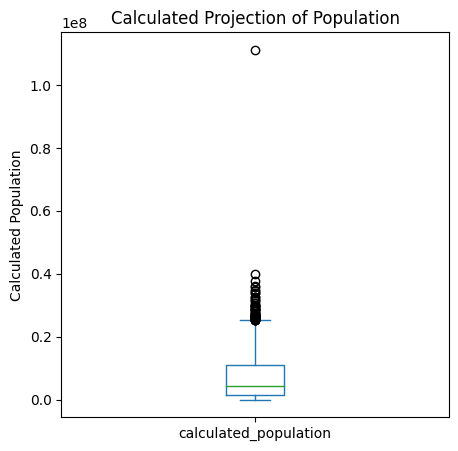

In [96]:
plt.figure(figsize=(5, 5))
df['calculated_population'].plot(kind='box')
plt.ylabel('Calculated Population')
plt.title('Calculated Projection of Population')
plt.show()

As we can see from this boxplot, there are several megacities that skew the distribution, however those cities are in their own grouping and there doesn't appear to be a single city outpacing every other. This distribution seems reasonable.

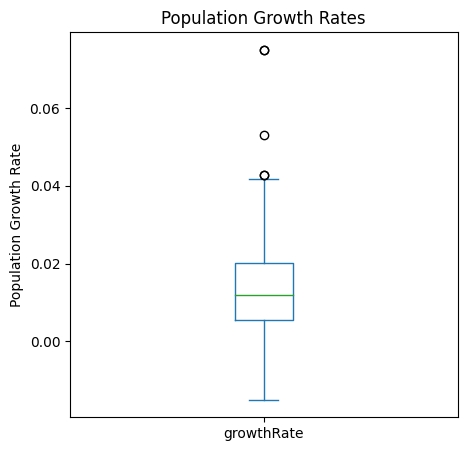

In [97]:
plt.figure(figsize=(5, 5))
df['growthRate'].plot(kind='box')
plt.ylabel('Population Growth Rate')
plt.title('Population Growth Rates')
plt.show()

These two plots don't tell us a lot, I'll calculate the density of each city and then evaluate the feature for outliers.

### Calculation of City Density

The purpose of this subsection was to generate the necessary values that would be used to calculate the density of each city in our dataset. Within this sub-section, I'll generate this feature and evaluate it for outliers.

In [98]:
df['area_km'] = df['area_km'].str.replace(',', '').astype(float)

In [99]:
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [100]:
df.sort_values(by= 'city_density',ascending = False).head(50)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
154,TR,Bursa,1997,2014,0.0,39.000000,0.160256,6.250000,0.000000,32.750000,...,Asia,Western Asia,10.82,40.1833,29.0500,2901396.0,0.0154,14,2.342539e+06,216500.807365
873,IN,Delhi,2019,2025,0.0,61.700000,0.361426,22.300000,39.400000,0.000000,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.0273,-2,3.400956e+07,48585.081879
853,IN,Delhi,2019,2025,0.0,42.300000,0.347518,14.700000,27.600000,0.000000,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.0273,-2,3.400956e+07,48585.081879
333,IN,Delhi,2015,2019,0.0,29.700000,0.000000,0.000000,29.700000,0.000000,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.0273,3,2.972450e+07,42463.569511
904,IN,Delhi,2012,2020,0.0,160.600000,0.330012,53.000000,0.000000,107.600000,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.0273,4,2.893458e+07,41335.120716
1619,CR,San Jose,2024,2025,0.0,84.000000,0.000000,0.000000,0.000000,84.000000,...,Americas,Latin America and the Caribbean,44.62,9.9325,-84.0800,1543000.0,0.0143,-5,1.656525e+06,37125.173123
882,BD,Dhaka,2020,2028,0.0,19.600000,0.714286,14.000000,5.600000,0.000000,...,Asia,Southern Asia,619.00,23.7639,90.3889,18627000.0,0.0325,-4,2.116914e+07,34198.929102
897,BD,Dhaka,2020,2026,0.0,31.200000,0.637821,19.900000,11.300000,0.000000,...,Asia,Southern Asia,619.00,23.7639,90.3889,18627000.0,0.0325,-3,2.050280e+07,33122.449493
1142,UK,Birmingham,2024,2026,0.0,16.500000,0.000000,0.000000,0.000000,16.500000,...,Europe,Northern Europe,103.00,52.4800,-1.9025,2919600.0,0.0074,-5,3.029236e+06,29410.056774
1616,US,Washington,2023,2026,0.0,3.000386,0.000000,0.000000,0.000000,3.000386,...,Americas,Northern America,177.00,38.9047,-77.0163,4810669.0,0.0150,-5,5.182457e+06,29279.416733


With the city density column calculated, we can now look at the generated feature to see if any values don't make sense in the given context. By sorting the values by highest to lowest, we can see that Bursa, Turkey is far and away the most dense city. This doesn't seem correct, at least at this magnitude of difference. 

Let's check it.

In [101]:
df[df['city'] == 'Bursa']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
154,TR,Bursa,1997,2014,0.0,39.0,0.160256,6.25,0.0,32.75,...,Asia,Western Asia,10.82,40.1833,29.05,2901396.0,0.0154,14,2.342539e+06,216500.807365


The area_km is very small and appears to be a mis-print. A government source states the land area for Bursa to be 10,422 square km, I'll correct this value.

In [102]:
df.loc[(df['city']=='Bursa'), 'area_km'] = 10422

In [103]:
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [104]:
distinct_cities = df.sort_values(by='city_density', ascending=False).drop_duplicates(subset='city')

In [105]:
distinct_cities[['city','area_km','city_density']].head(15)

,city,area_km,city_density
853,Delhi,700.00,48585.081879
1619,San Jose,44.62,37125.173123
882,Dhaka,619.00,34198.929102
1142,Birmingham,103.00,29410.056774
1616,Washington,177.00,29279.416733
1251,Nagoya,326.40,28239.147369
363,Mumbai,976.00,26835.026182
320,Hong Kong,290.00,26676.597804
1582,Taipei,376.00,24986.765157
1646,Manchester,115.60,23227.768492


The most dense cities mostly appear to be as expected, however there are a few cities that stand out. One source of error would be a misprinted value for the city area which would cause the density to be much higher than expected. I'll take a subset of the dataframe for area_km < 500 and check those values.

In [106]:
distinct_cities[distinct_cities['area_km'] < 200][['city','area_km','population','city_density']]

,city,area_km,population,city_density
1619,San Jose,44.62,1543000.0,37125.173123
1142,Birmingham,103.00,2919600.0,29410.056774
1616,Washington,177.00,4810669.0,29279.416733
1646,Manchester,115.60,2705000.0,23227.768492
382,Santo Domingo,104.44,2581827.0,22054.833583
...,...,...,...,...
1673,Ulm,118.69,126949.0,1044.630781
1636,Aubagne,54.90,47535.0,838.816681
927,Croydon,86.52,192064.0,486.129201
1076,Pisa,185.09,90118.0,481.280277


Washington, DC stands out as an error. The city proper is about 177 square km, but the population for city proper is only ~700,000. I'll adjust the area to account for the DC metro area, since that's the population that was used for all other cities in the dataset.

In [107]:
df.loc[df['city'] == 'Washington', 'area_km'] = 10360

Bilbao also appears to be a misprint, as the area used would be for the municipality and the population matches with the greater region population. I'll update the population to be the Municipality population

In [108]:
df.loc[df['city'] == 'Bilbao', 'population'] = 375000

Similar for Panama City, although the values are reasonable. 

In [109]:
df.loc[df['city'] == 'Panama City', 'area_km'] = 275

The remaining values in the above list appear to be within reason. Let's recalculate the density values and re-asses.

In [110]:
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [111]:
distinct_cities = df.sort_values(by='city_density', ascending=False).drop_duplicates(subset='city')

In [112]:
distinct_cities[['city','area_km','population','city_density']]

,city,area_km,population,city_density
873,Delhi,700.00,32226000.0,48585.081879
1619,San Jose,44.62,1543000.0,37125.173123
882,Dhaka,619.00,18627000.0,34198.929102
1142,Birmingham,103.00,2919600.0,29410.056774
1251,Nagoya,326.40,9197000.0,28239.147369
...,...,...,...,...
1401,Newcastle,NaN,152984.0,NaN
1567,Brno,NaN,382405.0,NaN
1609,Waterloo,NaN,104986.0,NaN
1610,Norrköping,NaN,NaN,NaN


The values for Ahmanabad are erroneous. It appears I misprinted the values for Ahmadabad, Pakistan instead of India. I'll correct this.

In [113]:
df.loc[df['city'] == 'Ahmadabad', 'area_km'] = 505
df.loc[df['city'] == 'Ahmadabad', 'population'] = 8650605
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [114]:
df.sort_values(by='city_density',ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
873,IN,Delhi,2019,2025,0.0,61.7,0.361426,22.3,39.4,0.0,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.02730,-2,3.400956e+07,48585.081879
853,IN,Delhi,2019,2025,0.0,42.3,0.347518,14.7,27.6,0.0,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.02730,-2,3.400956e+07,48585.081879
333,IN,Delhi,2015,2019,0.0,29.7,0.000000,0.0,29.7,0.0,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.02730,3,2.972450e+07,42463.569511
904,IN,Delhi,2012,2020,0.0,160.6,0.330012,53.0,0.0,107.6,...,Asia,Southern Asia,700.00,28.6100,77.2300,32226000.0,0.02730,4,2.893458e+07,41335.120716
1619,CR,San Jose,2024,2025,0.0,84.0,0.000000,0.0,0.0,84.0,...,Americas,Latin America and the Caribbean,44.62,9.9325,-84.0800,1543000.0,0.01430,-5,1.656525e+06,37125.173123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,CA,Waterloo,2014,2019,0.0,19.0,0.000000,0.0,0.0,19.0,...,Americas,Northern America,NaN,43.4667,-80.5167,104986.0,0.00141,3,1.045432e+05,NaN
1610,SE,Norrköping,2007,2010,1.0,4.0,0.000000,0.0,0.0,4.0,...,Europe,Northern Europe,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN
1627,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,Africa,Sub-Saharan Africa,NaN,5.3167,-4.0333,4980000.0,0.02500,-6,5.775273e+06,NaN
1628,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,Africa,Sub-Saharan Africa,NaN,5.3170,-4.0330,6300000.0,NaN,-6,NaN,NaN


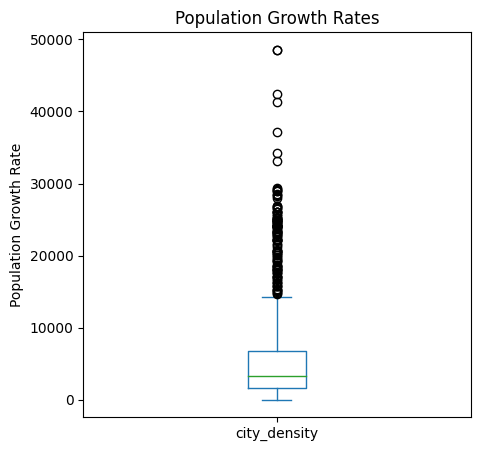

In [115]:
plt.figure(figsize=(5, 5))
df['city_density'].plot(kind='box')
plt.ylabel('Population Growth Rate')
plt.title('Population Growth Rates')
plt.show()

In [116]:
distinct_cities = df.sort_values(by='city_density', ascending=False).drop_duplicates(subset='city')
distinct_cities[['city','area_km','population','city_density']].head(5)

,city,area_km,population,city_density
873,Delhi,700.00,32226000.0,48585.081879
1619,San Jose,44.62,1543000.0,37125.173123
882,Dhaka,619.00,18627000.0,34198.929102
1142,Birmingham,103.00,2919600.0,29410.056774
1251,Nagoya,326.40,9197000.0,28239.147369


The bottom few values may be erroneous, but still within reason. I'll spot check these values.

##### Bursa

For Bursa, Turkey, the value used for both population and land area vary widely between city and metro areas. The stated values in the dataset are for the municipality density, rather than the metro density.

In [117]:
df.loc[df['city'] =='Bursa', 'area_km'] = 1290
df.loc[df['city'] =='Bursa', 'population'] = 1999998

#### Beijing

This value doesn't appear to be right. On wikipedia, the urban/municipal/metro densities are all around the same value. I'll use the metro area since that is the same area we've been using in other corrections.

In [118]:
df.loc[df['city'] =='Beijing', 'area_km'] = 12796.5
df.loc[df['city'] =='Beijing', 'population'] = 22366547

In [119]:
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [120]:
df.sort_values(by='city_density', ascending=False).head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
873,IN,Delhi,2019,2025,0.0,61.7,0.361426,22.3,39.4,0.0,...,Asia,Southern Asia,700.00,28.6100,77.23,32226000.0,0.0273,-2,3.400956e+07,48585.081879
853,IN,Delhi,2019,2025,0.0,42.3,0.347518,14.7,27.6,0.0,...,Asia,Southern Asia,700.00,28.6100,77.23,32226000.0,0.0273,-2,3.400956e+07,48585.081879
333,IN,Delhi,2015,2019,0.0,29.7,0.000000,0.0,29.7,0.0,...,Asia,Southern Asia,700.00,28.6100,77.23,32226000.0,0.0273,3,2.972450e+07,42463.569511
904,IN,Delhi,2012,2020,0.0,160.6,0.330012,53.0,0.0,107.6,...,Asia,Southern Asia,700.00,28.6100,77.23,32226000.0,0.0273,4,2.893458e+07,41335.120716
1619,CR,San Jose,2024,2025,0.0,84.0,0.000000,0.0,0.0,84.0,...,Americas,Latin America and the Caribbean,44.62,9.9325,-84.08,1543000.0,0.0143,-5,1.656525e+06,37125.173123


The remaining values appear to be within reason. It's important to note that these values, before being modelled, will be normalized into a scale of values between 0 and 1. I'm less worried about the absolute accuracy of the values and more worried about the accuracy of one value in relation to the rest of the values.

Before proceeding to the next step, I'd like to address any missing values that showed up in previous printouts.

In [121]:
len(df[df['population'].isna()])

2

In [122]:
df[df['population'].isna()].sort_values(by='country')['city'].drop_duplicates().tolist()

['Norrköping', 'Montreal']

From this check, we've identified two data points that are missing. Since there are only two, I'll address them manually.

In [123]:
df[df['city']== 'Norrköping']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
1610,SE,Norrköping,2007,2010,1.0,4.0,0.0,0.0,0.0,4.0,...,Europe,Northern Europe,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN


In [124]:
df.loc[df['city'] =='Norrköping', 'area_km'] = 35.68
df.loc[df['city'] =='Norrköping', 'lat'] = 58.5877
df.loc[df['city'] =='Norrköping', 'lng'] = 16.1924
df.loc[df['city'] =='Norrköping', 'population'] = 137326
df.loc[df['city'] =='Norrköping', 'growthRate'] = .0057

In [125]:
df.loc[df['city'] =='Montreal', 'area_km'] = 365.13
df.loc[df['city'] =='Montreal', 'lat'] = 45.5019
df.loc[df['city'] =='Montreal', 'lng'] = 73.5674
df.loc[df['city'] =='Montreal', 'population'] = 1780000
df.loc[df['city'] =='Montreal', 'growthRate'] = .0069

In [126]:
df[df['city']== 'Norrköping']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
1610,SE,Norrköping,2007,2010,1.0,4.0,0.0,0.0,0.0,4.0,...,Europe,Northern Europe,35.68,58.5877,16.1924,137326.0,0.0057,11,NaN,NaN


Now let's check the missing values for the growthRate feature

In [127]:
len(df[df['growthRate'].isna()])

20

In [128]:
df[df['growthRate'].isna()].sort_values(by='city')['city'].drop_duplicates()

1628      Abidjan
1568         Brno
1401    Newcastle
647      Santiago
1034     Valencia
Name: city, dtype: object

There are 5 city names that are responsbile for 20 missing values. I'll address these manually.

In [129]:
df[df['city']== 'Santiago']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
647,CL,Santiago,2021,2026,0.0,24.800000,1.00,24.800,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,-4,NaN,NaN
660,CL,Santiago,2013,2019,0.0,37.000000,1.00,37.000,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,4,NaN,NaN
1041,DO,Santiago,2022,2024,0.0,14.402527,0.00,0.000,14.402527,0.000000,...,Americas,Latin America and the Caribbean,NaN,19.4572,-70.6889,1343423.0,0.0067,-3,1.370607e+06,NaN
1084,CL,Santiago,2002,2005,0.0,24.700000,0.48,11.856,7.563898,5.280102,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,16,NaN,NaN
1087,CL,Santiago,2007,2011,0.0,13.800000,0.75,10.350,3.450000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,11,NaN,NaN
1471,CL,Santiago,2023,2027,0.0,24.800000,1.00,24.800,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,-5,NaN,NaN
1474,CL,Santiago,2001,2004,0.0,1.600000,1.00,1.600,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,17,NaN,NaN
1475,CL,Santiago,2001,2004,0.0,1.900000,1.00,1.900,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,17,NaN,NaN
1476,CL,Santiago,2002,2004,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,17,NaN,NaN
1477,CL,Santiago,1997,2000,0.0,2.700000,1.00,2.700,0.000000,0.000000,...,Americas,Latin America and the Caribbean,1147.0,-33.4372,-70.6506,7171000.0,NaN,21,NaN,NaN


In [130]:
df.loc[df['city'] =='Abidjan', 'area_km'] = 422
df.loc[df['city'] =='Abidjan', 'growthRate'] = .0309
df.loc[df['city'] =='Brno', 'area_km'] = 230.19
df.loc[df['city'] =='Brno', 'growthRate'] = .0026
df.loc[df['city'] =='Newcastle', 'area_km'] = 261.8
df.loc[df['city'] =='Newcastle', 'growthRate'] = .009

In [131]:
df.loc[(df['city'] =='Santiago') & (df['country'] =='CL'), 'growthRate'] = .0067
df.loc[(df['city'] =='Santiago') & (df['country'] =='DO'), 'area_km'] = .641

In [132]:
df.loc[(df['city'] =='Valencia') & (df['country'] =='ES'), 'area_km'] = 134.7
df.loc[(df['city'] =='Valencia') & (df['country'] =='ES'), 'growthRate'] = .0018

In [133]:
df.loc[(df['city'] =='Valencia') & (df['country'] =='VE'), 'area_km'] = 623
df.loc[(df['city'] =='Valencia') & (df['country'] =='VE'), 'growthRate'] = .01

Now for the 'area_km' feature

In [134]:
df[df['area_km'].isna()].sort_values(by='country')['city'].drop_duplicates().tolist()

['Liege', 'Maceio', 'Waterloo']

In [135]:
df.loc[df['city'] =='Liege', 'area_km'] = 68.25
df.loc[df['city'] =='Maceio', 'area_km'] = 511
df.loc[df['city'] =='Waterloo', 'area_km'] = 64.06

Now we can calculate the population and the density for the project year for the previously missing values.

In [136]:
df['calculated_population'] = df['population'] / (1 + df['growthRate'])**df['time_diff']
df['city_density'] = (df['calculated_population'])/(df['area_km'])

In [137]:
df[df['calculated_population'].isna()].sort_values(by='country')['city'].drop_duplicates().tolist()

[]

In [138]:
df[df['city_density'].isna()].sort_values(by='country')['city'].drop_duplicates().tolist()

[]

### Country Level Poverty Index

The ability of a country to build a transit project is largely dependent on their ability to pay for it. Often times less prosperous countries will have to take on loans to pay for large public works projects, in ways that other countries might not.

Additionally, transit may not be the top priority in countries where poverty is a common issue. The government may choose to spend their money in other ways before they priorize transit.

To build this feature, we'll use the Poverty Dataset from "Our World in Data" that provides several important indicators of how prevalent poverty is in a country.

In [139]:
df_poverty = pd.read_csv('Data/CityPopDen/data/poverty_index.csv')

In [140]:
df_poverty

,Entity,Year,Share below $6.85 a day,p90_p10_ratio,p90_p50_ratio,reporting_gdp
0,Albania,1996.0,47.879143,3.562162,1.888252,1633.551572
1,Albania,2002.0,52.090966,3.982906,2.089686,2247.497491
2,Albania,2005.0,40.428427,3.869674,1.979487,2675.507936
3,Albania,2008.0,33.431851,3.573913,1.957143,3298.478044
4,Albania,2012.0,36.667752,3.628118,1.941748,3736.339101
...,...,...,...,...,...,...
2413,China - urban,2015.0,22.368809,5.196755,2.267257,8016.431435
2414,China - urban,2016.0,20.123164,5.238462,2.289076,8516.513699
2415,China - urban,2017.0,19.488525,5.451429,2.334421,9053.212733
2416,China - urban,2018.0,18.048384,5.561694,2.352025,9619.192484


In [141]:
df_codes = df_codes[['name','alpha-2']]
df_codes.rename(columns = {'name':'entity','alpha-2':'country'},inplace= True)

In [142]:
df_poverty.rename(columns = {'Entity':'entity','Year':'year'},inplace = True)
df_poverty = pd.merge(df_poverty,df_codes, on =['entity'],how = 'left')

In [143]:
df_poverty

,entity,year,Share below $6.85 a day,p90_p10_ratio,p90_p50_ratio,reporting_gdp,country
0,Albania,1996.0,47.879143,3.562162,1.888252,1633.551572,AL
1,Albania,2002.0,52.090966,3.982906,2.089686,2247.497491,AL
2,Albania,2005.0,40.428427,3.869674,1.979487,2675.507936,AL
3,Albania,2008.0,33.431851,3.573913,1.957143,3298.478044,AL
4,Albania,2012.0,36.667752,3.628118,1.941748,3736.339101,AL
...,...,...,...,...,...,...,...
2415,China - urban,2015.0,22.368809,5.196755,2.267257,8016.431435,NaN
2416,China - urban,2016.0,20.123164,5.238462,2.289076,8516.513699,NaN
2417,China - urban,2017.0,19.488525,5.451429,2.334421,9053.212733,NaN
2418,China - urban,2018.0,18.048384,5.561694,2.352025,9619.192484,NaN


In [144]:
df_poverty.drop(columns = ['p90_p10_ratio','p90_p50_ratio'],inplace = True)
df_poverty.rename(columns = {'Share below $6.85 a day':'per_below_line'},inplace= True)

##### Handling Regional 'country' Abbreviations

Within the dataset, the authors provided the above data for larger regions, which will be useful for filling missing values within individual countries.

To use these regions, I'll need to assign them a 2-digit country abbreviation.

In [145]:
df_poverty.head(5)

,entity,year,per_below_line,reporting_gdp,country
0,Albania,1996.0,47.879143,1633.551572,AL
1,Albania,2002.0,52.090966,2247.497491,AL
2,Albania,2005.0,40.428427,2675.507936,AL
3,Albania,2008.0,33.431851,3298.478044,AL
4,Albania,2012.0,36.667752,3736.339101,AL


In [146]:
df_poverty[df_poverty['entity']=='Central African Republic']

,entity,year,per_below_line,reporting_gdp,country
360,Central African Republic,1992.0,96.744934,469.433644,CF
361,Central African Republic,2008.0,92.769471,480.410900,CF
2176,Central African Republic,1992.0,96.744934,469.433644,CF
2177,Central African Republic,2008.0,92.769471,480.410900,CF


In [147]:
df_poverty.loc[df_poverty['entity'] == 'East Asia and Pacific', 'country'] = 'EAP'
df_poverty.loc[df_poverty['entity'] == 'Europe and Central Asia', 'country'] = 'ECA'
df_poverty.loc[df_poverty['entity'] == 'High income countries', 'country'] = 'HIC'
df_poverty.loc[df_poverty['entity'] == 'India - rural', 'country'] = 'IN-R'
df_poverty.loc[df_poverty['entity'] == 'India - urban', 'country'] = 'IN-U'
df_poverty.loc[df_poverty['entity'] == 'Latin America and the Caribbean', 'country'] = 'LAC'
df_poverty.loc[df_poverty['entity'] == 'Middle East and North Africa', 'country'] = 'MENA'
df_poverty.loc[df_poverty['entity'] == 'China - rural', 'country'] = 'CN-R'
df_poverty.loc[df_poverty['entity'] == 'China - urban', 'country'] = 'CN-U'

#### Merging poverty data into df

Looking at the poverty data, I'm anticipating that there will be many missing values. This is because the year columns in both the poverty dataset and the main dataframe (df) are inconsistent and often skip years.

To combat this, I'll be rounding the year columns of both datasets to the nearest decade in the hopes that this captures enough of the change in poverty over time, but also fulfills the majority of the missing data that would be created otherwise.

In [148]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,region,sub_region,area_km,lat,lng,population,growthRate,time_diff,calculated_population,city_density
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,Asia,Eastern Asia,290.0,22.300,114.2000,7450000.0,0.0054,17,6.798221e+06,23442.142396
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,Europe,Western Europe,984.0,52.520,13.4050,4473101.0,0.0009,49,4.280209e+06,4349.805446
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,Asia,Eastern Asia,12796.5,39.904,116.4075,22366547.0,0.0203,10,1.829448e+07,1429.647188
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,Asia,Eastern Asia,12796.5,39.904,116.4075,22366547.0,0.0203,0,2.236655e+07,1747.864416
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,Europe,Western Europe,954.0,45.760,4.8400,522969.0,0.0078,14,4.690671e+05,491.684610


In [149]:
df['rounded_year'] = (df['year'] / 10).round() * 10
df_poverty['rounded_year'] = (df_poverty['year'] / 10).round() * 10

In [150]:
df_poverty

,entity,year,per_below_line,reporting_gdp,country,rounded_year
0,Albania,1996.0,47.879143,1633.551572,AL,2000.0
1,Albania,2002.0,52.090966,2247.497491,AL,2000.0
2,Albania,2005.0,40.428427,2675.507936,AL,2000.0
3,Albania,2008.0,33.431851,3298.478044,AL,2010.0
4,Albania,2012.0,36.667752,3736.339101,AL,2010.0
...,...,...,...,...,...,...
2415,China - urban,2015.0,22.368809,8016.431435,CN-U,2020.0
2416,China - urban,2016.0,20.123164,8516.513699,CN-U,2020.0
2417,China - urban,2017.0,19.488525,9053.212733,CN-U,2020.0
2418,China - urban,2018.0,18.048384,9619.192484,CN-U,2020.0


In [151]:
df_poverty.drop_duplicates(subset=['entity','rounded_year'],inplace = True)

In [152]:
df = pd.merge(df,df_poverty, on = ['country','rounded_year'],how ='left')
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,population,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,7450000.0,0.0054,17,6.798221e+06,23442.142396,2000.0,NaN,NaN,NaN,NaN
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,4473101.0,0.0009,49,4.280209e+06,4349.805446,1970.0,NaN,NaN,NaN,NaN
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,22366547.0,0.0203,10,1.829448e+07,1429.647188,2010.0,China,2008.0,69.489729,4711.635127
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,22366547.0,0.0203,0,2.236655e+07,1747.864416,2020.0,China,2015.0,37.855836,8016.431435
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,522969.0,0.0078,14,4.690671e+05,491.684610,2010.0,France,2006.0,0.207014,35811.343790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,688711.0,0.0014,-5,6.935455e+05,4904.847911,2020.0,Spain,2015.0,3.466943,25732.018360
1680,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,383200.0,0.0025,-2,3.851184e+05,1305.486085,2020.0,NaN,NaN,NaN,NaN
1681,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,381488.0,0.0107,-5,4.023391e+05,494.152631,2020.0,Australia,2016.0,0.989104,57527.177030
1682,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,2529403.0,0.0085,-5,2.638746e+06,6907.711312,2020.0,Colombia,2015.0,34.596413,6175.876030


In [153]:
missing = df[df['per_below_line'].isna()]

In [154]:
missing[missing['country'] =='SG']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,population,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp
697,SG,Singapore,2017,2025,0.0,4.000000,1.0,4.0,0.000000,0.0,...,5983000.0,0.0068,-1,6.023684e+06,11517.560994,2020.0,NaN,NaN,NaN,NaN
838,SG,Singapore,2002,2012,0.0,35.500000,1.0,35.5,0.000000,0.0,...,5983000.0,0.0068,13,5.478445e+06,10475.038421,2010.0,NaN,NaN,NaN,NaN
907,SG,Singapore,2008,2017,0.0,41.900000,1.0,41.9,0.000000,0.0,...,5983000.0,0.0068,7,5.705800e+06,10909.751686,2010.0,NaN,NaN,NaN,NaN
909,SG,Singapore,2014,2024,0.0,43.000000,1.0,43.0,0.000000,0.0,...,5983000.0,0.0068,1,5.942590e+06,11362.505517,2020.0,NaN,NaN,NaN,NaN
1059,SG,Singapore,2003,2007,0.0,2.027841,0.0,0.0,2.027841,0.0,...,5983000.0,0.0068,15,5.404691e+06,10334.017932,2000.0,NaN,NaN,NaN,NaN
1077,SG,Singapore,2008,2013,0.0,4.300000,1.0,4.3,0.000000,0.0,...,5983000.0,0.0068,9,5.628986e+06,10762.878858,2010.0,NaN,NaN,NaN,NaN
1512,SG,Singapore,2000,2005,0.0,10.300000,0.0,0.0,10.300000,0.0,...,5983000.0,0.0068,17,5.331931e+06,10194.895936,2000.0,NaN,NaN,NaN,NaN
1513,SG,Singapore,2022,2023,0.0,0.700000,0.0,0.0,0.700000,0.0,...,5983000.0,0.0068,-3,6.105885e+06,11674.732396,2020.0,NaN,NaN,NaN,NaN
1514,SG,Singapore,2027,2029,0.0,1.500000,0.0,0.0,1.500000,0.0,...,5983000.0,0.0068,-8,6.316328e+06,12077.108528,2030.0,NaN,NaN,NaN,NaN
1515,SG,Singapore,2023,2025,0.0,3.600000,0.0,0.0,3.600000,0.0,...,5983000.0,0.0068,-4,6.147405e+06,11754.120576,2020.0,NaN,NaN,NaN,NaN


In [155]:
missing['per_below_line'].isna().sum()

150

After rounding the year values to the nearest decade, we are  left with 271 missing values. This is a reasonable number to manage, as many of them may just be the result of clerical changes over time (country names changed, territories mismatching, etc.). For instance, 14 of the values are the result of the China-Hong Kong issue.

In [156]:
missing[:5]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,population,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp
0,HK,Hong Kong,2000,2005,0.0,1.3,0.000000,0.0,1.3,0.0,...,7450000.0,0.0054,17,6.798221e+06,23442.142396,2000.0,NaN,NaN,NaN,NaN
1,DE,Berlin,1968,1974,0.0,1.5,1.000000,1.5,0.0,0.0,...,4473101.0,0.0009,49,4.280209e+06,4349.805446,1970.0,NaN,NaN,NaN,NaN
30,CN,Beijing,1965,1969,0.0,23.6,1.000000,23.6,0.0,0.0,...,22366547.0,0.0203,53,7.709407e+06,602.462124,1970.0,NaN,NaN,NaN,NaN
50,DE,Munich,1965,1971,1.0,11.4,0.359649,4.1,0.0,7.3,...,2606021.0,0.0066,52,1.851048e+06,3573.452356,1970.0,NaN,NaN,NaN,NaN
55,DE,Berlin,1978,1984,0.0,4.9,1.000000,4.9,0.0,0.0,...,4473101.0,0.0009,39,4.318887e+06,4389.112627,1980.0,NaN,NaN,NaN,NaN


#### Hong Kong

Since we won't be able to find direct data for Hong Kong during this time period, we'll have to use China as a proxy. The Hong Kong data will be filled with China data for the same time period, but we'll be using the urban china data, as I expect that Hong Kong would have matched Urban Chinese cities more closesly than rural Chinese cities.

In [157]:
df['merge_country'] = df['country']
df_poverty['merge_country'] = df_poverty['country']
df.loc[df['country'] == 'HK', 'merge_country'] = 'CN-U'

In [158]:
df_poverty.drop(columns = ['entity','year','country'],inplace = True)

In [159]:
df[(df['country'] =='HK') & (df['merge_country'] =='CN-U')].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
0,HK,Hong Kong,2000,2005,0.0,1.3,0.00,0.000,1.3,0.000,...,0.0054,17,6.798221e+06,23442.142396,2000.0,NaN,NaN,NaN,NaN,CN-U
68,HK,Hong Kong,2001,2005,0.0,3.5,0.25,0.875,0.0,2.625,...,0.0054,17,6.798221e+06,23442.142396,2000.0,NaN,NaN,NaN,NaN,CN-U
80,HK,Hong Kong,1986,1989,0.0,4.6,1.00,4.600,0.0,0.000,...,0.0054,32,6.270643e+06,21622.907293,1990.0,NaN,NaN,NaN,NaN,CN-U
101,HK,Hong Kong,1997,2001,0.0,2.1,1.00,2.100,0.0,0.000,...,0.0054,21,6.653341e+06,22942.554715,2000.0,NaN,NaN,NaN,NaN,CN-U
146,HK,Hong Kong,2005,2009,0.0,1.8,1.00,1.800,0.0,0.000,...,0.0054,13,6.946257e+06,23952.608894,2010.0,NaN,NaN,NaN,NaN,CN-U


In [160]:
df_poverty[df_poverty['merge_country'] =='CN-U']

,per_below_line,reporting_gdp,rounded_year,merge_country
2400,99.922875,447.118997,1980.0,CN-U
2402,99.471305,786.863492,1990.0,CN-U
2405,91.142996,1653.430868,2000.0,CN-U
2409,46.826807,4711.635127,2010.0,CN-U
2415,22.368809,8016.431435,2020.0,CN-U


In [161]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')

This approach creates duplicate columns, which we then need to combine and then drop the duplicate columns

In [162]:
df.shape

(1684, 47)

In [163]:
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [164]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

and then rename the columns back to their original name.

In [165]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [166]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,0.0054,17,6.798221e+06,23442.142396,2000.0,NaN,NaN,91.142996,1653.430868,CN-U
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,0.0009,49,4.280209e+06,4349.805446,1970.0,NaN,NaN,NaN,NaN,DE
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,0.0203,10,1.829448e+07,1429.647188,2010.0,China,2008.0,69.489729,4711.635127,CN
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,0.0203,0,2.236655e+07,1747.864416,2020.0,China,2015.0,37.855836,8016.431435,CN
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,0.0078,14,4.690671e+05,491.684610,2010.0,France,2006.0,0.207014,35811.343790,FR


In [167]:
missing = df[df['per_below_line'].isna()]

In [168]:
missing.sort_values(by='country').head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
702,AE,Dubai,2016,2020,0.0,15.0,0.213333,3.2,10.8,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,NaN,NaN,AE
800,BH,Bahrain,2020,2025,1.0,72.7,0.000000,0.0,72.7,0.0,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,NaN,NaN,BH
358,BH,Bahrain,2018,2024,1.0,28.6,0.000000,0.0,28.6,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,NaN,NaN,BH
1628,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,0.0309,-6,7.562054e+06,17919.559774,2030.0,NaN,NaN,NaN,NaN,CI
1627,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,0.0309,-6,5.977624e+06,14164.985345,2030.0,NaN,NaN,NaN,NaN,CI


We'll repeat the a similar process as above until there are no longer any missing values.

### Middle East Region

There is a lack of information regarding poverty in the middle east. Specifically UAE, Bahrain, Qatar, and Saudi Arabia. As a proxy, the dataset has provided a region specific breakdown for these values called "Middle East and North Africa" (MENA), which would include the countries listed above.

In [169]:
df_poverty[df_poverty['merge_country'] == 'MENA']

,per_below_line,reporting_gdp,rounded_year,merge_country
2322,61.822038,NaN,1990.0,MENA
2327,64.565649,NaN,2000.0,MENA
2337,50.161435,NaN,2010.0,MENA
2346,43.486984,NaN,2020.0,MENA


##### UAE (Dubai)

In [170]:
df.loc[df['country'] == 'AE', 'merge_country'] = 'MENA'

In [171]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [172]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [173]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [174]:
df[df['merge_country'] == 'MENA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
702,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,43.486984,NaN,MENA
774,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,35495.76527,MENA
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,35495.76527,MENA
1641,AE,Dubai,2006,2009,0.0,5.367346,0.000000,0.0,5.367346,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,35495.76527,MENA


Noticably, at index 866 the data indicate that the entire population is above the poverty line in the 2010 decade. This is likely incorrect, and, since we have data for 2020 and 2000, we'll approximate the 2010 data as best we can.

In [175]:
df.loc[(df['city']=='Dubai') & (df['start_year']==2006), 'per_below_line'] = (43.486984+64.565649)/2

We'll also need to add data for the reporting_gdp. Since the gdp per capita growth for the UAE looks to be appoximately $1000/capita/decade, this is the figure I'll use. based on [World Bank Data](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=ZQ)

In [176]:
df.loc[(df['city']=='Dubai') & (df['start_year']==2016), 'reporting_gdp'] = 34495.76527
df.loc[(df['city']=='Dubai') & (df['start_year']==2005), 'reporting_gdp'] = 36495.76527

##### Bahrain (Bahrain)

In [177]:
df.loc[df['country'] == 'BH', 'merge_country'] = 'MENA'

In [178]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [179]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [180]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [181]:
df[df['merge_country'] == 'MENA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
358,BH,Bahrain,2018,2024,1.0,28.600000,0.000000,0.0,28.600000,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,NaN,MENA
702,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,43.486984,34495.76527,MENA
774,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,54.026316,35495.76527,MENA
800,BH,Bahrain,2020,2025,1.0,72.700000,0.000000,0.0,72.700000,0.0,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,43.486984,NaN,MENA
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,36495.76527,MENA
1641,AE,Dubai,2006,2009,0.0,5.367346,0.000000,0.0,5.367346,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,54.026316,35495.76527,MENA


According to World Bank, the GDP/capita of Bahrain is $26,562.97 USD in 2023. Since I don't have projections of future GDP values, I'll use the current value.

In [182]:
df.loc[(df['city']=='Bahrain') & (df['start_year']==2018), 'reporting_gdp'] = 26562.97
df.loc[(df['city']=='Bahrain') & (df['start_year']==2020), 'reporting_gdp'] = 26562.97

#### Qatar (Doha)

In [183]:
df.loc[df['country'] == 'QA', 'merge_country'] = 'MENA'

In [184]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [185]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [186]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [187]:
df[df['merge_country'] == 'MENA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
358,BH,Bahrain,2018,2024,1.0,28.600000,0.000000,0.0,28.600000,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,26562.97000,MENA
702,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,43.486984,34495.76527,MENA
774,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,54.026316,35495.76527,MENA
800,BH,Bahrain,2020,2025,1.0,72.700000,0.000000,0.0,72.700000,0.0,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,43.486984,26562.97000,MENA
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,36495.76527,MENA
915,QA,Doha,2013,2026,0.0,124.000000,0.899194,111.5,6.000000,6.5,...,0.0250,0,1.186023e+06,8985.022727,2020.0,NaN,NaN,43.486984,NaN,MENA
1074,QA,Doha,2015,2017,0.0,7.200000,0.000000,0.0,5.800000,1.4,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,NaN,MENA
1204,QA,Doha,2013,2019,0.0,11.600000,1.000000,11.6,0.000000,0.0,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,NaN,MENA
1205,QA,Doha,2013,2019,0.0,7.000000,0.000000,0.0,7.000000,0.0,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,NaN,MENA
1206,QA,Doha,2015,2018,0.0,12.000000,1.000000,12.0,0.000000,0.0,...,0.0250,3,1.101340e+06,8343.486812,2020.0,NaN,NaN,43.486984,NaN,MENA


According to World Bank, the GDP/capita in 2023 was $66,838.36 USD

In [188]:
df.loc[(df['city']=='Doha') & (df['start_year']==2013), 'reporting_gdp'] = 66838.36

#### Kuwait (Kuwait City)

In [189]:
df.loc[df['country'] == 'KW', 'merge_country'] = 'MENA'

In [190]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [191]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [192]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [193]:
df[df['merge_country'] == 'MENA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
358,BH,Bahrain,2018,2024,1.0,28.600000,0.000000,0.0,28.600000,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,26562.97000,MENA
702,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,43.486984,34495.76527,MENA
774,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,54.026316,35495.76527,MENA
800,BH,Bahrain,2020,2025,1.0,72.700000,0.000000,0.0,72.700000,0.0,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,43.486984,26562.97000,MENA
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.0,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,36495.76527,MENA
910,KW,Kuwait City,2020,2025,0.0,160.000000,0.350000,56.0,104.000000,0.0,...,0.0183,-3,3.167732e+06,3683.409762,2020.0,NaN,NaN,43.486984,NaN,MENA
915,QA,Doha,2013,2026,0.0,124.000000,0.899194,111.5,6.000000,6.5,...,0.0250,0,1.186023e+06,8985.022727,2020.0,NaN,NaN,43.486984,66838.36000,MENA
1074,QA,Doha,2015,2017,0.0,7.200000,0.000000,0.0,5.800000,1.4,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,NaN,MENA
1204,QA,Doha,2013,2019,0.0,11.600000,1.000000,11.6,0.000000,0.0,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,66838.36000,MENA
1205,QA,Doha,2013,2019,0.0,7.000000,0.000000,0.0,7.000000,0.0,...,0.0250,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,66838.36000,MENA


According to World Bank, the GDP per capita for Kuwait is $24,300.33 USD in 2023

In [194]:
df.loc[(df['city']=='Kuwait City') & (df['start_year']==2020), 'reporting_gdp'] = 24300.33

#### Iran (Tehran)

In [195]:
df.loc[df['country'] == 'IR', 'merge_country'] = 'MENA'

In [196]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [197]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [198]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [199]:
df[df['merge_country'] == 'MENA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
358,BH,Bahrain,2018,2024,1.0,28.600000,0.000000,0.0,28.600000,0.00,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,26562.970000,MENA
376,IR,Tehran,2012,2014,0.0,12.000000,1.000000,12.0,0.000000,0.00,...,0.0126,7,1.296073e+07,7606.064420,2010.0,Iran,2006.0,24.711477,4772.028495,MENA
702,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.00,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,43.486984,34495.765270,MENA
724,IR,Tehran,2015,2019,0.0,31.000000,1.000000,31.0,0.000000,0.00,...,0.0126,3,1.362640e+07,7996.716351,2020.0,Iran,2015.0,21.850269,4933.311385,MENA
725,IR,Tehran,2015,2017,0.0,27.000000,1.000000,27.0,0.000000,0.00,...,0.0126,4,1.345685e+07,7897.211486,2020.0,Iran,2015.0,21.850269,4933.311385,MENA
774,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.00,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,54.026316,35495.765270,MENA
800,BH,Bahrain,2020,2025,1.0,72.700000,0.000000,0.0,72.700000,0.00,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,43.486984,26562.970000,MENA
804,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.00,...,0.0146,12,2.799568e+06,3931.978181,2010.0,United Arab Emirates,2013.0,0.000000,36495.765270,MENA
910,KW,Kuwait City,2020,2025,0.0,160.000000,0.350000,56.0,104.000000,0.00,...,0.0183,-3,3.167732e+06,3683.409762,2020.0,NaN,NaN,43.486984,24300.330000,MENA
915,QA,Doha,2013,2026,0.0,124.000000,0.899194,111.5,6.000000,6.50,...,0.0250,0,1.186023e+06,8985.022727,2020.0,NaN,NaN,43.486984,66838.360000,MENA


According to World Bank, the GDP per capita for Iran is $4,091.21 USD in 2023. For the remaining dates, I'll need to approximate using google's World Bank data viewer.

In [200]:
df.loc[(df['city']=='Tehran') & (df['start_year']==2012), 'reporting_gdp'] = 8235.65
df.loc[(df['city']=='Tehran') & (df['start_year']==2015), 'reporting_gdp'] = 4091.21
df.loc[(df['city']=='Tehran') & (df['end_year']==2019), 'reporting_gdp'] = 5000.75

#### Saudi Arabia (Riyadh, Jeddah, Ad Dammam, Mecca)

In [201]:
df.loc[df['country'] == 'SA', 'merge_country'] = 'MENA'

In [202]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [203]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [204]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [205]:
df[df['merge_country'] == 'MENA'].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
358,BH,Bahrain,2018,2024,1.0,28.6,0.000000,0.0,28.6,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,26562.97,MENA
376,IR,Tehran,2012,2014,0.0,12.0,1.000000,12.0,0.0,0.0,...,0.0126,7,1.296073e+07,7606.064420,2010.0,Iran,2006.0,24.711477,8235.65,MENA
551,SA,Riyadh,2015,2016,0.0,12.9,0.930233,12.0,0.9,0.0,...,0.0191,4,6.709519e+06,4010.471416,2020.0,NaN,NaN,43.486984,NaN,MENA
562,SA,Riyadh,2014,2020,0.0,29.6,0.000000,0.0,29.6,0.0,...,0.0191,3,6.837670e+06,4087.071420,2020.0,NaN,NaN,43.486984,NaN,MENA
675,SA,Riyadh,2014,2020,0.0,25.3,0.000000,0.0,25.3,0.0,...,0.0191,3,6.837670e+06,4087.071420,2020.0,NaN,NaN,43.486984,NaN,MENA


In 2014, the GDP per capita in Saudi Arabia was $23,543 USD according to world bank. Each project in our list was from approximately 2014, so I'll use this value.

In [206]:
df.loc[(df['city']=='Riyadh') & (df['end_year']==2016), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Riyadh') & (df['end_year']==2020), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Riyadh') & (df['end_year']==2020), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Riyadh') & (df['end_year']==2019), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Riyadh') & (df['end_year']==2017), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Riyadh') & (df['end_year']==2016), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Jeddah') & (df['end_year']==2025), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Ad Dammam') & (df['end_year']==2024), 'reporting_gdp'] = 23543
df.loc[(df['city']=='Mecca') & (df['end_year']==2019), 'reporting_gdp'] = 23543

#### Egypt (Cairo)

In [207]:
df.loc[df['country'] == 'EG', 'merge_country'] = 'MENA'

In [208]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [209]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [210]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [211]:
df[df['merge_country'] == 'MENA'].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
23,EG,Cairo,1982,1999,0.0,42.86,0.109659,4.7,0.0,38.16,...,0.0199,29,1.146147e+07,5702.223493,1990.0,Egypt,1986.6,80.875360,1657.985060,MENA
97,EG,Cairo,1987,2005,0.0,21.80,0.908257,19.8,2.0,0.00,...,0.0199,24,1.264819e+07,6292.629964,2000.0,Egypt,1995.0,81.840791,2216.948207,MENA
358,BH,Bahrain,2018,2024,1.0,28.60,0.000000,0.0,28.6,0.00,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,43.486984,26562.970000,MENA
376,IR,Tehran,2012,2014,0.0,12.00,1.000000,12.0,0.0,0.00,...,0.0126,7,1.296073e+07,7606.064420,2010.0,Iran,2006.0,24.711477,8235.650000,MENA
398,EG,Cairo,2019,2025,0.0,19.00,1.000000,19.0,0.0,0.00,...,0.0199,-2,2.111182e+07,10503.392149,2020.0,Egypt,2015.0,64.458012,3600.913793,MENA


There are two seperate time related issues with the Cairo data. One is from 1986 and the other is from 2025. I don't believe I'll be able to get better data for these line items as data from this region can be inconsistent.

To fill these data points, I'll use the other existing datapoints to interpolate the missing data.

In [212]:
df.loc[(df['city']=='Cairo') & (df['end_year']==1999), 'reporting_gdp'] = 2039.852078
df.loc[(df['city']=='Cairo') & (df['end_year']==2025), 'reporting_gdp'] = 3600.913793
df.loc[(df['city']=='Cairo') & (df['end_year']==2024), 'reporting_gdp'] = 3600.913793

In [213]:
df.loc[(df['city']=='Cairo') & (df['end_year']==1999), 'per_below_line'] = 70.3938696289062
df.loc[(df['city']=='Cairo') & (df['end_year']==2025), 'per_below_line'] = 72.6366458409828
df.loc[(df['city']=='Cairo') & (df['end_year']==2024), 'per_below_line'] = 72.6366458409828

#### Uzbekistan (Tashkent)

In [214]:
df.loc[df['country'] == 'UZ', 'merge_country'] = 'MENA'

In [215]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [216]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [217]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [218]:
df.loc[df['country'] == 'UZ']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
110,UZ,Tashkent,2017,2020,0.0,2.90,1.0,2.9,0.00,0.0,...,0.0115,1,2.542430e+06,4788.003869,2020.0,NaN,NaN,43.486984,NaN,MENA
129,UZ,Tashkent,2017,2020,0.0,6.94,0.0,0.0,6.94,0.0,...,0.0115,1,2.542430e+06,4788.003869,2020.0,NaN,NaN,43.486984,NaN,MENA


In [219]:
df.loc[(df['city']=='Tashkent') & (df['end_year']==2020), 'reporting_gdp'] = 1716

### Asian Region

Within this subsection I'll address the missing poverty data in the asian countries within my dataset.

Specifically Singapore, Japan, Korea, and Vietnam. It's likely that Singapore and Vietnam will be allocated to a region and Japan and Korea to another. Adjacent to this region are Russia & China, which I will include at the end.

#### Singapore

Poverty data out of Singapore before 2010 is difficult to come by. This is because Singapore has not established a national poverty line and does not report data in relation to international poverty metrics. Since 2 of the 3 projects are before this cutoff, i'll likely need to interpolate this data somehow.

In [220]:
df[df['country'] =='SG']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
697,SG,Singapore,2017,2025,0.0,4.000000,1.0,4.0,0.000000,0.0,...,0.0068,-1,6.023684e+06,11517.560994,2020.0,NaN,NaN,NaN,NaN,SG
838,SG,Singapore,2002,2012,0.0,35.500000,1.0,35.5,0.000000,0.0,...,0.0068,13,5.478445e+06,10475.038421,2010.0,NaN,NaN,NaN,NaN,SG
907,SG,Singapore,2008,2017,0.0,41.900000,1.0,41.9,0.000000,0.0,...,0.0068,7,5.705800e+06,10909.751686,2010.0,NaN,NaN,NaN,NaN,SG
909,SG,Singapore,2014,2024,0.0,43.000000,1.0,43.0,0.000000,0.0,...,0.0068,1,5.942590e+06,11362.505517,2020.0,NaN,NaN,NaN,NaN,SG
1059,SG,Singapore,2003,2007,0.0,2.027841,0.0,0.0,2.027841,0.0,...,0.0068,15,5.404691e+06,10334.017932,2000.0,NaN,NaN,NaN,NaN,SG
1077,SG,Singapore,2008,2013,0.0,4.300000,1.0,4.3,0.000000,0.0,...,0.0068,9,5.628986e+06,10762.878858,2010.0,NaN,NaN,NaN,NaN,SG
1512,SG,Singapore,2000,2005,0.0,10.300000,0.0,0.0,10.300000,0.0,...,0.0068,17,5.331931e+06,10194.895936,2000.0,NaN,NaN,NaN,NaN,SG
1513,SG,Singapore,2022,2023,0.0,0.700000,0.0,0.0,0.700000,0.0,...,0.0068,-3,6.105885e+06,11674.732396,2020.0,NaN,NaN,NaN,NaN,SG
1514,SG,Singapore,2027,2029,0.0,1.500000,0.0,0.0,1.500000,0.0,...,0.0068,-8,6.316328e+06,12077.108528,2030.0,NaN,NaN,NaN,NaN,SG
1515,SG,Singapore,2023,2025,0.0,3.600000,0.0,0.0,3.600000,0.0,...,0.0068,-4,6.147405e+06,11754.120576,2020.0,NaN,NaN,NaN,NaN,SG


World Bank lists Singapore in the top 10 countries in terms of GDP per capita as of 2022. Since I don't have a better proxy, I'll use the Poverty dataset's 'High income countries' denomination in place of direct data. This 'High income countries' category is supposed to be an index of the highest GDP countries in the world and I think would act as a reasonable proxy in place of actual data.

In [221]:
df.loc[df['country'] == 'SG', 'merge_country'] = 'HIC'

In [222]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [223]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [224]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [225]:
df[df['merge_country'] == 'HIC'].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
697,SG,Singapore,2017,2025,0.0,4.000000,1.0,4.0,0.000000,0.0,...,0.0068,-1,6.023684e+06,11517.560994,2020.0,NaN,NaN,1.709393,NaN,HIC
838,SG,Singapore,2002,2012,0.0,35.500000,1.0,35.5,0.000000,0.0,...,0.0068,13,5.478445e+06,10475.038421,2010.0,NaN,NaN,1.528690,NaN,HIC
907,SG,Singapore,2008,2017,0.0,41.900000,1.0,41.9,0.000000,0.0,...,0.0068,7,5.705800e+06,10909.751686,2010.0,NaN,NaN,1.528690,NaN,HIC
909,SG,Singapore,2014,2024,0.0,43.000000,1.0,43.0,0.000000,0.0,...,0.0068,1,5.942590e+06,11362.505517,2020.0,NaN,NaN,1.709393,NaN,HIC
1059,SG,Singapore,2003,2007,0.0,2.027841,0.0,0.0,2.027841,0.0,...,0.0068,15,5.404691e+06,10334.017932,2000.0,NaN,NaN,1.944834,NaN,HIC


To fill the reporting GDP, we can use World Bank values as Singapore readily provides those values to the public.

In [226]:
df.loc[(df['city']=='Singapore') & (df['end_year']==2012), 'reporting_gdp'] = 55154.0
df.loc[(df['city']=='Singapore') & (df['end_year']==2017), 'reporting_gdp'] = 56967.0
df.loc[(df['city']=='Singapore') & (df['end_year']>=2024)& (df['reporting_gdp'].isna()), 'reporting_gdp'] = 82807.6
df.loc[(df['city']=='Singapore') & (df['end_year']<=1990)& (df['reporting_gdp'].isna()), 'reporting_gdp'] = 82807.6

#### Vietnam

In [227]:
df[df['country'] =='VN']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
390,VN,Hanoi,2011,2020,0.0,11.5,0.739130,8.5,2.99,0.0,...,0.0367,4,7.139413e+06,22341.386565,2020.0,NaN,NaN,NaN,NaN,VN
601,VN,Hanoi,2010,2013,0.0,12.5,0.320000,4.0,8.50,0.0,...,0.0367,8,6.180878e+06,19341.837441,2010.0,NaN,NaN,NaN,NaN,VN
674,VN,Ho Chi Minh City,2025,2029,0.0,8.9,0.842697,7.5,1.40,0.0,...,0.0268,-7,1.821429e+07,8413.064885,2030.0,NaN,NaN,NaN,NaN,VN
700,VN,Ho Chi Minh City,2012,2021,0.0,19.7,0.131980,2.6,17.10,0.0,...,0.0268,3,1.398149e+07,6457.964278,2020.0,NaN,NaN,NaN,NaN,VN
738,VN,Ho Chi Minh City,2020,2028,0.0,11.3,0.823009,9.3,2.00,0.0,...,0.0268,-4,1.682498e+07,7771.353392,2020.0,NaN,NaN,NaN,NaN,VN


The dates associated with Vietnamese projects are all recent or in the future. The poverty dataset contains many values for Vietnam, but there is a cutoff at the Pandemic in 2020. I'll opt to fill these values using the poverty data's East Asia & Pacific region denomination.

In [228]:
df.loc[df['country'] == 'VN', 'merge_country'] = 'EAP'

In [229]:
df = pd.merge(df,df_poverty, on= ['merge_country','rounded_year'],how = 'left')
df['per_below_line_x'] = df['per_below_line_x'].combine_first(df['per_below_line_y'])
df['reporting_gdp_x'] = df['reporting_gdp_x'].combine_first(df['reporting_gdp_y'])

In [230]:
df.drop('per_below_line_y', axis=1, inplace=True)
df.drop('reporting_gdp_y', axis=1, inplace=True)

In [231]:
df.rename(columns={'per_below_line_x':'per_below_line','reporting_gdp_x':'reporting_gdp'},inplace = True)

In [232]:
df[df['merge_country'] == 'EAP'].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
390,VN,Hanoi,2011,2020,0.0,11.5,0.739130,8.5,2.99,0.0,...,0.0367,4,7.139413e+06,22341.386565,2020.0,NaN,NaN,43.567200,NaN,EAP
601,VN,Hanoi,2010,2013,0.0,12.5,0.320000,4.0,8.50,0.0,...,0.0367,8,6.180878e+06,19341.837441,2010.0,NaN,NaN,76.259893,NaN,EAP
674,VN,Ho Chi Minh City,2025,2029,0.0,8.9,0.842697,7.5,1.40,0.0,...,0.0268,-7,1.821429e+07,8413.064885,2030.0,NaN,NaN,NaN,NaN,EAP
700,VN,Ho Chi Minh City,2012,2021,0.0,19.7,0.131980,2.6,17.10,0.0,...,0.0268,3,1.398149e+07,6457.964278,2020.0,NaN,NaN,43.567200,NaN,EAP
738,VN,Ho Chi Minh City,2020,2028,0.0,11.3,0.823009,9.3,2.00,0.0,...,0.0268,-4,1.682498e+07,7771.353392,2020.0,NaN,NaN,43.567200,NaN,EAP


This denomination within the poverty data doesn't include values past 2020 and so I'll need to estimate the 2030 project values.

In [233]:
df.loc[(df['country']=='VN') & (df['end_year']==2020), 'reporting_gdp'] = 3756.49
df.loc[(df['country']=='VN') & (df['end_year']==2013), 'reporting_gdp'] = 3756.49
df.loc[(df['country']=='VN') & (df['end_year']==2029), 'reporting_gdp'] = 3756.49
df.loc[(df['country']=='VN') & (df['end_year']==2021), 'reporting_gdp'] = 3756.49
df.loc[(df['country']=='VN') & (df['end_year']==2026), 'reporting_gdp'] = 3756.49

df.loc[(df['city']=='VN') & (df['end_year']==2029), 'per_below_line'] = 43.5672

### Japan

In [234]:
df[df['country'] =='JP']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
56,JP,Tokyo,2008,2015,1.0,3.800000,0.000000,0.000,3.800000,0.0,...,0.010054,8,3.482997e+07,4980.690489,2010.0,Japan,2008.0,2.220306,33557.6454,JP
102,JP,Fukuoka,2014,2022,0.0,1.600000,1.000000,1.600,0.000000,0.0,...,-0.002200,2,2.296092e+06,4220.756784,2020.0,NaN,NaN,NaN,NaN,JP
126,JP,Osaka,2015,2023,1.0,2.400000,1.000000,2.400,0.000000,0.0,...,-0.002400,1,1.516239e+07,5020.658853,2020.0,NaN,NaN,NaN,NaN,JP
160,JP,Tokyo,1988,1995,0.0,12.000000,0.000000,0.000,12.000000,0.0,...,0.010054,28,2.851420e+07,4077.534997,1990.0,NaN,NaN,NaN,NaN,JP
181,JP,Osaka,2003,2009,1.0,3.800000,1.000000,3.800,0.000000,0.0,...,-0.002400,14,1.564350e+07,5179.966923,2010.0,Japan,2008.0,2.220306,33557.6454,JP
185,JP,Osaka,1999,2019,1.0,20.300000,1.000000,20.300,0.000000,0.0,...,-0.002400,11,1.553114e+07,5142.760599,2010.0,Japan,2008.0,2.220306,33557.6454,JP
186,JP,Osaka,2018,2029,0.0,8.900000,0.000000,0.000,8.900000,0.0,...,-0.002400,-4,1.498131e+07,4960.699443,2020.0,NaN,NaN,NaN,NaN,JP
193,JP,Tokyo,2010,2019,1.0,2.700000,0.777778,2.100,0.600000,0.0,...,0.010054,5,3.589111e+07,5132.433526,2020.0,NaN,NaN,NaN,NaN,JP
196,JP,Tokyo,2015,2025,1.0,3.000000,0.000000,0.000,3.000000,0.0,...,0.010054,0,3.773200e+07,5395.681396,2020.0,NaN,NaN,NaN,NaN,JP
243,JP,Tokyo,1991,2000,0.0,16.000000,0.000000,0.000,16.000000,0.0,...,0.010054,24,2.967834e+07,4244.006777,2000.0,NaN,NaN,NaN,NaN,JP


The poverty dataset contains a surprisingly small subset of years for Japan (2008-2013). It's difficult to tell why that is. I'll use the existing values to interpolate the missing values, when reasonable (close), and look elsewhere to fill in the rest of the values (far).

For the values that are close (2008-2013), I'll use the existing values

In [235]:
missing.sort_values(by='country').head(15)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
702,AE,Dubai,2016,2020,0.0,15.0,0.213333,3.2,10.8,1.0,...,0.014600,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,NaN,NaN,AE
800,BH,Bahrain,2020,2025,1.0,72.7,0.000000,0.0,72.7,0.0,...,0.008500,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,NaN,NaN,BH
358,BH,Bahrain,2018,2024,1.0,28.6,0.000000,0.0,28.6,0.0,...,0.008500,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,NaN,NaN,BH
1628,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,0.030900,-6,7.562054e+06,17919.559774,2030.0,NaN,NaN,NaN,NaN,CI
1627,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.0,37.5,...,0.030900,-6,5.977624e+06,14164.985345,2030.0,NaN,NaN,NaN,NaN,CI
30,CN,Beijing,1965,1969,0.0,23.6,1.000000,23.6,0.0,0.0,...,0.020300,53,7.709407e+06,602.462124,1970.0,NaN,NaN,NaN,NaN,CN
364,DE,Hamburg,2021,2030,0.0,5.8,0.931034,5.4,0.0,0.4,...,0.040000,-6,3.144065e+06,3792.599152,2030.0,NaN,NaN,NaN,NaN,DE
228,DE,Munich,2022,2029,0.0,3.8,1.000000,3.8,0.0,0.0,...,0.006600,-6,2.710937e+06,5233.469623,2030.0,NaN,NaN,NaN,NaN,DE
1,DE,Berlin,1968,1974,0.0,1.5,1.000000,1.5,0.0,0.0,...,0.000900,49,4.280209e+06,4349.805446,1970.0,NaN,NaN,NaN,NaN,DE
50,DE,Munich,1965,1971,1.0,11.4,0.359649,4.1,0.0,7.3,...,0.006600,52,1.851048e+06,3573.452356,1970.0,NaN,NaN,NaN,NaN,DE


In [236]:
df.loc[(df['country']=='JP') & (df['start_year']>2000) &(df['end_year']<2025) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 33557.6454
df.loc[(df['country']=='JP') & (df['start_year']<2000)& (df['reporting_gdp'].isna()), 'per_below_line'] = 2.220306

df.loc[(df['country']=='JP') & (df['start_year']<2000)& (df['reporting_gdp'].isna()), 'reporting_gdp'] = 25769.0
df.loc[(df['country']=='JP') & (df['start_year']<2000)& (df['reporting_gdp'].isna()), 'per_below_line'] = 1.542

In [237]:
df.loc[(df['country']=='JP') & (df['rounded_year']==1980)& (df['per_below_line'].isna()), 'per_below_line'] = 6
df.loc[(df['country']=='JP') & (df['rounded_year']==2030)& (df['per_below_line'].isna()), 'per_below_line'] = 0.482980288233589
df.loc[(df['country']=='JP') & (df['rounded_year']==2020)& (df['per_below_line'].isna()), 'per_below_line'] = 0.482980288233589
df.loc[(df['country']=='JP') & (df['rounded_year']==2000)& (df['per_below_line'].isna()), 'per_below_line'] = 2.22030614654207
df.loc[(df['country']=='JP') & (df['rounded_year']==2010)& (df['per_below_line'].isna()), 'per_below_line'] = 1.44673684515009

In [238]:
df.loc[(df['country']=='JP') & (df['rounded_year']==2020)& (df['reporting_gdp'].isna()), 'reporting_gdp'] = 34239.8862473683

#### Korea

In [239]:
df[(df['country'] =='KR') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country


For the first value, I can use existing data within the dataset.

In [240]:
df.loc[(df['country']=='KR') & (df['start_year']==2005), 'reporting_gdp'] = 26675.4401708559
df.loc[(df['country']=='KR') & (df['start_year']==2005), 'per_below_line'] = 1.74830832924324

For the second value, since it's so far in the past, I'll need to use World Bank.

In [241]:
df.loc[(df['country']=='KR') & (df['start_year']==1978), 'reporting_gdp'] = 2989.78
df.loc[(df['country']=='KR') & (df['start_year']==1978), 'per_below_line'] = 5

#### China

To fill the missing values, I'll use the closest data from China that is available to me (1981)

In [242]:
df[(df['country'] =='CN') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
30,CN,Beijing,1965,1969,0.0,23.6,1.0,23.6,0.0,0.0,...,0.0203,53,7.709407e+06,602.462124,1970.0,NaN,NaN,NaN,NaN,CN


In [243]:
df.loc[(df['country']=='CN') & (df['start_year']==1965), 'reporting_gdp'] = 447.118996663539
df.loc[(df['country']=='CN') & (df['start_year']==1965), 'per_below_line'] = 99.9836851234067

#### Russia

It's unclear why these values did not merge over. All of the rounded dates are from 2020 and the poverty dataset has data for this year. I'll have to do this manually.

In [244]:
df[(df['country'] =='RU') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
79,RU,Nizhniy Novgorod,2015,2018,0.0,2.500000,1.000000,2.5,0.000000,0.000,...,-0.0013,3,1.269018e+06,2466.219174,2020.0,NaN,NaN,NaN,NaN,RU
252,RU,Saint Petersburg,2014,2018,0.0,5.000000,1.000000,5.0,0.000000,0.000,...,0.0046,4,5.286399e+06,3500.926514,2020.0,NaN,NaN,NaN,NaN,RU
278,RU,Moscow,2016,2019,0.0,11.600000,0.137931,1.6,0.140000,9.836,...,0.0031,2,1.722504e+07,2798.998899,2020.0,NaN,NaN,NaN,NaN,RU
303,RU,Saint Petersburg,2013,2019,0.0,6.400000,0.968750,6.2,0.200000,0.000,...,0.0046,4,5.286399e+06,3500.926514,2020.0,NaN,NaN,NaN,NaN,RU
903,RU,Moscow,2017,2023,0.0,66.700000,1.000000,66.7,0.000000,0.000,...,0.0031,0,1.733200e+07,2816.379591,2020.0,NaN,NaN,NaN,NaN,RU
1634,RU,Moscow,2001,2004,0.0,4.989512,0.000000,0.0,4.989512,0.000,...,0.0031,17,1.644359e+07,2672.017336,2000.0,NaN,NaN,NaN,NaN,RU


In [245]:
df.loc[(df['country']=='RU'), 'reporting_gdp'] = 9666.81466421065
df.loc[(df['country']=='RU'), 'per_below_line'] = 4.07938799290769

In [246]:
missing.sort_values(by='country')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
702,AE,Dubai,2016,2020,0.0,15.0,0.213333,3.2,10.80,1.0,...,0.0146,2,3.236232e+06,4545.269923,2020.0,NaN,NaN,NaN,NaN,AE
800,BH,Bahrain,2020,2025,1.0,72.7,0.000000,0.0,72.70,0.0,...,0.0085,-3,1.525449e+06,2007.169625,2020.0,NaN,NaN,NaN,NaN,BH
358,BH,Bahrain,2018,2024,1.0,28.6,0.000000,0.0,28.60,0.0,...,0.0085,-1,1.499843e+06,1973.477917,2020.0,NaN,NaN,NaN,NaN,BH
1628,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.00,37.5,...,0.0309,-6,7.562054e+06,17919.559774,2030.0,NaN,NaN,NaN,NaN,CI
1627,CI,Abidjan,2023,2029,0.0,37.5,0.000000,0.0,0.00,37.5,...,0.0309,-6,5.977624e+06,14164.985345,2030.0,NaN,NaN,NaN,NaN,CI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,VN,Ho Chi Minh City,2012,2021,0.0,19.7,0.131980,2.6,17.10,0.0,...,0.0268,3,1.398149e+07,6457.964278,2020.0,NaN,NaN,NaN,NaN,VN
601,VN,Hanoi,2010,2013,0.0,12.5,0.320000,4.0,8.50,0.0,...,0.0367,8,6.180878e+06,19341.837441,2010.0,NaN,NaN,NaN,NaN,VN
674,VN,Ho Chi Minh City,2025,2029,0.0,8.9,0.842697,7.5,1.40,0.0,...,0.0268,-7,1.821429e+07,8413.064885,2030.0,NaN,NaN,NaN,NaN,VN
738,VN,Ho Chi Minh City,2020,2028,0.0,11.3,0.823009,9.3,2.00,0.0,...,0.0268,-4,1.682498e+07,7771.353392,2020.0,NaN,NaN,NaN,NaN,VN


#### Taiwan

In [247]:
df[(df['country'] =='TW') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
104,TW,Taipei,2016,2022,0.0,1.400000,1.000000,1.400000,0.000000,0.000000,...,0.0043,1,9.039132e+06,24040.243972,2020.0,NaN,NaN,NaN,NaN,TW
180,TW,Taipei,2014,2024,0.0,14.000000,0.000000,0.000000,0.000000,14.000000,...,0.0043,1,9.039132e+06,24040.243972,2020.0,NaN,NaN,NaN,NaN,TW
224,TW,Taipei,2019,2025,0.0,11.500000,0.000000,0.000000,11.500000,0.000000,...,0.0043,-2,9.156239e+06,24351.698543,2020.0,NaN,NaN,NaN,NaN,TW
318,TW,Tainan,2019,2024,1.0,8.200000,1.000000,8.200000,0.000000,0.000000,...,0.0072,-2,1.901779e+06,2377.223328,2020.0,NaN,NaN,NaN,NaN,TW
402,TW,Taipei,2002,2013,0.0,6.500000,1.000000,6.500000,0.000000,0.000000,...,0.0043,12,8.622409e+06,22931.939175,2010.0,NaN,NaN,NaN,NaN,TW
417,TW,Taipei,2023,2032,0.0,16.000000,0.100000,1.600000,12.800000,1.600000,...,0.0043,-8,9.395024e+06,24986.765157,2030.0,NaN,NaN,NaN,NaN,TW
481,TW,Taipei,2016,2023,0.0,14.290000,0.000000,0.000000,14.290000,0.000000,...,0.0043,0,9.078000e+06,24143.617021,2020.0,NaN,NaN,NaN,NaN,TW
519,TW,Taipei,2021,2028,0.0,13.300000,0.210526,2.800000,10.500000,0.000000,...,0.0043,-5,9.274863e+06,24667.188179,2020.0,NaN,NaN,NaN,NaN,TW
536,TW,Taichung,2010,2020,0.0,16.700000,0.000000,0.000000,16.700000,0.000000,...,0.0018,5,3.006727e+06,5895.542872,2020.0,NaN,NaN,NaN,NaN,TW
574,TW,Taipei,2002,2009,0.0,14.800000,0.256757,3.800000,11.000000,0.000000,...,0.0043,14,8.548732e+06,22735.989278,2010.0,NaN,NaN,NaN,NaN,TW


In [248]:
df.loc[(df['country']=='TW') & (df['per_below_line'].isna()), 'per_below_line'] = 0.247678091445129

In [249]:
df.loc[(df['country']=='TW') & (df['rounded_year']>=2020) & (df['rounded_year']<=2029) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 47008.92
df.loc[(df['country']=='TW') & (df['rounded_year']>=2010) & (df['rounded_year']<=2019) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 40521.89
df.loc[(df['country']=='TW') & (df['rounded_year']>=2030) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 50008.92
df.loc[(df['country']=='TW') & (df['rounded_year']>=2000) & (df['rounded_year']<=2009) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 27909.03
df.loc[(df['country']=='TW') & (df['rounded_year']< 2000) & (df['reporting_gdp'].isna()), 'reporting_gdp'] = 19909.03

#### Miscellaneous

The remaining datapoints don't fit neatly into a region and so I will address them individually below.

##### Germany (Berlin, Munich)

The missing values for Germany happen to correspond to the time during the East-West seperation or immediately after. The values used to fill these missing points may be erroneous, but I'll use my best judgement.

In [250]:
df[(df['country'] =='DE') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
1,DE,Berlin,1968,1974,0.0,1.5,1.000000,1.5,0.0,0.0,...,0.0009,49,4.280209e+06,4349.805446,1970.0,NaN,NaN,NaN,NaN,DE
50,DE,Munich,1965,1971,1.0,11.4,0.359649,4.1,0.0,7.3,...,0.0066,52,1.851048e+06,3573.452356,1970.0,NaN,NaN,NaN,NaN,DE
55,DE,Berlin,1978,1984,0.0,4.9,1.000000,4.9,0.0,0.0,...,0.0009,39,4.318887e+06,4389.112627,1980.0,NaN,NaN,NaN,NaN,DE
228,DE,Munich,2022,2029,0.0,3.8,1.000000,3.8,0.0,0.0,...,0.0066,-6,2.710937e+06,5233.469623,2030.0,NaN,NaN,NaN,NaN,DE
364,DE,Hamburg,2021,2030,0.0,5.8,0.931034,5.4,0.0,0.4,...,0.0400,-6,3.144065e+06,3792.599152,2030.0,NaN,NaN,NaN,NaN,DE


In [251]:
df.loc[(df['country']=='DE') & (df['start_year']>=1965) & (df['start_year']<=1978), 'reporting_gdp'] = 27610
df.loc[(df['country']=='DE') & (df['start_year']>=1965) & (df['start_year']<=1978), 'per_below_line'] = 16

In [252]:
df.loc[(df['country']=='DE') & (df['start_year']==2022), 'reporting_gdp'] = 42000
df.loc[(df['country']=='DE') & (df['start_year']==2022), 'per_below_line'] = 16

In [253]:
df.loc[(df['country']=='DE') & (df['start_year']==2021), 'reporting_gdp'] = 42956.011293152
df.loc[(df['country']=='DE') & (df['start_year']==2021), 'per_below_line'] = 10

##### New Zealand (Auckland)

In [254]:
df[(df['country'] =='NZ') & (df['reporting_gdp'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
439,NZ,Auckland,2013,2024,1.0,3.5,1.000000,3.5,0.0,0.0,...,0.0126,1,1.329341e+06,2503.467608,2020.0,NaN,NaN,NaN,NaN,NZ
1325,NZ,Auckland,2024,2030,0.0,24.0,0.416667,10.0,0.0,14.0,...,0.0126,-7,1.469399e+06,2767.230660,2030.0,NaN,NaN,NaN,NaN,NZ
1680,NZ,Christchurch,2021,2022,0.0,0.5,0.000000,0.0,0.0,0.5,...,0.0025,-2,3.851184e+05,1305.486085,2020.0,NaN,NaN,NaN,NaN,NZ


In [255]:
df.loc[(df['country']=='NZ') & (df['start_year']==2013), 'reporting_gdp'] = 48747
df.loc[(df['country']=='NZ') & (df['start_year']==2013), 'per_below_line'] = 2
df.loc[(df['country']=='NZ') & (df['start_year']>=2021), 'reporting_gdp'] = 49747
df.loc[(df['country']=='NZ') & (df['start_year']>=2021), 'per_below_line'] = 2

#### Vietnam

In [256]:
df.loc[(df['country']=='VN') & (df['rounded_year']==2030)& (df['per_below_line'].isna()), 'per_below_line'] = 22.2387699750076

### NA Check

In [257]:
df[df['per_below_line'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
320,HK,Hong Kong,2023,2030,0.0,2.4,0.0,0.0,2.4,0.0,...,0.0054,-7,7.736213e+06,26676.597804,2030.0,NaN,NaN,NaN,NaN,CN-U
463,HK,Hong Kong,2023,2029,0.0,1.8,1.0,1.8,0.0,0.0,...,0.0054,-6,7.694662e+06,26533.317887,2030.0,NaN,NaN,NaN,NaN,CN-U
1514,SG,Singapore,2027,2029,0.0,1.5,0.0,0.0,1.5,0.0,...,0.0068,-8,6.316328e+06,12077.108528,2030.0,NaN,NaN,NaN,82807.6,HIC
1522,SG,Singapore,2024,2032,0.0,58.0,1.0,58.0,0.0,0.0,...,0.0068,-8,6.316328e+06,12077.108528,2030.0,NaN,NaN,NaN,82807.6,HIC
1627,CI,Abidjan,2023,2029,0.0,37.5,0.0,0.0,0.0,37.5,...,0.0309,-6,5.977624e+06,14164.985345,2030.0,NaN,NaN,NaN,NaN,CI
1628,CI,Abidjan,2023,2029,0.0,37.5,0.0,0.0,0.0,37.5,...,0.0309,-6,7.562054e+06,17919.559774,2030.0,NaN,NaN,NaN,NaN,CI


In [258]:
df.loc[(df['country']=='CI') & (df['start_year']==2023), 'per_below_line'] = 84.5211343563573
df.loc[(df['country']=='CI') & (df['start_year']==2023), 'reporting_gdp'] = 7400
df.loc[(df['country']=='HK') & (df['start_year']==2023), 'per_below_line'] = 10
df.loc[(df['country']=='HK') & (df['start_year']==2023), 'reporting_gdp'] = 36900

In [259]:
df.loc[(df['country']=='SG') & (df['start_year']==2027), 'per_below_line'] = 1.33420406626883
df.loc[(df['country']=='SG') & (df['start_year']==2027), 'reporting_gdp'] = 40000

df.loc[(df['country']=='SG') & (df['start_year']==2024), 'per_below_line'] = 1.35420406626883
df.loc[(df['country']=='SG') & (df['start_year']==2024), 'reporting_gdp'] = 39700

In [260]:
df[df['reporting_gdp'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country
442,JP,Tokyo,2022,2029,1.0,5.600000,1.000000,5.6,0.000000,0.0,...,0.010054,-6,4.006613e+07,5729.462150,2030.0,NaN,NaN,0.482980,NaN,JP
738,VN,Ho Chi Minh City,2020,2028,0.0,11.300000,0.823009,9.3,2.000000,0.0,...,0.026800,-4,1.682498e+07,7771.353392,2020.0,NaN,NaN,43.567200,NaN,EAP
908,SA,Ad Dammam,2014,2021,0.0,50.000000,0.000000,0.0,0.000000,50.0,...,0.020000,2,8.682353e+05,1085.294118,2020.0,NaN,NaN,43.486984,NaN,MENA
913,SA,Mecca,2009,2024,1.0,188.000000,0.100000,18.8,18.800000,150.4,...,0.016700,3,1.594159e+06,1328.466170,2020.0,NaN,NaN,43.486984,NaN,MENA
1045,SA,Riyadh,2010,2012,0.0,3.583824,0.000000,0.0,3.583824,0.0,...,0.019100,9,6.103899e+06,3648.475358,2010.0,NaN,NaN,50.161435,NaN,MENA
1059,SG,Singapore,2003,2007,0.0,2.027841,0.000000,0.0,2.027841,0.0,...,0.006800,15,5.404691e+06,10334.017932,2000.0,NaN,NaN,1.944834,NaN,HIC
1074,QA,Doha,2015,2017,0.0,7.200000,0.000000,0.0,5.800000,1.4,...,0.025000,4,1.074478e+06,8139.987133,2020.0,NaN,NaN,43.486984,NaN,MENA
1077,SG,Singapore,2008,2013,0.0,4.300000,1.000000,4.3,0.000000,0.0,...,0.006800,9,5.628986e+06,10762.878858,2010.0,NaN,NaN,1.528690,NaN,HIC
1206,QA,Doha,2015,2018,0.0,12.000000,1.000000,12.0,0.000000,0.0,...,0.025000,3,1.101340e+06,8343.486812,2020.0,NaN,NaN,43.486984,NaN,MENA
1210,QA,Lusail,2016,2020,0.0,22.500000,0.568889,12.8,0.000000,9.7,...,0.040000,2,1.836169e+05,4832.022734,2020.0,NaN,NaN,43.486984,NaN,MENA


In [261]:
df.loc[(df['country']=='JP') & (df['start_year']==2022), 'reporting_gdp'] = 49491
df.loc[(df['country']=='JP') & (df['start_year']==2000), 'reporting_gdp'] = 41000

df.loc[(df['country']=='VN') & (df['start_year']==2020), 'reporting_gdp'] = 3660

df.loc[(df['country']=='SA') & (df['start_year']==2014), 'reporting_gdp'] = 7835
df.loc[(df['country']=='SA') & (df['start_year']==2009), 'reporting_gdp'] = 4600
df.loc[(df['country']=='SA') & (df['start_year']==2010), 'reporting_gdp'] = 4300

df.loc[(df['country']=='QA') & (df['start_year']==2015), 'reporting_gdp'] = 1500
df.loc[(df['country']=='QA') & (df['start_year']==2015), 'reporting_gdp'] = 1500
df.loc[(df['country']=='QA') & (df['start_year']==2016), 'reporting_gdp'] = 1500
df.loc[(df['country']=='QA') & (df['start_year']==2018), 'reporting_gdp'] = 1800

df.loc[(df['country']=='SG') & (df['start_year']==2000), 'reporting_gdp'] = 1000
df.loc[(df['country']=='SG') & (df['start_year']==2022), 'reporting_gdp'] = 3970
df.loc[(df['country']=='SG') & (df['start_year']==2010), 'reporting_gdp'] = 2500
df.loc[(df['country']=='SG') & (df['start_year']==2008), 'reporting_gdp'] = 1750
df.loc[(df['country']=='SG') & (df['start_year']==2002), 'reporting_gdp'] = 950
df.loc[(df['country']=='SG') & (df['start_year']==2003), 'reporting_gdp'] = 1100
df.loc[(df['country']=='SG') & (df['start_year']==2005), 'reporting_gdp'] = 1200
df.loc[(df['country']=='SG') & (df['start_year']==1996), 'reporting_gdp'] = 780

In [262]:
df[df['reporting_gdp'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country


In [263]:
df[df['per_below_line'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,growthRate,time_diff,calculated_population,city_density,rounded_year,entity,year_y,per_below_line,reporting_gdp,merge_country


### Soils, Elevation, and Weather Data

The last feature I will engineer will be data pertaining to the soil componsition at each project city, as well as the elevation data. Since we don't have exact data regarding the underground conditions at each site, I need a way to approximate the types of conditions that would likely be encountered when building these systems.

I'll use two APIs to gather data: 1) SoilGrid and 2) OpenMeteo

This API call is possible because of the latitude and longitude data we generated for each city.

### SoilGrid API

This API call will return a classification of the soil as clay, sand, or silt for a depth of 5-15cm, as well as additional data pertaining to the density and nutrient load of the soil.

Soil conditions are a valuable component in our model as different soil types retain moisture, provide support, and compact in different ways.

To speed up this process, I'll use data previously collected in the first version of the model. The first version used the same API call for approximately 1000 datapoints, so I'll merge the soilgrids data and then use the API to call for the rest of the data that was added for this version.

In [264]:
with open('pickles/df_soil_v1.pkl', 'rb') as f:
    df_soil_v1 = pickle.load(f)

In [265]:
df_soil_v1.head(5)

,LATITUDE,LONGITUDE,wrb_class_name,wrb_class_value,prob_Acrisols,prob_Albeluvisols,prob_Alisols,prob_Andosols,prob_Arenosols,prob_Calcisols,...,prob_Phaeozems,prob_Planosols,prob_Plinthosols,prob_Podzols,prob_Regosols,prob_Solonchaks,prob_Solonetz,prob_Stagnosols,prob_Umbrisols,prob_Vertisols
0,22.300,114.2000,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52.520,13.4050,Chernozems,7.0,0.0,2.0,0.0,0.0,6.0,8.0,...,4.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,2.0,10.0
2,39.904,116.4075,Luvisols,18.0,1.0,0.0,0.0,0.0,2.0,4.0,...,3.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0
3,39.904,116.4075,Luvisols,18.0,1.0,0.0,0.0,0.0,2.0,4.0,...,3.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0
4,45.760,4.8400,Fluvisols,11.0,3.0,2.0,4.0,0.0,5.0,1.0,...,1.0,3.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0


In [266]:
df_soil_v1.rename(columns = {'LATITUDE':'lat','LONGITUDE':'lng'},inplace = True)

In [267]:
df_temp = pd.merge(df,df_soil_v1,on =['lat','lng'],how='left')

In [268]:
df_temp['wrb_class_name'].isna().sum()

601

In [269]:
df_missing_data = df_temp[df_temp['wrb_class_value'].isna()].drop_duplicates(subset=['country','city','lat','lng'])
len(df_missing_data)

192

In [270]:
# df_missing_data = df[df['wrb_class_value'].isna()]
# url = 'https://rest.isric.org/soilgrids/v2.0/classification/query'
# soil_data = []
# number_classes = 64

# for index, row in df_missing_data.iterrows():
#     lat = row['lat']
#     lon = row['lng']

#     # Initialize soil_dict for each row
#     soil_dict = {'LATITUDE': lat, 'LONGITUDE': lon}

#     # Make API request
#     params = {
#         'lon': lon,
#         'lat': lat,
#         'number_classes': number_classes
#     }
#     headers = {'accept': 'application/json'}
#     response = requests.get(url, params=params, headers=headers)

#     if response.status_code == 200:
#         print('success')
#         data = response.json()

#         # Use get() to safely retrieve data
#         soil_dict['wrb_class_name'] = data.get('wrb_class_name', None)
#         soil_dict['wrb_class_value'] = data.get('wrb_class_value', None)

#         wrb_class_probability = data.get('wrb_class_probability', [])
#         for class_info in wrb_class_probability:
#             class_name = class_info[0]
#             class_probability = class_info[1]
#             soil_dict[f'prob_{class_name}'] = class_probability

#         soil_data.append(soil_dict)
#     else:
#         # Handle errors: Log them
#         print(f"Error {response.status_code} for LAT {lat}, LNG {lon}: {response.text}")

#     # Wait for 20 seconds before making the next API call
#     time.sleep(20)

# # Convert the list to a DataFrame
# df_soil = pd.DataFrame(soil_data)

In [271]:
# with open('pickles/df_soil_v2.pkl', 'wb') as f:
#     pickle.dump(df_soil, f)

In [272]:
df_soil.drop_duplicates(subset = ['LATITUDE','LONGITUDE'],inplace= True)
df_soil.rename(columns = {'LATITUDE':'lat','LONGITUDE':'lng'},inplace = True)

In [273]:
df_soil_all = pd.concat([df_soil, df_soil_v1], ignore_index=True)

In [274]:
df_soil_all

,lat,lng,wrb_class_name,wrb_class_value,prob_Ferralsols,prob_Acrisols,prob_Andosols,prob_Cryosols,prob_Cambisols,prob_Gleysols,...,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols
0,22.30000,114.200000,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.11060,8.682200,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45.50190,73.567400,Regosols,24.0,0.0,0.0,0.0,0.0,13.0,2.0,...,0.0,1.0,0.0,3.0,17.0,10.0,3.0,6.0,0.0,0.0
3,37.39000,5.980000,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18.47640,-69.893300,Cambisols,6.0,3.0,2.0,0.0,0.0,23.0,4.0,...,0.0,9.0,7.0,4.0,4.0,0.0,0.0,4.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,42.84869,-2.673389,Cambisols,6.0,0.0,2.0,1.0,0.0,27.0,3.0,...,0.0,3.0,0.0,6.0,3.0,0.0,1.0,13.0,0.0,0.0
1205,38.90470,-77.016300,Luvisols,18.0,0.0,13.0,1.0,0.0,11.0,6.0,...,0.0,1.0,2.0,3.0,8.0,1.0,1.0,0.0,0.0,0.0
1206,38.90470,-77.016300,Luvisols,18.0,0.0,13.0,1.0,0.0,11.0,6.0,...,0.0,1.0,2.0,3.0,8.0,1.0,1.0,0.0,0.0,0.0
1207,38.90470,-77.016300,Luvisols,18.0,0.0,13.0,1.0,0.0,11.0,6.0,...,0.0,1.0,2.0,3.0,8.0,1.0,1.0,0.0,0.0,0.0


In [275]:
df = pd.merge(df,df_soil_all,on =['lat','lng'],how='left')
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16384,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.0,0.0,0.5,...,0.0,3.0,6.0,10.0,1.0,4.0,3.0,7.0,4.0,0.0
16385,AU,Canberra,2023,2026,0.0,1.7,0.0,0.0,0.0,1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16386,CO,Medellin,2023,2027,0.0,13.1,0.0,0.0,0.0,13.1,...,0.0,6.0,5.0,6.0,5.0,0.0,1.0,8.0,4.0,0.0
16387,CL,Santiago,2019,2027,0.0,26.0,0.0,0.0,0.0,26.0,...,0.0,3.0,2.0,1.0,12.0,6.0,5.0,20.0,0.0,0.0


In [276]:
df.drop_duplicates(subset = ['city','lat','lng','start_year','end_year','length'],inplace= True)
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,0.0,10.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,0.0
21,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,0.0,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0
61,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,0.0,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0
101,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,0.0,1.0,0.0,1.0,4.0,1.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16381,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16384,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,0.0,3.0,6.0,10.0,1.0,4.0,3.0,7.0,4.0,0.0
16385,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16386,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,0.0,6.0,5.0,6.0,5.0,0.0,1.0,8.0,4.0,0.0


Now we have a dataframe the contains the World Reference Based (WRB) classification of the soil at each coordinate in our dataframe.

In [277]:
df[df['wrb_class_value'].isna()].sort_values(by='city')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols
16385,AU,Canberra,2023,2026,0.0,1.700000,0.000000,0.000,0.0,1.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16379,AU,Canberra,2023,2026,0.0,9.300000,0.000000,0.000,0.0,9.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14676,AU,Canberra,2016,2019,0.0,12.000000,0.000000,0.000,0.0,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,DE,Frankfurt,2019,2025,0.0,2.700000,0.518519,1.400,1.3,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13147,HK,Hong Kong,2012,2022,1.0,17.000000,0.882353,15.000,2.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10986,HK,Hong Kong,1994,1998,0.0,34.000000,0.235294,8.000,6.0,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9883,HK,Hong Kong,1975,1980,0.0,15.600000,0.820513,12.800,2.8,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8817,HK,Hong Kong,1981,1986,0.0,12.500000,0.840000,10.500,2.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6909,HK,Hong Kong,2023,2029,0.0,1.800000,1.000000,1.800,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6736,HK,Hong Kong,2011,2016,0.0,7.000000,0.714286,5.000,2.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Hong Kong

As described above, 17 of these coordinates is in the same city. According to the Soil Grid online API tool, the output for Hong Kong is:

Acrisols (37%), Cambisols (15%), Ferralsols (13%), Luvisols (5%),Andosols (4%), Fluvisols(4%), Lixisols(4%), Alisols(3%), Gleysols(3%), Leptosols(3%), Nitisols(3%), Histosols(1%), Podzols(1%), Vertisols(1%)

In [278]:
df[df['lat']==22.30000]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols
0,HK,Hong Kong,2000,2005,0.0,1.3,0.000000,0.000,1.3,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,HK,Hong Kong,2001,2005,0.0,3.5,0.250000,0.875,0.0,2.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1148,HK,Hong Kong,1986,1989,0.0,4.6,1.000000,4.600,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,HK,Hong Kong,1997,2001,0.0,2.1,1.000000,2.100,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2060,HK,Hong Kong,2005,2009,0.0,1.8,1.000000,1.800,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3231,HK,Hong Kong,2011,2016,0.0,2.6,1.000000,2.600,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4585,HK,Hong Kong,2023,2030,0.0,2.4,0.000000,0.000,2.4,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4847,HK,Hong Kong,2005,2009,1.0,3.8,1.000000,3.800,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5576,HK,Hong Kong,1978,1982,0.0,10.5,0.800000,8.400,2.0,0.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6607,HK,Hong Kong,1999,2002,0.0,4.0,1.000000,4.000,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
df.loc[df['lat']==22.30000, ['wrb_class_name','wrb_class_value','prob_Acrisols', 'prob_Cambisols', 'prob_Ferralsols','prob_Luvisols','prob_Andosols','prob_Fluvisols','prob_Lixisols','prob_Alisols','prob_Gleysols','prob_Leptosols','prob_Nitisols','prob_Histosols','prob_Podzols','prob_Vertisols','total_prob']] = ['Acrisols',0,37, 15, 13,5,4,4,4,3,3,3,3,1,1,1,94]

#### Frankfurt

In [280]:
df.loc[df['lat']==50.1106, ['wrb_class_name','wrb_class_value', 'prob_Cambisols','prob_Luvisols','prob_Podzols','prob_Gleysols','prob_Alisols','total_prob']] = ['Cambisols',6,21,14,13,11,9,74]

#### Seville

The coordinates for Seville were incorrect. I'll correct this value in both dataframes

In [281]:
df.loc[(df['lat']==37.3900), 'lat'] = 37.3925272994909
df.loc[(df['lat']==37.3925272994909), 'lat'] = -5.9800

In [282]:
df.loc[(df['city']=='Seville'), 'lat'] = 37.3925272994909
df.loc[(df['city']=='Seville'), 'lng'] = -5.984635466266392

In [283]:
df.loc[df['lat']==37.3925272994909, ['wrb_class_name','wrb_class_value','prob_Luvisols','prob_Vertisols', 'prob_Cambisols','prob_Phaeozems','prob_Calcisols','total_prob']] = ['Luvisols',18,26,13,11,8,7,65]

In [284]:
df[df['lat']==37.3925272994909]['wrb_class_name']

2883     Luvisols
14250    Luvisols
15837    Luvisols
16381    Luvisols
Name: wrb_class_name, dtype: object

#### Kochi

In [285]:
df.loc[df['lat']==9.9700, ['wrb_class_name','wrb_class_value','prob_Fluvisols','prob_Gleysols', 'prob_Acrisols','prob_Cambisols','prob_Luvisols','total_prob']] = ['Fluvisols',11,30,13,11,7,6,65]

#### Rotterdam

In [286]:
df.loc[df['lat']==51.9167, ['wrb_class_name','wrb_class_value','prob_Fluvisols','prob_Gleysols', 'prob_Acrisols','prob_Cambisols','prob_Luvisols','prob_Podzols','prob_Histosols','total_prob']] = ['Cambisols',6,18,8,0,31,0,21,7,65]

#### Canberra

In [287]:
df.loc[df['lat']==-35.2931, ['wrb_class_name','wrb_class_value','prob_Fluvisols','prob_Gleysols', 'prob_Acrisols','prob_Cambisols','prob_Luvisols','prob_Podzols','prob_Histosols','prob_Phaeozems','prob_Leptosols','prob_Arenosols','total_prob']] = ['Luvisols',18,0,8,0,18,21,0,0,6,5,4,65]

#### Lusail

In [288]:
df.loc[df['lat']==25.4865, ['wrb_class_name','wrb_class_value','prob_Fluvisols','prob_Arenosols','prob_Leptosols','prob_Solonchaks','prob_Regosols','total_prob']] = ['Solonchaks',25,5,3,4,53,28,85]

In [289]:
df[df['wrb_class_name'].isna()][['city','lat']]

,city,lat


Now that we don't have any erroneous missing values, we'll set the remaining NaN values to 0.

In [290]:
df.fillna(0, inplace=True)

In [291]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,total_prob
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,94.0
15,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,10.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0
21,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0,0.0
61,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0,0.0
101,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,1.0,0.0,1.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16381,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,13.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
16384,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,3.0,6.0,10.0,1.0,4.0,3.0,7.0,4.0,0.0,0.0
16385,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,0.0,65.0
16386,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,6.0,5.0,6.0,5.0,0.0,1.0,8.0,4.0,0.0,0.0


We'll consider the remainder of the total probability to be the uncertainty.

Now let's look at the elevation API call.

### OpenMeteo API Elevation Data

We'll be using the OpenMeteo Library, which takes in coordinates and provides the elevation in meters. Low lying points often drain poorly and dewatering is a potentially significant cost. This data will help uncover some hidden costs associated with individual projects.

In [292]:
# url = "https://api.open-meteo.com/v1/elevation"
# batch_size = 100
# df_elevation = pd.DataFrame(columns=["LATITUDE", "LONGITUDE", "elevation"])

# for i in range(0, len(df), batch_size):
#     df_batch = df.iloc[i:i+batch_size]
    
#     for index, row in df_batch.iterrows():
#         lat, lon = row["lat"], row["lng"]
#         params = {
#             "latitude": lat,
#             "longitude": lon,
#         }
#         response = requests.get(url, params=params)

#         # Check if the request was successful
#         if response.status_code == 200:
#             data = response.json()
#             print(response)
            
#             # Use .get() to safely retrieve elevation data
#             elevation = data.get("elevation", [None])[0]
            
#             df_temp = pd.DataFrame({
#                 "LATITUDE": [lat],
#                 "LONGITUDE": [lon],
#                 "elevation": [elevation]
#             })
#             df_elevation = pd.concat([df_elevation, df_temp], ignore_index=True)
#         else:
#             # Handle errors: Log them, skip this iteration, or handle in another way you see fit.
#             print(f"Error {response.status_code} for LAT {lat}, LNG {lon}: {response.text}")

In [293]:
# with open('pickles/df_elevation.pkl', 'wb') as f:
#     pickle.dump(df_elevation, f)

In [294]:
df_elevation

,lat,lng,elevation
0,22.3000,114.2000,0.0
1,52.5200,13.4050,37.0
2,39.9040,116.4075,50.0
4,45.7600,4.8400,161.0
5,42.7000,23.3300,540.0
...,...,...,...
1643,55.3958,10.3886,20.0
1646,35.1054,-106.6465,1518.0
1648,52.0211,8.5347,121.0
1653,48.4000,9.9833,479.0


In [295]:
df_elevation.describe()

,lat,lng,elevation
count,390.000000,390.000000,390.000000
mean,33.116812,19.899285,236.723077
std,19.666642,76.468293,436.189176
min,-43.531000,-157.846000,0.000000
25%,27.984675,-5.988659,17.000000
50%,37.209050,10.674300,54.500000
75%,45.538450,89.694800,226.750000
max,60.389400,174.740000,2831.000000


In [296]:
df_elevation.isna().sum()

lat          0
lng          0
elevation    0
dtype: int64

#### Merging Soils & Elevation Data

In [297]:
df_elevation.rename(columns = {'LATITUDE':'lat','LONGITUDE':'lng'},inplace = True)
df_soil.rename(columns = {'LATITUDE':'lat','LONGITUDE':'lng'},inplace = True)

In [298]:
df_soil = df_soil.drop_duplicates(subset=['lat', 'lng'])
df_elevation = df_elevation.drop_duplicates(subset=['lat', 'lng'])

In [299]:
df = pd.merge(df,df_elevation,on =['lat','lng'],how='left')

In [300]:
drop_columns = ['growthRate','rounded_year','entity','year_y','merge_country','total_prob']
df.drop(columns =drop_columns,inplace= True)

In [301]:
df.rename(columns = {'year_x':'year'},inplace = True)

In [302]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,10.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,0.0,37.0
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0,50.0
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,2.0,0.0,3.0,2.0,3.0,2.0,5.0,0.0,0.0,50.0
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,1.0,0.0,1.0,4.0,1.0,0.0,6.0,0.0,0.0,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,13.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
1660,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,3.0,6.0,10.0,1.0,4.0,3.0,7.0,4.0,0.0,7.0
1661,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,0.0,556.0
1662,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,6.0,5.0,6.0,5.0,0.0,1.0,8.0,4.0,0.0,1496.0


In [303]:
df[df['wrb_class_value'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation


In [304]:
df.shape

(1664, 73)

### Climate Data

Another important aspect that has tremendous implications regarding construction schedules, is the weather. Using OpenMeteo, I'll be gathering historical weather data for each coordinate and appending it to the dataframe (df), as done previously.

In [305]:
batch_size = 100

# Define the columns based on the climate data you want to retrieve
df_climate = pd.DataFrame(columns=["LATITUDE", "LONGITUDE", "tavg", "tmin", "tmax", "prcp"])

# Static start and end years
start_year, end_year = 1961, 1990

# List to store the data frames
dfs = []

for index, row in df.iterrows():
    lat, lon = row["lat"], row["lng"]

    # Find the nearest weather station
    stations = Stations()
    stations = stations.nearby(lat, lon, 1000000)  # really big radius
    fetched_stations = stations.fetch(1)
    
    # Check if we found a nearby station
    if not fetched_stations.empty:
        station = fetched_stations.index[0]  # Get the ID of the nearest station
#         print(response)
        # Fetch the climate normals data for the nearest station
        data = Normals(station, start_year, end_year)
        data = data.fetch()

        # Get the average values across the years for each metric
        avg_values = {
            "LATITUDE": lat,
            "LONGITUDE": lon,
            "tavg": data["tavg"].mean(),
            "tmin": data["tmin"].mean(),
            "tmax": data["tmax"].mean(),
            "prcp": data["prcp"].mean(),
        }

        # Store the data in the list
        dfs.append(pd.DataFrame([avg_values]))
    else:
        print(f"No nearby station found for lat: {lat}, lon: {lon}")

# Concatenate all data frames in the list
df_climate = pd.concat(dfs, ignore_index=True)

In [496]:
with open('pickles/df_climate.pkl', 'wb') as f:
    pickle.dump(df_climate, f)

In [306]:
df_climate

,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp
0,22.300000,114.200000,NaN,NaN,NaN,185.266667
1,52.520000,13.405000,10.566667,7.300000,13.833333,48.491667
2,39.904000,116.407500,12.083333,6.491667,17.666667,48.166667
3,39.904000,116.407500,12.083333,6.491667,17.666667,48.166667
4,45.760000,4.840000,11.216667,6.741667,15.683333,67.675000
...,...,...,...,...,...,...
1659,37.392527,-5.984635,NaN,NaN,NaN,49.183333
1660,-43.531000,172.636500,11.666667,6.558333,16.783333,51.333333
1661,-35.293100,149.126900,13.441667,7.533333,19.375000,52.250000
1662,6.230800,-75.590600,NaN,NaN,NaN,138.000000


In [307]:
df_climate.rename(columns={'LATITUDE':'lat','LONGITUDE':'lng'},inplace=True)

In [308]:
df = pd.merge(df,df_climate, on =['lat','lng'])

In [309]:
df['prcp'].isna().sum()

4562

In [310]:
df.shape

(20830, 77)

In [311]:
df.drop_duplicates(subset = ['lat','lng','length','start_year','end_year','tunnel','at_grade'],inplace = True)

In [312]:
df_missing_values = df[df[['tmax']].isna().any(axis=1)]
df_missing_values[['country','city','lat','lng']]

,country,city,lat,lng
0,HK,Hong Kong,22.3000,114.2000
17,HK,Hong Kong,22.3000,114.2000
34,HK,Hong Kong,22.3000,114.2000
51,HK,Hong Kong,22.3000,114.2000
68,HK,Hong Kong,22.3000,114.2000
...,...,...,...,...
20821,IT,Sassari,40.7267,8.5592
20822,FR,Avignon,43.9500,4.8075
20823,US,Triangle,38.5483,-77.3195
20825,DK,Odense,55.3958,10.3886


In [313]:
df_missing_values.isna().sum().sort_values(ascending = False).head(10)

tmax                725
tmin                725
tavg                725
prcp                486
prob_Kastanozems      0
prob_Fluvisols        0
prob_Gypsisols        0
prob_Durisols         0
prob_Chernozems       0
prob_Calcisols        0
dtype: int64

#### Data Cleaning

From the MeteoStat API, there are several missing values that need to be addressed. Specifically, the API struggles with certain areas and the missing data appear to be grouped together. For this process, I'll be using several data sources, including: [Meteostat's map](https://meteostat.net/en/place/hk/hong-kong?s=45007&t=2023-08-28/2023-09-04), [Climate Guide](https://www.climatestotravel.com/), and [World Bank](https://climateknowledgeportal.worldbank.org/)

In [314]:
nan_counts_by_country = df_missing_values.groupby('city').size().sort_values(ascending=False)
nan_counts_by_country.head(20)

city
Shenzhen       34
Singapore      26
Taipei         22
Los Angeles    20
Hong Kong      17
Milan          17
Changsha       16
Seattle        15
Cairo          14
Mumbai         13
Barcelona      13
Rome           12
Strasbourg     11
Naples         10
Toronto         9
Sao Paulo       9
Mexico City     9
Birmingham      8
Shenyang        8
Wuxi            8
dtype: int64

From the above sum of missing values, I can see that the biggest contributors of missing data are from a small portion of the cities. I'll address the biggest contributors individually.

#### China & Hong Kong

##### Shenzhen

In [315]:
shenzhen_climate_ind = df[(df['city'] == 'Shenzhen')].index.to_list()

In [316]:
df.loc[shenzhen_climate_ind, 'prcp'] = 1924.3/12
df.loc[shenzhen_climate_ind, 'tmax'] = 27.2
df.loc[shenzhen_climate_ind, 'tmin'] = 20.4
df.loc[shenzhen_climate_ind, 'tavg'] = 23.7

##### Changsha

In [317]:
changsha_climate_ind = df[(df['city'] == 'Changsha')].index.to_list()

In [318]:
df.loc[changsha_climate_ind, 'prcp'] = 1430/12
df.loc[changsha_climate_ind, 'tmax'] = 22.5
df.loc[changsha_climate_ind, 'tmin'] = 14.5
df.loc[changsha_climate_ind, 'tavg'] = 18.45

##### Hong Kong

In [319]:
hongkong_climate_ind = df[(df['city'] == 'Hong Kong')].index.to_list()

In [320]:
df.loc[hongkong_climate_ind, 'prcp'] = 202.6
df.loc[hongkong_climate_ind, 'tmax'] = 26.0
df.loc[hongkong_climate_ind, 'tmin'] = 21.6
df.loc[hongkong_climate_ind, 'tavg'] = 23.5

##### Shenyang

In [321]:
shenyang_climate_ind = df[(df['city'] == 'Shenyang')].index.to_list()

In [322]:
df.loc[shenyang_climate_ind, 'prcp'] = 700/12
df.loc[shenyang_climate_ind, 'tmax'] = 14.1
df.loc[shenyang_climate_ind, 'tmin'] = 3.3
df.loc[shenyang_climate_ind, 'tavg'] = 8.65

##### Xuzhou

In [323]:
xuzhou_climate_ind = df[(df['city'] == 'Xuzhou')].index.to_list()

In [324]:
df.loc[xuzhou_climate_ind, 'prcp'] = 845/12
df.loc[xuzhou_climate_ind, 'tmax'] = 19.9
df.loc[xuzhou_climate_ind, 'tmin'] = 10.6
df.loc[xuzhou_climate_ind, 'tavg'] = 15.25

##### Wuxi

In [325]:
wuxi_climate_ind = df[(df['city'] == 'Wuxi')].index.to_list()

In [326]:
df.loc[wuxi_climate_ind, 'prcp'] = 1090/12
df.loc[wuxi_climate_ind, 'tmax'] = 21
df.loc[wuxi_climate_ind, 'tmin'] = 11.7
df.loc[wuxi_climate_ind, 'tavg'] = 16.3

### India

##### Mumbai

In [327]:
mumbai_climate_ind = df[(df['city'] == 'Mumbai')].index.to_list()

In [328]:
df.loc[mumbai_climate_ind, 'prcp'] = 2185/12
df.loc[mumbai_climate_ind, 'tmax'] = 32.4
df.loc[mumbai_climate_ind, 'tmin'] = 22.7
df.loc[mumbai_climate_ind, 'tavg'] = 27.5

### Middle East

###### Cairo

In [329]:
cairo_climate_ind = df[(df['city'] == 'Cairo')].index.to_list()

In [330]:
df.loc[cairo_climate_ind, 'prcp'] = 19.68
df.loc[cairo_climate_ind, 'tmax'] = 28
df.loc[cairo_climate_ind, 'tmin'] = 16
df.loc[cairo_climate_ind, 'tavg'] = 23.14

###### Riyadh

In [331]:
riyadh_climate_ind = df[(df['city'] == 'Riyadh')].index.to_list()

In [332]:
df.loc[riyadh_climate_ind, 'prcp'] = 110/12
df.loc[riyadh_climate_ind, 'tmax'] = 33.6
df.loc[riyadh_climate_ind, 'tmin'] = 18.3
df.loc[riyadh_climate_ind, 'tavg'] = 25.85

###### Alger

In [333]:
alger_climate_ind = df[(df['city'] == 'Alger')].index.to_list()

In [334]:
df.loc[alger_climate_ind, 'prcp'] = 600/12
df.loc[alger_climate_ind, 'tmax'] = 24.3
df.loc[alger_climate_ind, 'tmin'] = 6.7
df.loc[alger_climate_ind, 'tavg'] = 18.05

###### Lusail

In [335]:
lusail_climate_ind = df[(df['city'] == 'Lusail')].index.to_list()

In [336]:
df.loc[lusail_climate_ind, 'prcp'] = 75/12
df.loc[lusail_climate_ind, 'tmax'] = 25.1
df.loc[lusail_climate_ind, 'tmin'] = 14.7
df.loc[lusail_climate_ind, 'tavg'] = 28.6

###### Sfax

In [337]:
sfax_climate_ind = df[(df['city'] == 'Sfax')].index.to_list()

In [338]:
df.loc[sfax_climate_ind, 'prcp'] = 230/12
df.loc[sfax_climate_ind, 'tmax'] = 25.1
df.loc[sfax_climate_ind, 'tmin'] = 14.7
df.loc[sfax_climate_ind, 'tavg'] = 19.9

###### Sidi Bel Abbes

In [339]:
sidi_climate_ind = df[(df['city'] == 'Sidi Bel Abbes')].index.to_list()

In [340]:
df.loc[sidi_climate_ind, 'prcp'] = 320/12
df.loc[sidi_climate_ind, 'tmax'] = 24.6
df.loc[sidi_climate_ind, 'tmin'] = 12.1
df.loc[sidi_climate_ind, 'tavg'] = 18.3

### Western Europe

##### Milan

In [341]:
milan_climate_ind = df[(df['city'] == 'Milan')].index.to_list()

In [342]:
df.loc[milan_climate_ind, 'prcp'] = 945/12
df.loc[milan_climate_ind, 'tmax'] = 19.3
df.loc[milan_climate_ind, 'tmin'] = 9.4
df.loc[milan_climate_ind, 'tavg'] = 14.3

##### Barcelona

In [343]:
barcelona_climate_ind = df[(df['city'] == 'Barcelona')].index.to_list()

In [344]:
df.loc[barcelona_climate_ind, 'prcp'] = 945/12
df.loc[barcelona_climate_ind, 'tmax'] = 20.8
df.loc[barcelona_climate_ind, 'tmin'] = 12.7
df.loc[barcelona_climate_ind, 'tavg'] = 16.7

##### Catania

In [345]:
catania_climate_ind = df[(df['city'] == 'Catania')].index.to_list()

In [346]:
df.loc[catania_climate_ind, 'prcp'] = 550/12
df.loc[catania_climate_ind, 'tmax'] = 23.4
df.loc[catania_climate_ind, 'tmin'] = 11.8
df.loc[catania_climate_ind, 'tavg'] = 17.6

##### Naples

In [347]:
naples_climate_ind = df[(df['city'] == 'Naples')].index.to_list()

In [348]:
df.loc[naples_climate_ind, 'prcp'] = 1008/12
df.loc[naples_climate_ind, 'tmax'] = 21.7
df.loc[naples_climate_ind, 'tmin'] = 12.2
df.loc[naples_climate_ind, 'tavg'] = 16.95

##### Turin

In [349]:
turin_climate_ind = df[(df['city'] == 'Turin')].index.to_list()

In [350]:
df.loc[turin_climate_ind, 'prcp'] = 980/12
df.loc[turin_climate_ind, 'tmax'] = 18.1
df.loc[turin_climate_ind, 'tmin'] = 7.8
df.loc[turin_climate_ind, 'tavg'] = 12.9

##### Vienna

In [351]:
vienna_climate_ind = df[(df['city'] == 'Vienna')].index.to_list()

In [352]:
df.loc[vienna_climate_ind, 'prcp'] = 945/12
df.loc[vienna_climate_ind, 'tmax'] = 19.3
df.loc[vienna_climate_ind, 'tmin'] = 9.4
df.loc[vienna_climate_ind, 'tavg'] = 14.3

##### Rome

In [353]:
rome_climate_ind = df[(df['city'] == 'Rome')].index.to_list()

In [354]:
df.loc[rome_climate_ind, 'prcp'] = 795/12
df.loc[rome_climate_ind, 'tmax'] = 21
df.loc[rome_climate_ind, 'tmin'] = 11.1
df.loc[rome_climate_ind, 'tavg'] = 16

### North America

##### Los Angeles

In [355]:
la_climate_ind = df[(df['city'] == 'Los Angeles')].index.to_list()

In [356]:
df.loc[la_climate_ind, 'prcp'] = 360/12
df.loc[la_climate_ind, 'tmax'] = 24.6
df.loc[la_climate_ind, 'tmin'] = 13.7
df.loc[la_climate_ind, 'tavg'] = 19.15

##### Seattle

In [357]:
sea_climate_ind = df[(df['city'] == 'Seattle')].index.to_list()

In [358]:
df.loc[sea_climate_ind, 'prcp'] = 1000/12
df.loc[sea_climate_ind, 'tmax'] = 16.3
df.loc[sea_climate_ind, 'tmin'] = 7.9
df.loc[sea_climate_ind, 'tavg'] = 12.05

##### Houston

In [359]:
hou_climate_ind = df[(df['city'] == 'Houston')].index.to_list()

In [360]:
df.loc[hou_climate_ind, 'prcp'] = 1315/12
df.loc[hou_climate_ind, 'tmax'] = 27
df.loc[hou_climate_ind, 'tmin'] = 15.9
df.loc[hou_climate_ind, 'tavg'] = 21.35

##### Toronto

In [361]:
toronto_climate_ind = df[(df['city'] == 'Toronto')].index.to_list()

In [362]:
df.loc[toronto_climate_ind, 'prcp'] = 830/12
df.loc[toronto_climate_ind, 'tmax'] = 13.2
df.loc[toronto_climate_ind, 'tmin'] = 4
df.loc[toronto_climate_ind, 'tavg'] = 8.55

### Miscellaneous

In [363]:
sofia_climate_ind = df[(df['city'] == 'Sofia')].index.to_list()
manila_climate_ind = df[(df['city'] == 'Manila')].index.to_list()
vienna_climate_ind = df[(df['city'] == 'Vienna')].index.to_list()
delhi_climate_ind = df[(df['city'] == 'Delhi')].index.to_list()
stockholm_climate_ind = df[(df['city'] == 'Stockholm')].index.to_list()

saopaulo_climate_ind = df[(df['city'] == 'Sao Paulo')].index.to_list()
genova_climate_ind = df[(df['city'] == 'Genova')].index.to_list()
dubai_climate_ind = df[(df['city'] == 'Dubai')].index.to_list()
singapore_climate_ind = df[(df['city'] == 'Singapore')].index.to_list()
dhaka_climate_ind = df[(df['city'] == 'Dhaka')].index.to_list()

chennai_climate_ind = df[(df['city'] == 'Chennai')].index.to_list()
prague_climate_ind = df[(df['city'] == 'Prague')].index.to_list()
tehran_climate_ind = df[(df['city'] == 'Tehran')].index.to_list()

phoenix_climate_ind = df[(df['city'] == 'Phoenix')].index.to_list()
pc_climate_ind = df[(df['city'] == 'Panama City')].index.to_list()
pune_climate_ind = df[(df['city'] == 'Pune')].index.to_list()

hanoi_climate_ind = df[(df['city'] == 'Hanoi')].index.to_list()
hyderabad_climate_ind = df[(df['city'] == 'Hyderabad')].index.to_list()
kl_climate_ind = df[(df['city'] == 'Kuala Lumpur')].index.to_list()

nantong_climate_ind = df[(df['city'] == 'Nantong')].index.to_list()
nagpur_climate_ind = df[(df['city'] == 'Nagpur')].index.to_list()
gurgaon_climate_ind = df[(df['city'] == 'Gurgaon')].index.to_list()
salvador_climate_ind = df[(df['city'] == 'Salvador')].index.to_list()
seville_climate_ind = df[(df['city'] == 'Seville')].index.to_list()
zaragoza_climate_ind = df[(df['city'] == 'Zaragoza')].index.to_list()

quito_climate_ind = df[(df['city'] == 'Quito')].index.to_list()
rio_climate_ind = df[(df['city'] == 'Rio de Janeiro')].index.to_list()

busan_climate_ind= df[(df['city'] == 'Busan')].index.to_list()
hon_climate_ind= df[(df['city'] == 'Honolulu')].index.to_list()
perth_climate_ind= df[(df['city'] == 'Perth')].index.to_list()
auck_climate_ind= df[(df['city'] == 'Auckland')].index.to_list()
ba_climate_ind= df[(df['city'] == 'Buenos Aires')].index.to_list()

In [364]:
df.loc[sofia_climate_ind, 'prcp'] = 640/12
df.loc[sofia_climate_ind, 'tmax'] = 17.1
df.loc[sofia_climate_ind, 'tmin'] = 4.9
df.loc[sofia_climate_ind, 'tavg'] = 11

In [365]:
df.loc[manila_climate_ind, 'prcp'] = 2245/12
df.loc[manila_climate_ind, 'tmax'] = 31.8
df.loc[manila_climate_ind, 'tmin'] = 24.4
df.loc[manila_climate_ind, 'tavg'] = 28.05

In [366]:
df.loc[delhi_climate_ind, 'prcp'] = 830/12
df.loc[delhi_climate_ind, 'tmax'] = 31.7
df.loc[delhi_climate_ind, 'tmin'] = 19
df.loc[delhi_climate_ind, 'tavg'] = 25.35

In [367]:
df.loc[stockholm_climate_ind, 'prcp'] = 525/12
df.loc[stockholm_climate_ind, 'tmax'] = 11.3
df.loc[stockholm_climate_ind, 'tmin'] = 3.2
df.loc[stockholm_climate_ind, 'tavg'] = 7.25

In [368]:
df.loc[saopaulo_climate_ind, 'prcp'] = 1455/12
df.loc[saopaulo_climate_ind, 'tmax'] = 21.45
df.loc[saopaulo_climate_ind, 'tmin'] = 16.8
df.loc[saopaulo_climate_ind, 'tavg'] = 8.55

In [369]:
df.loc[genova_climate_ind, 'prcp'] = 1080/12
df.loc[genova_climate_ind, 'tmax'] = 19.6
df.loc[genova_climate_ind, 'tmin'] = 13.5
df.loc[genova_climate_ind, 'tavg'] = 16.5

In [370]:
df.loc[dubai_climate_ind, 'prcp'] = 95/12
df.loc[dubai_climate_ind, 'tmax'] = 33.9
df.loc[dubai_climate_ind, 'tmin'] = 23.7
df.loc[dubai_climate_ind, 'tavg'] = 28.75

In [371]:
df.loc[singapore_climate_ind, 'prcp'] = 2115/12
df.loc[singapore_climate_ind, 'tmax'] = 31.6
df.loc[singapore_climate_ind, 'tmin'] = 25
df.loc[singapore_climate_ind, 'tavg'] = 28.25

In [372]:
df.loc[dhaka_climate_ind, 'prcp'] = 2085/12
df.loc[dhaka_climate_ind, 'tmax'] = 30.5
df.loc[dhaka_climate_ind, 'tmin'] = 26.75
df.loc[dhaka_climate_ind, 'tavg'] = 8.55

In [373]:
df.loc[chennai_climate_ind, 'prcp'] = 1235/12
df.loc[chennai_climate_ind, 'tmax'] = 33.9
df.loc[chennai_climate_ind, 'tmin'] = 24.3
df.loc[chennai_climate_ind, 'tavg'] = 29.05

In [374]:
df.loc[prague_climate_ind, 'prcp'] = 525/12
df.loc[prague_climate_ind, 'tmax'] = 13.4
df.loc[prague_climate_ind, 'tmin'] = 4.3
df.loc[prague_climate_ind, 'tavg'] = 8.85

In [375]:
df.loc[tehran_climate_ind, 'prcp'] = 230/12
df.loc[tehran_climate_ind, 'tmax'] = 23.2
df.loc[tehran_climate_ind, 'tmin'] = 13.2
df.loc[tehran_climate_ind, 'tavg'] = 18.15

In [376]:
df.loc[phoenix_climate_ind, 'prcp'] = 185/12
df.loc[phoenix_climate_ind, 'tmax'] = 30.6
df.loc[phoenix_climate_ind, 'tmin'] = 17.9
df.loc[phoenix_climate_ind, 'tavg'] = 24.2

In [377]:
df.loc[pc_climate_ind, 'prcp'] = 1905/12
df.loc[pc_climate_ind, 'tmax'] = 32
df.loc[pc_climate_ind, 'tmin'] = 23.4
df.loc[pc_climate_ind, 'tavg'] = 27.6

In [378]:
df.loc[pune_climate_ind, 'prcp'] = 805/12
df.loc[pune_climate_ind, 'tmax'] = 31.7
df.loc[pune_climate_ind, 'tmin'] = 17.8
df.loc[pune_climate_ind, 'tavg'] = 24.7

In [379]:
df.loc[hanoi_climate_ind, 'prcp'] = 1610/12
df.loc[hanoi_climate_ind, 'tmax'] = 28.1
df.loc[hanoi_climate_ind, 'tmin'] = 21.1
df.loc[hanoi_climate_ind, 'tavg'] = 24.55

In [380]:
df.loc[hyderabad_climate_ind, 'prcp'] = 830/12
df.loc[hyderabad_climate_ind, 'tmax'] = 33.2
df.loc[hyderabad_climate_ind, 'tmin'] = 20.9
df.loc[hyderabad_climate_ind, 'tavg'] = 26.95

In [381]:
df.loc[kl_climate_ind, 'prcp'] = 2425/12
df.loc[kl_climate_ind, 'tmax'] = 32.9
df.loc[kl_climate_ind, 'tmin'] = 24.1
df.loc[kl_climate_ind, 'tavg'] = 28.45

In [382]:
df.loc[nantong_climate_ind, 'prcp'] = 1120/12
df.loc[nantong_climate_ind, 'tmax'] = 20.6
df.loc[nantong_climate_ind, 'tmin'] = 12.9
df.loc[nantong_climate_ind, 'tavg'] = 16.65

In [383]:
df.loc[nagpur_climate_ind, 'prcp'] = 1100/12
df.loc[nagpur_climate_ind, 'tmax'] = 33.8
df.loc[nagpur_climate_ind, 'tmin'] = 20.4
df.loc[nagpur_climate_ind, 'tavg'] = 27.1

In [384]:
df.loc[gurgaon_climate_ind, 'prcp'] = 830/12
df.loc[gurgaon_climate_ind, 'tmax'] = 31.7
df.loc[gurgaon_climate_ind, 'tmin'] = 19
df.loc[gurgaon_climate_ind, 'tavg'] = 25.35

In [385]:
df.loc[salvador_climate_ind, 'prcp'] = 1910/12
df.loc[salvador_climate_ind, 'tmax'] = 29.4
df.loc[salvador_climate_ind, 'tmin'] = 24
df.loc[salvador_climate_ind, 'tavg'] = 29.4

In [386]:
df.loc[seville_climate_ind, 'prcp'] = 540/12
df.loc[seville_climate_ind, 'tmax'] = 26
df.loc[seville_climate_ind, 'tmin'] = 13
df.loc[seville_climate_ind, 'tavg'] = 19.45

In [387]:
df.loc[zaragoza_climate_ind, 'prcp'] = 330/12
df.loc[zaragoza_climate_ind, 'tmax'] = 21.6
df.loc[zaragoza_climate_ind, 'tmin'] = 10.1
df.loc[zaragoza_climate_ind, 'tavg'] = 15.8

In [388]:
df.loc[quito_climate_ind, 'prcp'] = 1100/12
df.loc[quito_climate_ind, 'tmax'] = 19.5
df.loc[quito_climate_ind, 'tmin'] = 9.7
df.loc[quito_climate_ind, 'tavg'] = 14.55

In [389]:
df.loc[rio_climate_ind, 'prcp'] = 1070/12
df.loc[rio_climate_ind, 'tmax'] = 27.9
df.loc[rio_climate_ind, 'tmin'] = 21.7
df.loc[rio_climate_ind, 'tavg'] = 24.75

In [390]:
df.loc[busan_climate_ind, 'prcp'] = 1575/12
df.loc[busan_climate_ind, 'tmax'] = 19.4
df.loc[busan_climate_ind, 'tmin'] = 10.3
df.loc[busan_climate_ind, 'tavg'] = 14.85

In [391]:
df.loc[hon_climate_ind, 'prcp'] = 415/12
df.loc[hon_climate_ind, 'tmax'] = 29.2
df.loc[hon_climate_ind, 'tmin'] = 21.9
df.loc[hon_climate_ind, 'tavg'] = 25.55

In [392]:
df.loc[perth_climate_ind, 'prcp'] = 700/12
df.loc[perth_climate_ind, 'tmax'] = 25.1
df.loc[perth_climate_ind, 'tmin'] = 12.5
df.loc[perth_climate_ind, 'tavg'] = 18.8

In [393]:
df.loc[auck_climate_ind, 'prcp'] = 1210/12
df.loc[auck_climate_ind, 'tmax'] = 18.9
df.loc[auck_climate_ind, 'tmin'] = 12.5
df.loc[auck_climate_ind, 'tavg'] = 15.65

In [394]:
df.loc[ba_climate_ind, 'prcp'] = 1235/12
df.loc[ba_climate_ind, 'tmax'] = 22.9
df.loc[ba_climate_ind, 'tmin'] = 13.8
df.loc[ba_climate_ind, 'tavg'] = 18.35

### Miscellaneous Regions

There are several cities that share climates that I can use as a proxy. I'll create a regions variable and group similar regions to save time.

['Calabar', 'Crato', 'Cuenca', 'Johannesburg', 'Kampala', 'Kitakyushu', 'Maceio', 'Okinawa', 'Triangle', 'Valparaiso']

In [395]:
india_central = df[((df['city'] == 'Bangalore')) ].index.to_list()
india_coastal = df[((df['city'] == 'Surat') |(df['city'] == 'Kochi'))].index.to_list()
india_north = df[((df['city'] == 'Patna') | (df['city'] == 'Agra') |(df['city'] == 'Kanpur')| (df['city'] == 'Ahmadabad')| (df['city'] == 'Jaipur')| (df['city'] == 'Lucknow'))].index.to_list()

middle_east = df[((df['city'] == 'Bahrain') | (df['city'] == 'Mecca') |(df['city'] == 'Doha') | (df['city'] == 'Jeddah')| (df['city'] == 'Ad Dammam')| (df['city'] == 'Ouargla')| (df['city'] == '10th of Ramadan City')| (df['city'] == 'Egypt'))].index.to_list()

central_west_europe = df[((df['city'] == 'Strasbourg') |(df['city'] == 'Orleans')|(df['city'] == 'Amsterdam')|(df['city'] == 'Angers')|(df['city'] == 'Le Mans')|(df['city'] == 'Bergamo')|(df['city'] == 'Le Havre')|(df['city'] == 'Bergamo')|(df['city'] == 'Lausanne')|(df['city'] == 'Liege')|(df['city'] == 'Lille')|(df['city'] == 'Valenciennes')|(df['city'] == 'Mulhouse')|(df['city'] == 'Rotterdam')|(df['city'] == 'Saarbrucken')|(df['city'] == 'Saint-Etienne')|(df['city'] == 'The Hague')|(df['city'] == 'Grenoble')|(df['city'] == 'Padua'))].index.to_list()
coastal_med= df[((df['city'] == 'Adana') |(df['city'] == 'Athens')|(df['city'] == 'Tel Aviv')|(df['city'] == 'Palermo')|(df['city'] == 'Oran')|(df['city'] == 'Kayseri')|(df['city'] == 'Alexandria')|(df['city'] == 'Constantine')|(df['city'] == 'Jerusalem')|(df['city'] == 'Mostaganem')|(df['city'] == 'Palma')|(df['city'] == 'Sassari')|(df['city'] == 'Setif')) ].index.to_list()
cold_europe= df[((df['city'] == 'Frankfurt') |(df['city'] == 'Łódź')|(df['city'] == 'Leipzig')|(df['city'] == 'Lucerne')|(df['city'] == 'Bucharest')|(df['city'] == 'Budapest')|(df['city'] == 'Serfaus')|(df['city'] == 'Bielefeld')|(df['city'] == 'Innsbruck')|(df['city'] == 'Brno')|(df['city'] == 'Gdansk')) ].index.to_list()
cold_north_europe= df[((df['city'] == 'Malmo') |(df['city'] == 'Gothenburg')|(df['city'] == 'Tallinn')|(df['city'] == 'Lund')|(df['city'] == 'Norrköping')|(df['city'] == 'Odense')) ].index.to_list()
moderate_south_europe= df[((df['city'] == 'Aubagne') |(df['city'] == 'Avignon')|(df['city'] == 'Bologna')|(df['city'] == 'Florence')|(df['city'] == 'Nice')|(df['city'] == 'Perugia')|(df['city'] == 'Venice'))].index.to_list()


north_north_america= df[((df['city'] == 'Montreal') |(df['city'] == 'Minneapolis')|(df['city'] == 'Chicago')|(df['city'] == 'Ottawa')|(df['city'] == 'Calgary')|(df['city'] == 'Edmonton')|(df['city'] == 'Cleveland')|(df['city'] == 'Cincinnati')|(df['city'] == 'Detroit')|(df['city'] == 'Milwaukee')|(df['city'] == 'Waterloo')|(df['city'] == 'Quebec')) ].index.to_list()
north_east_america = df[((df['city'] == 'Philadelphia') |(df['city'] == 'Hudson County')|(df['city'] == 'Trenton')|(df['city'] == 'Norfolk')|(df['city'] == 'Morgantown')|(df['city'] == 'Baltimore')|(df['city'] == 'Hartford')) ].index.to_list()
moderate_west_america = df[((df['city'] == 'San Jose') |(df['city'] == 'Santa Clara')|(df['city'] == 'Santa Cruz')) ].index.to_list()
cold_middle_america = df[((df['city'] == 'Omaha') |(df['city'] == 'Kansas City')|(df['city'] == 'Little Rock')|(df['city'] == 'St. Louis')) ].index.to_list()
south_west_america = df[((df['city'] == 'Las Vegas') |(df['city'] == 'San Bernardino')|(df['city'] == 'Santa Ana')|(df['city'] == 'El Paso'))].index.to_list()
north_west_america = df[((df['city'] == 'Kirkland') |(df['city'] == 'Victoria')|(df['city'] == 'Tacoma')) ].index.to_list()
south_east_america = df[((df['city'] == 'Tampa') |(df['city'] == 'Atlanta')|(df['city'] == 'New Orleans')|(df['city'] == 'Galveston')) ].index.to_list()

mexico = df[((df['city'] == 'Guadalajara') |(df['city'] == 'Mexico City')|(df['city'] == 'Monterrey')) ].index.to_list()

china_north= df[((df['city'] == 'Zibo') |(df['city'] == 'Luoyang')|(df['city'] == 'Changzhou')|(df['city'] == 'Yongin')|(df['city'] == 'Uijeongbu')|(df['city'] == 'Gwangju')|(df['city'] == 'Daejeon')|(df['city'] == 'Daegu')) ].index.to_list()
china_south= df[((df['city'] == 'Huizhou')) ].index.to_list()

taiwan = df[((df['city'] == 'Taipei') |(df['city'] == 'Tainan')|(df['city'] == 'Taichung')|(df['city'] == 'Kaohsiung')) ].index.to_list()
uk = df[((df['city'] == 'London') |(df['city'] == 'Croydon')|(df['city'] == 'Manchester')|(df['city'] == 'Nottingham')|(df['city'] == 'Tyne-and-Wear')|(df['city'] == 'Leeds')|(df['city'] == 'Merseyside')|(df['city'] == 'Newcastle')|(df['city'] == 'Sheffield')|(df['city'] == 'Birmingham')|(df['city'] == 'Edinburgh'))].index.to_list()
dominica = df[((df['city'] == 'Santo Domingo')|(df['city'] == 'Santiago')|(df['city'] == 'Valencia')) ].index.to_list()

#### India

In [396]:
df.loc[india_central, 'prcp'] = 855/12
df.loc[india_central, 'tmax'] = 33.2
df.loc[india_central, 'tmin'] = 20.9
df.loc[india_central, 'tavg'] = 26.95

In [397]:
df.loc[india_coastal, 'prcp'] = 1205/12
df.loc[india_coastal, 'tmax'] = 33.4
df.loc[india_coastal, 'tmin'] = 22.2
df.loc[india_coastal, 'tavg'] = 27.75

In [398]:
df.loc[india_north, 'prcp'] = 1435/12
df.loc[india_north, 'tmax'] = 31.4
df.loc[india_north, 'tmin'] = 20
df.loc[india_north, 'tavg'] = 25.65

#### Middle East

In [399]:
df.loc[middle_east, 'prcp'] = 110/12
df.loc[middle_east, 'tmax'] = 34.8
df.loc[middle_east, 'tmin'] = 23.5
df.loc[middle_east, 'tavg'] = 29.1

#### Europe

In [400]:
df.loc[central_west_europe, 'prcp'] = 665/12
df.loc[central_west_europe, 'tmax'] = 16.1
df.loc[central_west_europe, 'tmin'] = 7
df.loc[central_west_europe, 'tavg'] = 11.5

In [401]:
df.loc[coastal_med, 'prcp'] = 365/12
df.loc[coastal_med, 'tmax'] = 22.7
df.loc[coastal_med, 'tmin'] = 14.5
df.loc[coastal_med, 'tavg'] = 18.55

In [402]:
df.loc[cold_europe, 'prcp'] = 535/12
df.loc[cold_europe, 'tmax'] = 14.2
df.loc[cold_europe, 'tmin'] = 5.9
df.loc[cold_europe, 'tavg'] = 10.05

In [403]:
df.loc[cold_north_europe, 'prcp'] = 615/12
df.loc[cold_north_europe, 'tmax'] = 12.6
df.loc[cold_north_europe, 'tmin'] = 5.8
df.loc[cold_north_europe, 'tavg'] = 9.2

In [404]:
df.loc[moderate_south_europe, 'prcp'] = 740/12
df.loc[moderate_south_europe, 'tmax'] = 19.8
df.loc[moderate_south_europe, 'tmin'] = 12.8
df.loc[moderate_south_europe, 'tavg'] = 16.3

In [405]:
df.loc[uk, 'prcp'] = 835/12
df.loc[uk, 'tmax'] = 13.7
df.loc[uk, 'tmin'] = 7.5
df.loc[uk, 'tavg'] = 10.6

#### North America

In [406]:
df.loc[north_north_america, 'prcp'] = 1000/12
df.loc[north_north_america, 'tmax'] = 12.5
df.loc[north_north_america, 'tmin'] = 2.3
df.loc[north_north_america, 'tavg'] = 7.4

In [407]:
df.loc[north_east_america, 'prcp'] = 1120/12
df.loc[north_east_america, 'tmax'] = 19
df.loc[north_east_america, 'tmin'] = 8
df.loc[north_east_america, 'tavg'] = 13.45

In [408]:
df.loc[moderate_west_america, 'prcp'] = 490/12
df.loc[moderate_west_america, 'tmax'] = 19.7
df.loc[moderate_west_america, 'tmin'] = 10.3
df.loc[moderate_west_america, 'tavg'] = 14.95

In [409]:
df.loc[cold_middle_america, 'prcp'] = 970/12
df.loc[cold_middle_america, 'tmax'] = 19.1
df.loc[cold_middle_america, 'tmin'] = 8.7
df.loc[cold_middle_america, 'tavg'] = 13.9

In [410]:
df.loc[south_west_america, 'prcp'] = 105/12
df.loc[south_west_america, 'tmax'] = 27
df.loc[south_west_america, 'tmin'] = 15.4
df.loc[south_west_america, 'tavg'] = 21.15

In [411]:
df.loc[south_east_america, 'prcp'] = 1255/12
df.loc[south_east_america, 'tmax'] = 28.3
df.loc[south_east_america, 'tmin'] = 19
df.loc[south_east_america, 'tavg'] = 23.6

In [412]:
df.loc[north_west_america, 'prcp'] = 1000/12
df.loc[north_west_america, 'tmax'] = 16.3
df.loc[north_west_america, 'tmin'] = 7.9
df.loc[north_west_america, 'tavg'] = 12.05

#### Asia

In [413]:
df.loc[china_north, 'prcp'] = 675/12
df.loc[china_north, 'tmax'] = 19.7
df.loc[china_north, 'tmin'] = 10.1
df.loc[china_north, 'tavg'] = 14.85

In [414]:
df.loc[china_south, 'prcp'] = 1685/12
df.loc[china_south, 'tmax'] = 27.2
df.loc[china_south, 'tmin'] = 18.7
df.loc[china_south, 'tavg'] = 22.9

In [415]:
df.loc[taiwan, 'prcp'] = 2370/12
df.loc[taiwan, 'tmax'] = 26.9
df.loc[taiwan, 'tmin'] = 20.6
df.loc[taiwan, 'tavg'] = 20.15

#### Mexico

In [416]:
df.loc[mexico, 'prcp'] = 970/12
df.loc[mexico, 'tmax'] = 28.6
df.loc[mexico, 'tmin'] = 11.9
df.loc[mexico, 'tavg'] = 20.15

#### Carribean

In [417]:
df.loc[dominica, 'prcp'] = 1515/12
df.loc[dominica, 'tmax'] = 30.3
df.loc[dominica, 'tmin'] = 22.9
df.loc[dominica, 'tavg'] = 26.6

In [418]:
df_missing_values = df[df[['prcp']].isna().any(axis=1)]
df_missing_values[['city']].sort_values(by = 'city')

,city
20379,Calabar
20105,Crato
20753,Cuenca
20497,Johannesburg
20812,Kampala
20501,Kitakyushu
20502,Kitakyushu
20545,Maceio
20547,Maceio
20167,Okinawa


#### Misc Values

In [419]:
Calabar_climate_ind = df[(df['city'] == 'Calabar')].index.to_list()

In [420]:
df.loc[Calabar_climate_ind, 'prcp'] = 865/12
df.loc[Calabar_climate_ind, 'tmax'] = 33.5
df.loc[Calabar_climate_ind, 'tmin'] = 20.1
df.loc[Calabar_climate_ind, 'tavg'] = 26.75

In [421]:
Crato_climate_ind = df[(df['city'] == 'Crato')].index.to_list()

In [422]:
df.loc[Crato_climate_ind, 'prcp'] = 1395/12
df.loc[Crato_climate_ind, 'tmax'] = 35
df.loc[Crato_climate_ind, 'tmin'] = 24.1
df.loc[Crato_climate_ind, 'tavg'] = 29.5

In [423]:
Cuenca_climate_ind = df[(df['city'] == 'Cuenca')].index.to_list()

In [424]:
df.loc[Cuenca_climate_ind, 'prcp'] = 500/12
df.loc[Cuenca_climate_ind, 'tmax'] = 19.9
df.loc[Cuenca_climate_ind, 'tmin'] = 7.5
df.loc[Cuenca_climate_ind, 'tavg'] = 13.65

In [425]:
Johannesburg_climate_ind = df[(df['city'] == 'Johannesburg')].index.to_list()

In [426]:
df.loc[Johannesburg_climate_ind, 'prcp'] = 705/12
df.loc[Johannesburg_climate_ind, 'tmax'] = 23.3
df.loc[Johannesburg_climate_ind, 'tmin'] = 10
df.loc[Johannesburg_climate_ind, 'tavg'] = 16.65

In [427]:
Kampala_climate_ind = df[(df['city'] == 'Kampala')].index.to_list()

In [428]:
df.loc[Kampala_climate_ind, 'prcp'] = 1480/12
df.loc[Kampala_climate_ind, 'tmax'] = 28.6
df.loc[Kampala_climate_ind, 'tmin'] = 16.6
df.loc[Kampala_climate_ind, 'tavg'] = 22.5

In [429]:
Kitakyushu_climate_ind = df[(df['city'] == 'Kitakyushu')].index.to_list()

In [430]:
df.loc[Kitakyushu_climate_ind, 'prcp'] = 1730/12
df.loc[Kitakyushu_climate_ind, 'tmax'] = 19.3
df.loc[Kitakyushu_climate_ind, 'tmin'] = 14.5
df.loc[Kitakyushu_climate_ind, 'tavg'] = 16.85

In [431]:
Maceio_climate_ind = df[(df['city'] == 'Maceio')].index.to_list()

In [432]:
df.loc[Maceio_climate_ind, 'prcp'] = 1865/12
df.loc[Maceio_climate_ind, 'tmax'] = 29.8
df.loc[Maceio_climate_ind, 'tmin'] = 21.8
df.loc[Maceio_climate_ind, 'tavg'] = 25.75

In [433]:
Okinawa_climate_ind = df[(df['city'] == 'Okinawa')].index.to_list()

In [434]:
df.loc[Okinawa_climate_ind, 'prcp'] = 2160/12
df.loc[Okinawa_climate_ind, 'tmax'] = 26
df.loc[Okinawa_climate_ind, 'tmin'] = 21.1
df.loc[Okinawa_climate_ind, 'tavg'] = 23.55

In [435]:
Triangle_climate_ind = df[(df['city'] == 'Triangle')].index.to_list()

In [436]:
df.loc[Triangle_climate_ind, 'prcp'] = 1105/12
df.loc[Triangle_climate_ind, 'tmax'] = 22.4
df.loc[Triangle_climate_ind, 'tmin'] = 10.4
df.loc[Triangle_climate_ind, 'tavg'] = 16.35

In [437]:
Valparaiso_climate_ind = df[(df['city'] == 'Valparaiso')].index.to_list()

In [438]:
df.loc[Valparaiso_climate_ind, 'prcp'] = 1090/12
df.loc[Valparaiso_climate_ind, 'tmax'] = 18.5
df.loc[Valparaiso_climate_ind, 'tmin'] = 8.2
df.loc[Valparaiso_climate_ind, 'tavg'] = 13.35

### Missing Temperature Values

In [439]:
df_missing_values = df[df[['tmax']].isna().any(axis=1)]
unique_cities = df_missing_values['city'].unique()
sorted_cities = sorted(unique_cities)
print(sorted_cities)

['Abidjan', 'Ahmedabad', 'Cochabamba', 'Dakar', 'Gold Coast', 'Guatemala City', 'Jaen', 'Lagos', 'Malacca', 'Medellin', 'Mendoza', 'Sevilla']


In [440]:
Abidjan_climate_ind = df[(df['city'] == 'Abidjan')].index.to_list()

In [441]:
df.loc[Abidjan_climate_ind, 'prcp'] = 1545/12
df.loc[Abidjan_climate_ind, 'tmax'] = 30.6
df.loc[Abidjan_climate_ind, 'tmin'] = 24.2
df.loc[Abidjan_climate_ind, 'tavg'] = 27.35

In [442]:
Ahmedabad_climate_ind = df[(df['city'] == 'Ahmedabad')].index.to_list()

In [443]:
df.loc[Ahmedabad_climate_ind, 'prcp'] = 750/12
df.loc[Ahmedabad_climate_ind, 'tmax'] = 34.6
df.loc[Ahmedabad_climate_ind, 'tmin'] = 21
df.loc[Ahmedabad_climate_ind, 'tavg'] = 27.75

In [444]:
Cochabamba_climate_ind = df[(df['city'] == 'Cochabamba')].index.to_list()

In [445]:
df.loc[Cochabamba_climate_ind, 'prcp'] = 390/12
df.loc[Cochabamba_climate_ind, 'tmax'] = 27.8
df.loc[Cochabamba_climate_ind, 'tmin'] = 9.4
df.loc[Cochabamba_climate_ind, 'tavg'] = 18.55

In [446]:
Dakar_climate_ind = df[(df['city'] == 'Dakar')].index.to_list()

In [447]:
df.loc[Dakar_climate_ind, 'prcp'] = 515/12
df.loc[Dakar_climate_ind, 'tmax'] = 28.4
df.loc[Dakar_climate_ind, 'tmin'] = 22
df.loc[Dakar_climate_ind, 'tavg'] = 25.1

In [448]:
GoldCoast_climate_ind = df[(df['city'] == 'Gold Coast')].index.to_list()

In [449]:
df.loc[GoldCoast_climate_ind, 'prcp'] = 1255/12
df.loc[GoldCoast_climate_ind, 'tmax'] = 25.3
df.loc[GoldCoast_climate_ind, 'tmin'] = 17.2
df.loc[GoldCoast_climate_ind, 'tavg'] = 21.25

In [450]:
GuatemalaCity_climate_ind = df[(df['city'] == 'Guatemala City')].index.to_list()

In [451]:
df.loc[GuatemalaCity_climate_ind, 'prcp'] = 1715/12
df.loc[GuatemalaCity_climate_ind, 'tmax'] = 32.3
df.loc[GuatemalaCity_climate_ind, 'tmin'] = 20.6
df.loc[GuatemalaCity_climate_ind, 'tavg'] = 26.35

In [452]:
Jaen_climate_ind = df[(df['city'] == 'Jaen')].index.to_list()

In [453]:
df.loc[Jaen_climate_ind, 'prcp'] = 495/12
df.loc[Jaen_climate_ind, 'tmax'] = 22
df.loc[Jaen_climate_ind, 'tmin'] = 12.7
df.loc[Jaen_climate_ind, 'tavg'] = 17.3

In [454]:
Lagos_climate_ind = df[(df['city'] == 'Lagos')].index.to_list()

In [455]:
df.loc[Lagos_climate_ind, 'prcp'] = 1540/12
df.loc[Lagos_climate_ind, 'tmax'] = 31.7
df.loc[Lagos_climate_ind, 'tmin'] = 23.9
df.loc[Lagos_climate_ind, 'tavg'] = 27.75

In [456]:
Malacca_climate_ind = df[(df['city'] == 'Malacca')].index.to_list()

In [457]:
df.loc[Malacca_climate_ind, 'prcp'] = 2555/12
df.loc[Malacca_climate_ind, 'tmax'] = 31.3
df.loc[Malacca_climate_ind, 'tmin'] = 23.9
df.loc[Malacca_climate_ind, 'tavg'] = 27.5

In [458]:
Medellin_climate_ind = df[(df['city'] == 'Medellin')].index.to_list()

In [459]:
df.loc[Medellin_climate_ind, 'prcp'] = 1685/12
df.loc[Medellin_climate_ind, 'tmax'] = 27.8
df.loc[Medellin_climate_ind, 'tmin'] = 17.9
df.loc[Medellin_climate_ind, 'tavg'] = 22.8

In [460]:
Mendoza_climate_ind = df[(df['city'] == 'Mendoza')].index.to_list()

In [461]:
df.loc[Mendoza_climate_ind, 'prcp'] = 235/12
df.loc[Mendoza_climate_ind, 'tmax'] = 25.1
df.loc[Mendoza_climate_ind, 'tmin'] = 10.7
df.loc[Mendoza_climate_ind, 'tavg'] = 17.9

In [462]:
Sevilla_climate_ind = df[(df['city'] == 'Sevilla')].index.to_list()

In [463]:
df.loc[Sevilla_climate_ind, 'prcp'] = 540/12
df.loc[Sevilla_climate_ind, 'tmax'] = 26
df.loc[Sevilla_climate_ind, 'tmin'] = 13
df.loc[Sevilla_climate_ind, 'tavg'] = 19.45

### NA Check

In [464]:
df.isna().sum().sort_values(ascending=False).head(6)

country              0
prob_Albeluvisols    0
prob_Planosols       0
prob_Alisols         0
prob_Fluvisols       0
prob_Gypsisols       0
dtype: int64

#### Reporting_gdp NA values

In [465]:
missing_gdp = df[df['reporting_gdp'].isna()].sort_values(by = 'country')
missing_pop_calc = df[df['calculated_population'].isna()].sort_values(by = 'country')
missing_den = df[df['city_density'].isna()].sort_values(by = 'country')
missing_pov = df[df['per_below_line'].isna()].sort_values(by = 'country')
missing_area = df[df['area_km'].isna()].sort_values(by = 'country')
missing_pop = df[df['population'].isna()].sort_values(by = 'country')

In [466]:
missing_pop 

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation,tavg,tmin,tmax,prcp


### All Missing Density

In [467]:
df['city_density'] = df['calculated_population']/df['area_km']

In [468]:
df[df['city_density'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation,tavg,tmin,tmax,prcp


### Final Check

In [469]:
df.isna().sum().sort_values(ascending=False)

country              0
prob_Albeluvisols    0
prob_Planosols       0
prob_Alisols         0
prob_Fluvisols       0
                    ..
cost_km_2023         0
cost_real_2023       0
inflation_index      0
anglo                0
prcp                 0
Length: 77, dtype: int64

In [470]:
df.fillna(0, inplace=True)

In [471]:
df.shape

(1664, 77)

## Land Cost Data

A big indicator of how expensive a construction project will cost is how much it costs the government to aquire the land beneath the train's alignment. 

The data I used for this set of features is not perfect and it's difficult to find data for every country over a long period of time. However I've created a sub-dataset that I believe is (mostly) representative using [Numbeo's](https://www.numbeo.com/property-investment/rankings_by_country.jsp?title=2023) publicly available 'property prices' index. Using Numbeo's base dataset, I then extrapolated out the values for each country to get an estimate for the value of the land for each year between 2023 and 1990. I needed to do this extrapolation because land index data is not available for all years. By extrapolating out Numbeo's data, my hope is that I was able to create a close enough proxy.

In [472]:
df_land = pd.read_csv('Data/LandCost/land_cost.csv')

In [473]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation,tavg,tmin,tmax,prcp
0,HK,Hong Kong,2000,2005,0.0,1.300000,0.00,0.000,1.300000,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,23.500000,21.600000,26.000000,202.600000
17,HK,Hong Kong,2001,2005,0.0,3.500000,0.25,0.875,0.000000,2.625000,...,0.0,0.0,3.0,3.0,0.0,0.0,23.500000,21.600000,26.000000,202.600000
34,HK,Hong Kong,1986,1989,0.0,4.600000,1.00,4.600,0.000000,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,23.500000,21.600000,26.000000,202.600000
51,HK,Hong Kong,1997,2001,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,23.500000,21.600000,26.000000,202.600000
68,HK,Hong Kong,2005,2009,0.0,1.800000,1.00,1.800,0.000000,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,23.500000,21.600000,26.000000,202.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20825,DK,Odense,2017,2022,0.0,14.255881,0.00,0.000,0.000000,14.255881,...,0.0,0.0,5.0,0.0,2.0,20.0,9.200000,5.800000,12.600000,51.250000
20826,US,Albuquerque,2005,2008,1.0,154.813352,0.00,0.000,0.000000,154.813352,...,8.0,3.0,5.0,0.0,0.0,1518.0,13.458333,5.750000,21.158333,18.833333
20827,DE,Bielefeld,2013,2015,0.0,1.300000,0.00,0.000,0.160934,1.173900,...,1.0,0.0,12.0,0.0,4.0,121.0,10.050000,5.900000,14.200000,44.583333
20828,DE,Ulm,2015,2018,0.0,9.300000,0.00,0.000,0.482802,8.828000,...,0.0,0.0,4.0,0.0,1.0,479.0,7.958333,3.750000,12.191667,62.375000


This dataframe contains several proxies for the cost of land in a given country. In tandem with the density data that was previously collected, I should be able to determine 1) if the project area is urban or suburban and 2) the cost of land underneath that project area.

Here is a definition of the columns in the above dataframe:

| Feature Name              | Description                                                                                                                                                                       |
|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| index                    | A unique identifier for each row of data.                                                                                                                                         |
| country                  | The name of the country where the data was sourced. This helps in categorizing and filtering the data based on geographical regions.                                               |
| code                     | The country code, typically a 2-letter abbreviation representing the country.                                                                                                      |
| year                     | The year to which the data pertains, which in this case is 2023.                                                                                                                  |
| price_income_ratio       | This is a ratio that indicates how many annual incomes (gross) are needed to buy a median-priced house. A higher ratio means that houses are relatively more expensive compared to the average annual income. |
| rental_yield_city        | Represents the annual return on investment for a property purchased in the city, if it were rented out. It's calculated by taking the annual rental income and dividing it by the property's purchase price.  |
| rental_yield_suburbs     | Similar to the above, but for properties in the suburbs.                                                                                                                          |
| price_rent_ratio_city    | This ratio indicates how many years of rent would equate to the property's price in the city. It's the reciprocal of the rental yield for city properties and helps determine whether it's more economical to rent or buy. |
| price_rent_ratio_suburbs | This ratio is for properties in the suburbs and functions similarly to the city version, comparing the cost of buying vs. renting in suburban areas.                                 |
| mortgage_perc_income     | Indicates the percentage of one's income that would go towards mortgage payments. A higher percentage suggests that mortgage costs consume a significant portion of income, potentially indicating less affordability. |
| affordability_index      | This is a composite score that assesses the overall affordability of property in a particular country or region. A higher index might suggest more affordable property markets, though the exact computation and scale would be specific to Numbeo's methodology. |

In [474]:
df_land.drop(columns = ['index','country'],inplace = True)

In [475]:
df_land.rename(columns = {'code':'country'},inplace = True)

In [476]:
df_land.head(5)

,country,year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
0,AF,2022,14.1,3.0,3.9,32.9,25.5,185.5,0.5
1,AF,2021,13.0,3.3,3.8,30.4,26.0,158.0,0.6
2,AF,2012,8.9,6.2,5.2,16.0,19.1,295.1,0.3
3,AF,2011,7.3,7.0,5.1,14.3,19.6,364.6,0.3
4,AL,2023,15.7,4.3,5.2,23.1,19.1,122.3,0.8


In [477]:
df_land.rename(columns = {'year':'land_cost_year'},inplace=True)

In [478]:
df['land_cost_year'] = np.where(df['year']>2020,2020,df['year'])

In [479]:
df = pd.merge(df,df_land,on=['country','land_cost_year'],how = 'left')

In [480]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
0,HK,Hong Kong,2000,2005,0.0,1.3,0.00,0.000,1.3,0.000,...,26.0,202.6,2003,6.307692,4.184615,5.084615,8.515385,3.00000,40.961538,0.907692
1,HK,Hong Kong,2001,2005,0.0,3.5,0.25,0.875,0.0,2.625,...,26.0,202.6,2003,6.307692,4.184615,5.084615,8.515385,3.00000,40.961538,0.907692
2,HK,Hong Kong,1986,1989,0.0,4.6,1.00,4.600,0.0,0.000,...,26.0,202.6,1988,1.816868,6.261538,7.936264,4.502692,2.49900,13.071703,1.410440
3,HK,Hong Kong,1997,2001,0.0,2.1,1.00,2.100,0.0,0.000,...,26.0,202.6,1999,1.900000,4.738462,5.845055,5.480000,2.00000,13.180000,1.041758
4,HK,Hong Kong,2005,2009,0.0,1.8,1.00,1.800,0.0,0.000,...,26.0,202.6,2007,15.105495,3.630769,4.324176,19.614286,13.02967,96.445055,0.773626


In [481]:
values_list = [
    "price_income_ratio",
    "rental_yield_city",
    "rental_yield_suburbs",
    "price_rent_ratio_city",
    "price_rent_ratio_suburbs",
    "mortgage_perc_income",
    "affordability_index"
]

#### Check of Values

Let's do a quick check to make sure the data we merged into the dataset are as expected.

In [482]:
missing_land = df[df['price_income_ratio'].isna()].sort_values(by = 'country')
df_missing_land_values = df[df[['price_income_ratio']].isna().any(axis=1)]
unique_cities = df_missing_land_values['country'].unique()
sorted_cities = sorted(unique_cities)
print(sorted_cities)

['CI', 'DO', 'JP', 'MU', 'SN', 'UZ']


A few missing values in this merge that I'll need to evaluate.

#### Ivory Coast
I'll use Guatemala as a proxy.

In [483]:
df[df['country']=='GT'].head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1365,GT,Guatemala City,2021,2024,1.0,20.214848,0.0,0.0,0.0,20.214848,...,32.3,142.916667,2020,10.1,7.1,7.5,14.1,13.3,98.7,1.0


In [484]:
gt_values = df.loc[df['country'] == 'GT', values_list].iloc[0]
df.loc[df['country'] == 'CI', values_list] = df.loc[df['country'] == 'CI', values_list].fillna(gt_values)

#### Dominican Republic

The data needed for this portion of the analysis is not available for the Dominican Republic. To mitigate for this, I'll utilize data from Panama that is present in this dataset. The economy of Panama is similar to that of D.R. and is a reasonable proxy in terms of government structure.

In [485]:
df[df['country']=='PA']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1091,PA,Panama City,2010,2014,0.0,13.7,0.532847,7.3,4.69,1.71,...,32.0,158.75,2012,8.8,10.9,8.1,9.2,12.3,75.2,1.3
1092,PA,Panama City,2015,2019,0.0,21.0,0.000000,0.0,21.00,0.00,...,32.0,158.75,2017,12.2,10.3,9.9,9.7,10.1,102.4,1.0
1093,PA,Panama City,2020,2024,0.0,26.7,0.000000,0.0,26.70,0.00,...,32.0,158.75,2020,12.6,8.2,8.0,12.2,12.5,101.9,1.0


In [486]:
pa_values = df.loc[df['country'] == 'PA', values_list].iloc[0]
df.loc[df['country'] == 'DO', values_list] = df.loc[df['country'] == 'DO', values_list].fillna(pa_values)

#### Uzbekistan

In [487]:
df[df['country']=='UZ'].head(10)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
571,UZ,Tashkent,2017,2020,0.0,2.90,1.0,2.9,0.00,0.0,...,21.041667,35.0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,UZ,Tashkent,2017,2020,0.0,6.94,0.0,0.0,6.94,0.0,...,21.041667,35.0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [488]:
df[df['country']=='PK']

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1200,PK,Lahore,2015,2020,0.0,27.1,0.059041,1.6,25.5,0.0,...,30.816667,52.391667,2018,12.5,4.4,4.1,22.6,24.3,159.6,0.6


In [489]:
pk_values = df.loc[df['country'] == 'PK', values_list].iloc[0]
pk_values

price_income_ratio           12.5
rental_yield_city             4.4
rental_yield_suburbs          4.1
price_rent_ratio_city        22.6
price_rent_ratio_suburbs     24.3
mortgage_perc_income        159.6
affordability_index           0.6
Name: 1200, dtype: float64

In [490]:
df.loc[df['country'] == 'UZ', values_list] = df.loc[df['country'] == 'UZ', values_list].fillna(pk_values)

#### Japan

In [491]:
df[(df['country']=='JP') & (df['price_income_ratio'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1512,JP,Kamakura,1965,1970,0.0,4.746071,0.0,0.0,4.746071,0.0,...,19.058333,132.3,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
jp_earliest = df[(df['country']=='JP')& (df['start_year']==1979)].sort_values(by= 'start_year')

In [493]:
jp_earliest

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1478,JP,Chiba,1979,1988,0.0,13.5,0.0,0.0,13.5,0.0,...,18.833333,104.075,1984,14.4,4.914286,5.228571,20.828571,20.885714,84.514286,1.7


In [494]:
jp_values = jp_earliest.loc[jp_earliest['country'] == 'PA', values_list]
df.loc[df['country'] == 'JP', values_list] = df.loc[df['country'] == 'JP', values_list].fillna(gt_values)

#### Mauritius

In [497]:
df[(df['country']=='MU') & (df['price_income_ratio'].isna())]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
1576,MU,Port Louis,2017,2020,0.0,26.0,0.0,0.0,2.736842,23.263158,...,24.883333,177.375,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [499]:
ug_values = df.loc[df['country'] == 'UG', values_list].iloc[0]

In [500]:
df.loc[df['country'] == 'MU', values_list] = df.loc[df['country'] == 'MU', values_list].fillna(ug_values)

#### Senegal

In [502]:
mu_values = df.loc[df['country'] == 'MU', values_list].iloc[0]

In [503]:
df.loc[df['country'] == 'SN', values_list] = df.loc[df['country'] == 'SN', values_list].fillna(mu_values)

In [504]:
missing_land = df[df['price_income_ratio'].isna()].sort_values(by = 'country')
df_missing_land_values = df[df[['price_income_ratio']].isna().any(axis=1)]
unique_cities = df_missing_land_values['country'].unique()
sorted_cities = sorted(unique_cities)
print(sorted_cities)

[]


In [505]:
land_list = df_land.columns.to_list()

In [506]:
land_list.remove('country')

In [507]:
df[land_list] = df[land_list].astype(int)

In [508]:
negative_count = (df[land_list] < 0).sum().sum()
negative_count

0

In [509]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index
0,HK,Hong Kong,2000,2005,0.0,1.300000,0.00,0.000,1.300000,0.000000,...,26.000000,202.600000,2003,6,4,5,8,3,40,0
1,HK,Hong Kong,2001,2005,0.0,3.500000,0.25,0.875,0.000000,2.625000,...,26.000000,202.600000,2003,6,4,5,8,3,40,0
2,HK,Hong Kong,1986,1989,0.0,4.600000,1.00,4.600,0.000000,0.000000,...,26.000000,202.600000,1988,1,6,7,4,2,13,1
3,HK,Hong Kong,1997,2001,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,26.000000,202.600000,1999,1,4,5,5,2,13,1
4,HK,Hong Kong,2005,2009,0.0,1.800000,1.00,1.800,0.000000,0.000000,...,26.000000,202.600000,2007,15,3,4,19,13,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,DK,Odense,2017,2022,0.0,14.255881,0.00,0.000,0.000000,14.255881,...,12.600000,51.250000,2020,7,4,4,24,24,44,2
1660,US,Albuquerque,2005,2008,1.0,154.813352,0.00,0.000,0.000000,154.813352,...,21.158333,18.833333,2007,2,11,13,8,7,15,5
1661,DE,Bielefeld,2013,2015,0.0,1.300000,0.00,0.000,0.160934,1.173900,...,14.200000,44.583333,2014,5,4,4,22,20,38,2
1662,DE,Ulm,2015,2018,0.0,9.300000,0.00,0.000,0.482802,8.828000,...,12.191667,62.375000,2017,7,3,4,26,24,45,2


##### Binary Density Gate

Now that I have the value of the underlying land for each country, I need a way to apply different costs to different types of land. For instance, urban land is going to cost more than suburban land, which will cost more than rural land (for the purposes of land acquisition).

To distinguish between these types of land, I'll use the city density feature I previously created. In the US, we consider an area with a population density of 1000 people per square mile (2590 p/sq-km) to be 'urban'. The EU defines 'urban' as any are with a population density of 300 people per sq-km.

Let's look at the dataset to see which number fits the data better. I wouldn't want to apply a cutoff to data that doesn't contain any data above that cutoff.

In [510]:
df['city_density'].describe()

count    1.664000e+03
mean     6.664531e+03
std      5.263264e+04
min      8.707422e-01
25%      1.677090e+03
50%      3.466666e+03
75%      6.715999e+03
max      2.138233e+06
Name: city_density, dtype: float64

Based on the above description of the data, the US definition of 'urban' fits better. If I chose the EU definition, nearly all of the data would be considered urban. It's possible that is the case, however I'd like to destinguish between 'kind of urban' and 'really urban'.

In [511]:
df['urban?'] = np.where(df['city_density'] > 2590,1,0)

In [512]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,prcp,land_cost_year,price_income_ratio,rental_yield_city,rental_yield_suburbs,price_rent_ratio_city,price_rent_ratio_suburbs,mortgage_perc_income,affordability_index,urban?
0,HK,Hong Kong,2000,2005,0.0,1.300000,0.00,0.000,1.300000,0.000000,...,202.600000,2003,6,4,5,8,3,40,0,1
1,HK,Hong Kong,2001,2005,0.0,3.500000,0.25,0.875,0.000000,2.625000,...,202.600000,2003,6,4,5,8,3,40,0,1
2,HK,Hong Kong,1986,1989,0.0,4.600000,1.00,4.600,0.000000,0.000000,...,202.600000,1988,1,6,7,4,2,13,1,1
3,HK,Hong Kong,1997,2001,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,202.600000,1999,1,4,5,5,2,13,1,1
4,HK,Hong Kong,2005,2009,0.0,1.800000,1.00,1.800,0.000000,0.000000,...,202.600000,2007,15,3,4,19,13,96,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,DK,Odense,2017,2022,0.0,14.255881,0.00,0.000,0.000000,14.255881,...,51.250000,2020,7,4,4,24,24,44,2,0
1660,US,Albuquerque,2005,2008,1.0,154.813352,0.00,0.000,0.000000,154.813352,...,18.833333,2007,2,11,13,8,7,15,5,0
1661,DE,Bielefeld,2013,2015,0.0,1.300000,0.00,0.000,0.160934,1.173900,...,44.583333,2014,5,4,4,22,20,38,2,0
1662,DE,Ulm,2015,2018,0.0,9.300000,0.00,0.000,0.482802,8.828000,...,62.375000,2017,7,3,4,26,24,45,2,0


In [513]:
df['rental_yield'] = np.where(df['urban?'] == 1,df['rental_yield_city'],df['rental_yield_suburbs'])
df['price_rent_ratio'] = np.where(df['urban?'] == 1,df['price_rent_ratio_city'],df['price_rent_ratio_suburbs'])
df['price_rent_ratio'] = np.where(df['urban?'] == 1,df['price_rent_ratio_city'],df['price_rent_ratio_suburbs'])

In [514]:
df.drop(columns = ['rental_yield_city','price_rent_ratio_city','price_rent_ratio_city','rental_yield_suburbs','price_rent_ratio_suburbs','price_rent_ratio_suburbs'],inplace = True)

Now I've reduced the features down such that each 'land cost' feature is relevant specifically to the project associated with each line.

In [515]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio
0,HK,Hong Kong,2000,2005,0.0,1.300000,0.00,0.000,1.300000,0.000000,...,21.600000,26.000000,202.600000,2003,6,40,0,1,4,8
1,HK,Hong Kong,2001,2005,0.0,3.500000,0.25,0.875,0.000000,2.625000,...,21.600000,26.000000,202.600000,2003,6,40,0,1,4,8
2,HK,Hong Kong,1986,1989,0.0,4.600000,1.00,4.600,0.000000,0.000000,...,21.600000,26.000000,202.600000,1988,1,13,1,1,6,4
3,HK,Hong Kong,1997,2001,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,21.600000,26.000000,202.600000,1999,1,13,1,1,4,5
4,HK,Hong Kong,2005,2009,0.0,1.800000,1.00,1.800,0.000000,0.000000,...,21.600000,26.000000,202.600000,2007,15,96,0,1,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,DK,Odense,2017,2022,0.0,14.255881,0.00,0.000,0.000000,14.255881,...,5.800000,12.600000,51.250000,2020,7,44,2,0,4,24
1660,US,Albuquerque,2005,2008,1.0,154.813352,0.00,0.000,0.000000,154.813352,...,5.750000,21.158333,18.833333,2007,2,15,5,0,13,7
1661,DE,Bielefeld,2013,2015,0.0,1.300000,0.00,0.000,0.160934,1.173900,...,5.900000,14.200000,44.583333,2014,5,38,2,0,4,20
1662,DE,Ulm,2015,2018,0.0,9.300000,0.00,0.000,0.482802,8.828000,...,3.750000,12.191667,62.375000,2017,7,45,2,0,4,24


### Trade Union Density

This feature represents the density of trade unions in a given country. Trade union density represents the percentage of workers who are union members in relation to the total number of employees in a given sector or country. It provides insight into the strength and influence of labor unions in the workforce. A higher density often indicates greater union bargaining power and potential influence on labor policies and practices.

The role of trade unions in a country could have an impact on the overall price of a transit project as less union density could translate to lower wages and/or fewer safety precautions.

This dataset uses the International Labor Organization (ILO)'s [ILOSTAT tool](https://www.ilo.org/shinyapps/bulkexplorer33/?lang=en&segment=indicator&id=ILR_TUMT_NOC_RT_A).

In [516]:
df_unions = pd.read_csv('Data/TradeUnionDensity/adjusted/unions_pivot.csv')
df_unions

,country,avg_value
0,NaN,#DIV/0!
1,AF,13.065
2,AL,45.9125
3,AM,27.99
4,AR,33.47751634
...,...,...
131,WS,11.8
132,ZA,28.855
133,ZM,25.916
134,ZW,13.46666667


In [517]:
df_unions.rename(columns ={'avg_value':'union_density'},inplace = True)

In [518]:
df_unions

,country,union_density
0,NaN,#DIV/0!
1,AF,13.065
2,AL,45.9125
3,AM,27.99
4,AR,33.47751634
...,...,...
131,WS,11.8
132,ZA,28.855
133,ZM,25.916
134,ZW,13.46666667


In [519]:
df = pd.merge(df,df_unions,on=['country'],how='left')

In [520]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density
0,HK,Hong Kong,2000,2005,0.0,1.300000,0.00,0.000,1.300000,0.000000,...,26.000000,202.600000,2003,6,40,0,1,4,8,21.69928571
1,HK,Hong Kong,2001,2005,0.0,3.500000,0.25,0.875,0.000000,2.625000,...,26.000000,202.600000,2003,6,40,0,1,4,8,21.69928571
2,HK,Hong Kong,1986,1989,0.0,4.600000,1.00,4.600,0.000000,0.000000,...,26.000000,202.600000,1988,1,13,1,1,6,4,21.69928571
3,HK,Hong Kong,1997,2001,0.0,2.100000,1.00,2.100,0.000000,0.000000,...,26.000000,202.600000,1999,1,13,1,1,4,5,21.69928571
4,HK,Hong Kong,2005,2009,0.0,1.800000,1.00,1.800,0.000000,0.000000,...,26.000000,202.600000,2007,15,96,0,1,3,19,21.69928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,DK,Odense,2017,2022,0.0,14.255881,0.00,0.000,0.000000,14.255881,...,12.600000,51.250000,2020,7,44,2,0,4,24,67.999
1660,US,Albuquerque,2005,2008,1.0,154.813352,0.00,0.000,0.000000,154.813352,...,21.158333,18.833333,2007,2,15,5,0,13,7,11.802
1661,DE,Bielefeld,2013,2015,0.0,1.300000,0.00,0.000,0.160934,1.173900,...,14.200000,44.583333,2014,5,38,2,0,4,20,17.506
1662,DE,Ulm,2015,2018,0.0,9.300000,0.00,0.000,0.482802,8.828000,...,12.191667,62.375000,2017,7,45,2,0,4,24,17.506


In [521]:
df[df['union_density'].isna()].sort_values(by='country')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density
1196,AE,Dubai,2006,2009,0.0,5.367346,0.000000,0.0,5.367346,0.000000,...,33.900000,7.916667,2008,7,75,0,1,6,14,NaN
1195,AE,Dubai,2005,2010,0.0,35.000000,0.134286,4.7,30.300000,0.000000,...,33.900000,7.916667,2008,7,75,0,1,6,14,NaN
1194,AE,Dubai,2006,2010,0.0,22.500000,0.351111,7.9,14.600000,0.000000,...,33.900000,7.916667,2008,7,75,0,1,6,14,NaN
1193,AE,Dubai,2016,2020,0.0,15.000000,0.213333,3.2,10.800000,1.000000,...,33.900000,7.916667,2018,4,35,2,1,10,9,NaN
988,BH,Bahrain,2018,2024,1.0,28.600000,0.000000,0.0,28.600000,0.000000,...,34.800000,9.166667,2020,8,77,1,0,7,12,NaN
989,BH,Bahrain,2020,2025,1.0,72.700000,0.000000,0.0,72.700000,0.000000,...,34.800000,9.166667,2020,8,77,1,0,7,12,NaN
1645,BY,Minsk,2012,2014,0.0,5.000000,1.000000,5.0,0.000000,0.000000,...,9.858333,56.416667,2013,24,568,0,1,4,25,NaN
1644,BY,Minsk,2014,2023,0.0,17.200000,1.000000,17.2,0.000000,0.000000,...,9.858333,56.416667,2019,14,212,0,1,4,21,NaN
1483,DZ,Constantine,2007,2013,0.0,8.100000,0.000000,0.0,0.000000,8.100000,...,22.700000,30.416667,2010,26,240,0,0,2,36,NaN
1484,DZ,Constantine,2007,2019,0.0,9.500000,0.000000,0.0,0.000000,9.500000,...,22.700000,30.416667,2013,17,159,0,0,2,37,NaN


### Missing Values

The missing values from the labor density feature are predominantly from the Middle East. It's possible that these entities are under a different name or prohibited alltogether. I'll need to evaluate each country individually.

#### Saudi Arabia

Based on several sources, including a [University source](https://www.psu.edu.sa/en/sdg-8-employment-practice-unions#:~:text=As%20per%20the%20latest%20ministerial,not%20allow%20them%20to%20exist.) with Saudi Arabia, labor unions are strictly prohibited and employment standards fluctuate pending the will of the Crown Prince.

In [522]:
df.loc[(df['country']=='AE'), 'union_density'] = 0

#### Algeria

From the [Labor Rights Index](https://labourrightsindex.org/trade-union-indicator/algeria), Unions are prohibited in Algeria

In [534]:
df.loc[(df['country']=='DZ'), 'union_density'] = 0

#### Bahrain

According to the [Labor Rights Index](https://labourrightsindex.org/trade-union-indicator/bahrain), Bahrain had largely prohibited trade unions until 2012. Since then, 80 unions have been created which represents 25,000 members. In 2019, the presence of labor unions was questioned by the government.

Given that, ignoring the unrest in 2019, 25000 members is a small number of members for a country the size of Bahrain, I'll attribute a 0 for the density score.

In [523]:
df.loc[(df['country']=='BH'), 'union_density'] = 0

#### Belarus

According to [Labor Rights Index](https://labourrightsindex.org/trade-union-indicator/belarus#:~:text=The%20Index%20is%20based%20on,is%2075.5%20out%20of%20100.), Belarus has a union density of 10%.

In [533]:
df.loc[(df['country']=='BY'), 'union_density'] = 10

#### Dominican Republic

According to [several sources](https://countrystudies.us/dominican-republic/69.htm) labor unions have not played a big role in the job market within DR. In the 1980s the trade union density was between 12-15%. The [IMF](https://www.imf.org/-/media/Files/Publications/WP/2019/WPIEA2019155.ashx) also states a similar density for trade unions in the early 2010s.

In [524]:
df[(df['country']=='DR')&(df['union_density'].isna())].sort_values(by='country')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density


In [525]:
df.loc[(df['country']=='DR'), 'union_density'] = 12.5

#### Ecuador

I've only been able to find a [single source](https://www.researchgate.net/profile/Peter-Kuhn-7/publication/265188703_What_Difference_Do_Unions_Make_Their_Impact_on_Productivity_and_Wages_in_Latin_America/links/55a8063d08ae481aa7f56833/What-Difference-Do-Unions-Make-Their-Impact-on-Productivity-and-Wages-in-Latin-America.pdf#page=19) that states the trade union density for Ecuador, which provides a figure of 9% in 2005.

In [526]:
df.loc[(df['country']=='EC'), 'union_density'] = 9

#### Iran

After a revision to the constitution in 1989, the Iranian government [strictly prohibits](https://www.industriall-union.org/lets-talk-about-unions-in-iran) independent trade unions.


In [527]:
df.loc[(df['country']=='IR'), 'union_density'] = 0

#### Kuwait

The government in Kuwait does not explicitely prohibit trade unions, however they have restricted who can join the unions and regularly deports non-Kuwaiti nationals who start a union. [This source](https://www.refworld.org/docid/4ea661ffc.html) cites the overall density at less than 5% in 2011.

In [528]:
df.loc[(df['country']=='KW'), 'union_density'] = 2.5

#### Nigeria

The government of Nigeria does not allow trade unions, per [Labor Rights Index](https://labourrightsindex.org/trade-union-indicator/nigeria#:~:text=The%20Index%20is%20based%20on,is%2026.5%20out%20of%20100.).

In [536]:
df.loc[(df['country']=='NG'), 'union_density'] = 0

#### Qatar

Trade unions are not prohibited, but [severely restricted](https://www.world-psi.org/sites/default/files/attachment/news/labour_rights_in_qatar_ituc_briefing_0.pdf) by the government. Non-Qatar nationals are prohibited from joining unions and non-nationals comprise about 94% of the workforce.

In [537]:
df.loc[(df['country']=='QA'), 'union_density'] = 0

#### Saudi Arabia

SA [strictly prohibits](https://labourrightsindex.org/trade-union-indicator/saudi-arabia) trade unions

In [538]:
df.loc[(df['country']=='SA'), 'union_density'] = 0

#### Uzbekistan

All trade unions in Uzbekistan are [state regulated](https://www.opendemocracy.net/en/odr/recent-workers-victory-reveals-the-rot-in-uzbekistans-public-life/#:~:text=Legislation%20may%20suggest%20that%20trade,institutional%20framework%20of%20the%20country.) and, as recently as 2005, trade unions were almost non-existant.

In [539]:
df.loc[(df['country']=='UZ'), 'union_density'] = 2.5

### Check

In [540]:
df[df['union_density'].isna()].sort_values(by='country')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density


### Stations Per Km

Since we have the number of stations and total length of each line, it may be valuable to have a measure of the density of the stations. It's reasonable to assume that more dense cities would require stations that are closer together and that a line with little seperation between above-ground stations would need additional traffic control design for cars and pedestrians.

In [541]:
df['stations_per_km'] = df['stations']/df['length']

### NA Check

In [543]:
df.isna().sum().sum()

0

### Last Corrections

In the Train Type category, I'm going to combine some terms to create larger bins. I'll re-map these.

In [546]:
df['train_type'] = df['train_type'].replace('Tramway', 'Tram')
df['train_type'] = df['train_type'].replace('Commuter Rail', 'Regional Rail')

### Section Conclusion

Within this section, we started with a cleaned version of our base dataset. Using location features within this dataset, we were able to engineer several additional features that describe the economic and physical condition of the areas surrounding each project.

The features we generated are:

- City density
- Country density
- Country poverty rate
- Region
- Sub-Region
- Project Duration
- Country Gross Domestic Product
- Soil types
- Elevation
- Union Density
- Station Density
- Land Costs
- Climate Data

These features will, ideally, allow us to more accurately model the costs of a transit project in the next sheet.

In [547]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [548]:
df.shape

(1664, 86)